# Import bibliotek

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import random
from sklearn.linear_model import LinearRegression
from statistics import NormalDist

from utils.Jarque_Bera import JarqueBera
from utils.Spearman_Correlation import SpearmanCorrelation
from utils.VIF import VIF
from utils.Kruskal_Wallis import KruskalWallis

# Klasa do wykresów

In [2]:
class Plots:
    def __init__(self):
        pass

    def check_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series or numpy arra.')
        data = np.array(data)
        if(data.ndim == 2):
            data = data.squeeze()
        return data
    
    def check_2d_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series or numpy array.')
        return np.array(data)
    
    def hist_plot(self, data, name="", bin_size=1):
        data = self.check_data(data=data)
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=data, showlegend=False, name=name, marker=dict(color='blue'), xbins=dict(size=bin_size)))
        fig.update_layout(template="simple_white", width=800, height=800, title=f"<b>{name}<b>", title_x=0.5, xaxis_title="Wartość", yaxis_title="Liczebność", font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def histogram_and_box_plot(self, data, name="", annotation=["Min","Q1","Med","Q3","Max"]):
        data = self.check_data(data=data)
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "histogram"}, {"type": "box"}]])
        fig.add_trace(go.Box(y=data, name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
        fig.add_trace(go.Histogram(x=data, marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=2)
        for x in zip(["Min","Q1","Med","Q3","Max"], np.quantile(data, [0, 0.25, 0.5, 0.75, 1])):
            if(x[0] in annotation):
                fig.add_annotation(x=0.4, y=x[1], text=x[0] + ": " + str(np.round(x[1], 3)), showarrow=False)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{name.title()} distribution<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def pie_and_bar_plot(self, data, name=""):
        data = self.check_data(data=data)
        rows = 1
        columns = 2
        labels, frequency = np.unique(data, return_counts=True)
        colors = px.colors.qualitative.Plotly
        fig = make_subplots(rows=rows, cols=columns, specs=[[{"type": "pie"}, {"type": "bar"}] for i in range(0, rows)])
        fig.add_trace(go.Pie(values=frequency, labels=labels, showlegend=True, textinfo='value+percent', hole=0.3, marker=dict(line=dict(color='black', width=2), colors=colors)), row=1, col=1)
        fig.add_trace(go.Bar(x=labels, y=frequency, marker=dict(line=dict(color='black', width=1), color=colors), showlegend=False), row=1, col=2)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>Pie chart and bar chart {name.title()}<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def boxplot_by_categorical(self, data, categorical, target):
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "box"}, {"type": "histogram"}] for i in range(0, 1)])
        labels, frequency = np.array(data[categorical].value_counts().index), np.array(data[categorical].value_counts().values)
        colors = px.colors.qualitative.Plotly
        for color_idx, category in enumerate(labels):
            indices = np.where(data[categorical]==category)[0]
            grouped_data = data[target][indices]
            try:
                fig.add_trace(go.Box(y=grouped_data, name=str(category), marker=dict(color=colors[color_idx]), showlegend=True), row=1, col=1)
            except:
                fig.add_trace(go.Box(y=grouped_data, name=str(category), marker=dict(color=colors[random.randint(0, len(colors)-1)]), showlegend=True), row=1, col=1)
            fig.add_trace(go.Histogram(x=grouped_data, marker=dict(color=colors[color_idx]), showlegend=False), row=1, col=2)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>Wykres pudełkowy {target} dla kategorii zmiennej {categorical}<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def linear_regression_plot(self, data, feature, target):
        model = LinearRegression()
        no_nan_indices = ~data[feature].isna()
        model.fit(data[no_nan_indices][feature].values.reshape(-1, 1), data[no_nan_indices][target])
        predictions = model.predict(data[no_nan_indices][feature].values.reshape(-1, 1))
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data[no_nan_indices][feature], y=data[no_nan_indices][target], mode='markers', name='Real values'))
        fig.add_trace(go.Scatter(x=data[no_nan_indices][feature], y=predictions, mode='lines', line_color="green", name='Expected values'))
        fig.add_traces(go.Scatter(x=data[no_nan_indices][feature], y=predictions, mode='lines', line_color = 'rgba(0,0,0,0)', showlegend=False))
        fig.update_layout(template="simple_white", width=1600, height=800, title_text=f"<b>Linear regression between {feature} and {target}<b>", title_x=0.5, xaxis_title=feature, yaxis_title=target, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def correlation_plot(self, data, features_names):
        data = self.check_data(data=data)
        data = pd.DataFrame(data, columns=features_names)
        corr = np.round(data[data.columns.tolist()].corr(method='pearson'), 3)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        data_mask = corr.mask(mask)
        fig = ff.create_annotated_heatmap(z=data_mask.to_numpy(), x=data_mask.columns.tolist(), y=data_mask.columns.tolist(), colorscale=px.colors.diverging.RdBu,hoverinfo="none", showscale=True, ygap=1, xgap=1)
        fig.update_xaxes(side="bottom")
        fig.update_layout(width=1600, height=1600, xaxis_showgrid=False,yaxis_showgrid=False,xaxis_zeroline=False,yaxis_zeroline=False,yaxis_autorange='reversed',template='plotly_white',font=dict(family="Times New Roman",size=12,color="Black"))
        for i in range(len(fig.layout.annotations)):
            if fig.layout.annotations[i].text == 'nan':
                fig.layout.annotations[i].text = ""
        fig.show("png")

plots = Plots()

# Ładowanie danych

In [3]:
parent_dir = os.path.dirname(os.getcwd())
data = pd.read_csv(os.path.join(parent_dir, 'data//data.csv'), index_col=0)
data.reset_index(drop=True, inplace=True)
data

title_author  pages  \
0                      Gravity by Tal Bauer    273   
1           Every Last Secret by A.R. Torre    302   
2         Black Cake by Charmaine Wilkerson    400   
3                   Treason by Timothy Zahn    459   
4                   Eric by Terry Pratchett    160   
...                                     ...    ...   
8915             Inkheart by Cornelia Funke    535   
8916  Little Fires Everywhere by Celeste Ng    368   
8917                  Lies by Michael Grant    472   
8918                    Emma by Jane Austen    574   
8919       Gente Ansiosa by Fredrik Backman    350   

                                                  genre  stars  reviews  \
0     ['fiction', 'contemporary', 'lgbtqia+', 'roman...   4.00     2017   
1                               ['fiction', 'thriller']   3.78     7330   
2                 ['fiction', 'historical', 'literary']   4.15    16761   
3             ['fiction', 'fantasy', 'science fiction']   4.16     2128   
4                                ['fiction', 'fantasy']   3.65     6634   
...                                                 ...    ...      ...   
8915             ['fiction', 'fantasy', 'middle grade']   3.88    30975   
8916            ['fiction', 'contemporary', 'literary']   4.08   102789   
8917  ['fiction', 'dystopian', 'science fiction', 'y...   3.88     5914   
8918     ['fiction', 'classics', 'literary', 'romance']   3.99    63694   
8919  ['fiction', 'contemporary', 'literary', 'myste...   4.27    67909   

      series     mix  character    plot   funny  ...  inspiring  relaxing  \
0          0  0.0044     0.0051  0.0002  0.0027  ...     0.0035    0.0007   
1          0  0.0039     0.0042  0.0017  0.0003  ...     0.0000    0.0000   
2          0  0.0051     0.0039  0.0008  0.0002  ...     0.0028    0.0001   
3          1  0.0048     0.0010  0.0040  0.0004  ...     0.0003    0.0001   
4          1  0.0028     0.0016  0.0054  0.0092  ...     0.0001    0.0008   
...      ...     ...        ...     ...     ...  ...        ...       ...   
8915       1  0.0045     0.0008  0.0045  0.0014  ...     0.0018    0.0005   
8916       0  0.0040     0.0050  0.0008  0.0003  ...     0.0009    0.0001   
8917       1  0.0064     0.0012  0.0022  0.0007  ...     0.0000    0.0000   
8918       0  0.0022     0.0072  0.0004  0.0070  ...     0.0007    0.0029   
8919       0  0.0037     0.0056  0.0005  0.0074  ...     0.0035    0.0005   

       tense     sad  reflective  adventurous  challenging  informative  \
0     0.0021  0.0012      0.0011       0.0010       0.0007       0.0001   
1     0.0063  0.0005      0.0003       0.0007       0.0009       0.0000   
2     0.0010  0.0034      0.0066       0.0024       0.0018       0.0011   
3     0.0050  0.0000      0.0008       0.0095       0.0015       0.0005   
4     0.0000  0.0000      0.0004       0.0083       0.0000       0.0001   
...      ...     ...         ...          ...          ...          ...   
8915  0.0020  0.0005      0.0003       0.0096       0.0005       0.0000   
8916  0.0031  0.0023      0.0061       0.0008       0.0022       0.0002   
8917  0.0075  0.0022      0.0006       0.0073       0.0028       0.0000   
8918  0.0001  0.0000      0.0022       0.0004       0.0006       0.0001   
8919  0.0006  0.0021      0.0055       0.0008       0.0007       0.0001   

      mysterious    dark  
0         0.0000  0.0000  
1         0.0080  0.0068  
2         0.0043  0.0010  
3         0.0057  0.0020  
4         0.0004  0.0001  
...          ...     ...  
8915      0.0049  0.0022  
8916      0.0047  0.0018  
8917      0.0050  0.0086  
8918      0.0001  0.0000  
8919      0.0026  0.0007  

[8920 rows x 23 columns]

# Definicja zmiennych

## title_author

$\text{Zmienna przedstawiająca tytuł i autora książki.}$<p>
$\text{Poniżej sprawdzono czy zmienna zawiera unikalne wartości.}$

In [4]:
print("Zmienna title_author posiada wartości unikalne: {}".format(len(data["title_author"].value_counts()) == len(data)))

Zmienna title_author posiada wartości unikalne: False


$\text{Niektóre książki występują w danych kilkukrotnie, co ma związek z tym, że na stronie, z której scrapowano dane, książki były dostępne w różnych wersjach.}$<p>
$\text{Poniżej przedstawiono przykład, książki posiadają tą samą wartość title\_author, ale różnią się chociażby liczbą stron.}$

In [5]:
data.loc[data["title_author"] == data["title_author"].value_counts().index[0]]

title_author  pages  \
983   Happy Place by Emily Henry    388   
2124  Happy Place by Emily Henry    388   
5250  Happy Place by Emily Henry    388   
6777  Happy Place by Emily Henry    391   
7939  Happy Place by Emily Henry    385   

                                       genre  stars  reviews  series     mix  \
983   ['fiction', 'contemporary', 'romance']   4.16    71882       0  0.0026   
2124  ['fiction', 'contemporary', 'romance']   4.16    71837       0  0.0026   
5250  ['fiction', 'contemporary', 'romance']   4.16    71887       0  0.0026   
6777  ['fiction', 'contemporary', 'romance']   4.16    71887       0  0.0026   
7939  ['fiction', 'contemporary', 'romance']   4.16    71869       0  0.0026   

      character    plot   funny  ...  inspiring  relaxing   tense    sad  \
983      0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
2124     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
5250     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
6777     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
7939     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   

      reflective  adventurous  challenging  informative  mysterious  dark  
983       0.0042       0.0007       0.0004          0.0         0.0   0.0  
2124      0.0042       0.0007       0.0004          0.0         0.0   0.0  
5250      0.0042       0.0007       0.0004          0.0         0.0   0.0  
6777      0.0042       0.0007       0.0004          0.0         0.0   0.0  
7939      0.0042       0.0007       0.0004          0.0         0.0   0.0  

[5 rows x 23 columns]

$\text{Zdecydowano się na usunięcie duplikatów ze zbioru danych.}$

In [6]:
data.drop_duplicates(subset="title_author", keep="first", inplace=True)
data.reset_index(drop=True, inplace=True)

$\text{Posiadając unikalne wartości zmiennej title\_author, zdecydowano się na jej usunięcie, ponieważ nie wniesie ona dodatkowej informacji do modelu.}$

In [7]:
data.drop(columns=["title_author"], inplace=True)

## pages

$\text{Zmienna przedstawia liczbę stron książki.}$

## genre

$\text{Wartości zmiennej to listy gatunków, do których należy książka.}$<p>
$\text{Ponieważ większość algorytmów uczenia maszynowego obsługuje jedynie zmienne numeryczne, należy przekształcić tę zmienną.}$<p>
$\text{W pierwszej kolejności zweryfikowano, jakie unikalne wartości (gatunki) występują wewnątrz list oraz ile ich jest.}$

In [8]:
genre_values = data["genre"].values
genres_list = [eval(genres) for genres in genre_values]
unique_genres = set([genre for genres in genres_list for genre in genres])
genre_count = {genre: 0 for genre in unique_genres}
for genres in genres_list:
    for genre in genres:
        genre_count[genre] += 1
print("Liczba książek w każdym gatunku: {}".format(genre_count))
print("Liczbę unikalnych gatunków: {}".format(len(unique_genres)))

Liczba książek w każdym gatunku: {'sports': 65, 'informative': 5, 'essays': 112, 'tense': 55, 'autobiography': 41, 'historical': 911, 'feminism': 102, 'nonfiction': 933, 'sociology': 45, 'travel': 25, 'health': 41, 'speculative fiction': 63, 'sad': 6, 'childrens': 79, 'gender': 17, 'comics': 61, 'mysterious': 11, 'true crime': 41, 'lgbtqia+': 861, 'inspiring': 2, 'reflective': 15, 'philosophy': 68, 'fantasy': 1707, 'contemporary': 1434, 'business': 32, 'young adult': 1228, 'cookbook': 1, 'design': 1, 'middle grade': 221, 'nature': 35, 'reference': 9, 'science': 98, 'literary': 1044, 'art': 19, 'crime': 236, 'romance': 1469, 'relaxing': 2, 'dystopian': 183, 'short stories': 221, 'magical realism': 223, 'self help': 98, 'computer science': 1, 'biography': 69, 'technology': 7, 'music': 29, 'funny': 3, 'religion': 27, 'lighthearted': 5, 'mystery': 755, 'thriller': 682, 'erotica': 57, 'memoir': 366, 'fiction': 5994, 'emotional': 1, 'classics': 674, 'race': 75, 'economics': 14, 'horror': 6, 

$\text{Gatunków jest stosunkowo dużo, zatem potencjalne utworzenie zmiennych binarnych dla każdego gatunku mogłoby prowadzić do problemu związanego z dużą wymiarowością zbioru danych.}$<p>
$\text{Jak można jednak zauważyć, występują zbliżone do siebie tematycznie gatunki, które można połączyć w jedną kategorię.}$<p>
$\text{Przed grupowaniem należy zaznaczyć, że w kolumnie genre występują także wartości określające 'Mood', które są procentowo wyrażone w kolejnych kolumnach.}$<p>
$\text{Są to: emotional, funny, relaxing, sad, inspiring, reflective, mysterious, lighthearted, informative, tense.}$<p>
$\text{Zdecydowano się na podział gatunków na 10 kategorii.}$<p>
$\qquad \text{1. Literature and Art: art, classics, contemporary, design, literary, poetry, essays, short stories.}$<p>
$\qquad \text{2. Fiction: dystopian, fantasy, fiction, magical realism, mystery, science fiction, speculative fiction.}$<p>
$\qquad \text{3. Science: business, computer science, economics, education, historical, history, mathematics, nonfiction, philosophy, politics, religion, science, technology, reference.}$<p>
$\qquad \text{4. Crime: crime, horror, thriller, true crime.}$<p>
$\qquad \text{5. Psychology: psychology, self help, sociology.}$<p>
$\qquad \text{6. Social: feminism, gender, health, lgbtqia+, nature, race.}$<p>
$\qquad \text{7. Children: childrens, middle grade, young adult.}$<p>
$\qquad \text{8. Romans: erotica, romance.}$<p>
$\qquad \text{9. Biography: autobiography, biography, memoir.}$<p>
$\qquad \text{10. Entertainment: cookbook, comics, manga, food and drink, music, play, sports, travel, video games.}$<p>

$\text{Zostaną uwtorzone zmienne binarne dla każdej z wyżej wymienionych kategorii.}$<p>
$\text{Zatem przykładowo dla obserwacji, która posiada w zmiennej genre wartość ['fiction', 'thriller'], to w kolumnie 'Fiction' i 'Crime' będą wartości 1, a w pozostałych 0.}$

In [9]:
genres_dictionary_mapper = {"Literature and Art": ["art", "classics", "contemporary", "design", "literary", "poetry", "essays", "short stories"],
                            "Fiction": ["dystopian", "fantasy", "fiction", "magical realism", "mystery", "science fiction", "speculative fiction"],
                            "Science": ["business", "computer science", "economics", "education", "historical", "history", "mathematics", "nonfiction", "philosophy", "politics", "religion", "science", "technology", "reference"],
                            "Crime": ["crime", "horror", "thriller", "true crime"],
                            "Psychology": ["psychology", "self help", "sociology"],
                            "Social": ["feminism", "gender", "health", "lgbtqia+", "nature", "race"],
                            "Children": ["childrens", "middle grade", "young adult"],
                            "Romans": ["erotica", "romance"],
                            "Biography": ["autobiography", "biography", "memoir"],
                            "Entertainment": ["cookbook", "comics", "manga", "food and drink", "music", "play", "sports", "travel", "video games"]
}
#Utworzenie słownika genres, który będzie przechowywał gatunki/nazwy nowo tworzonych kolumn binarych (klucze) oraz indeksy obserwacji, które zawierają dany gatunek (wartości)
genres = {key: [] for key in genres_dictionary_mapper.keys()}
for obs_idx, list in enumerate(genres_list):
    for genre in list:
        for key, value in genres_dictionary_mapper.items():
            if genre in value:
                genres[key].append(obs_idx)
#Utworzenie nowych kolumn binarnych na podstawie słownika genres
for key, value in genres.items():
    data[key] = 0
    data.loc[value, key] = 1

$\text{W celu weryfikacji wybierzmy kilka obserwacji i sprawdźmy czy prawidłowo przypisano im kategorie.}$

In [10]:
data.loc[random.sample(range(len(data)), 5), ["genre", "Literature and Art", "Fiction", "Science", "Crime", "Psychology", "Social", "Children", "Romans", "Biography", "Entertainment"]]

genre  Literature and Art  \
1598  ['fiction', 'science fiction', 'speculative fi...                   0   
4837   ['fiction', 'comics', 'lgbtqia+', 'young adult']                   0   
2653         ['fiction', 'contemporary', 'young adult']                   1   
1057                    ['fiction', 'fantasy', 'manga']                   0   
1866            ['fiction', 'contemporary', 'literary']                   1   

      Fiction  Science  Crime  Psychology  Social  Children  Romans  \
1598        1        0      0           0       0         0       0   
4837        1        0      0           0       1         1       0   
2653        1        0      0           0       0         1       0   
1057        1        0      0           0       0         0       0   
1866        1        0      0           0       0         0       0   

      Biography  Entertainment  
1598          0              0  
4837          0              1  
2653          0              0  
1057          0              1  
1866          0              0

$\text{Ponieważ w nowo utworzonych kolumnach mamy już informację o gatunkach, zmienna genre nie jest już potrzebna i zostanie usunięta.}$

In [11]:
data.drop(columns=["genre"], inplace=True)

## stars

$\text{Zmienna celu przedstawiająca ocenę książki.}$

## reviews

$\text{Zmienna ciągła informująca o liczbie recenzji książki.}$

## series

$\text{Zmienna binarna informująca czy książka jest częścią serii (1) czy nie (0).}$

## mix, plot, character

$\text{Zmienne informujące o tym czy książka jest bardziej oparta na fabule (plot), postaciach (character) czy jest to mieszanka obu (mix).}$<p>
$\text{Zmienne przyjmują wartości z przedział [0, 0.01], zatem pierwszym krokiem będzie ich przemnożenie przez 100.}$

In [12]:
data["mix"] = data["mix"]*100
data["plot"] = data["plot"]*100
data["character"] = data["character"]*100

$\text{Następnie zweryfikujmy czy suma tych zmiennych sumują się do 1 (100\%).}$

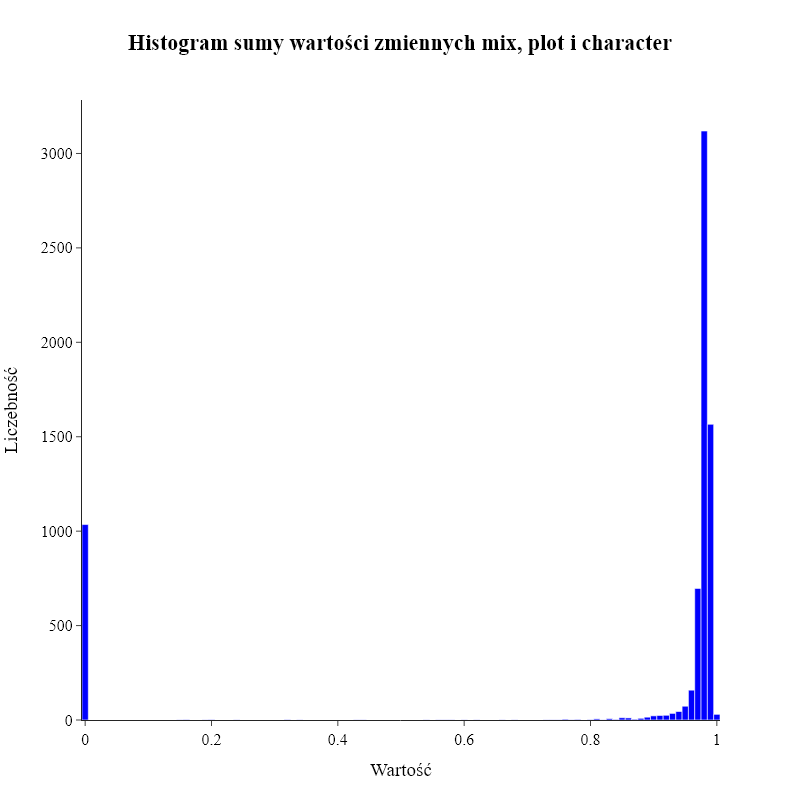

In [13]:
plots.hist_plot((data["mix"] + data["plot"] + data["character"]), name="Histogram sumy wartości zmiennych mix, plot i character", bin_size=0.01)

$\text{Dla większości obserwacji suma jest zbliżona do 1 (niedokładność wynika z błędu zaokrąglenia na stronie internetowej).}$<p>
$\text{Znajduje się jednak wiele takich obserwacji, dla których suma wynosi 0, co ma związek z brakiem informacji na stronie.}$<p>
$\text{Ponadto w przypadku niektórych książek (np.: }$ https://app.thestorygraph.com/books/08ff4f79-416d-44b2-a015-7d73c942e628 $\text{) pozycja N/A przyjmuje wartości większe niż 0.}$<p>
$\text{Tym samym zdecydowano się na utworzenie zmiennej 'Unknown', która będzie dopełnieniem sumy do 1 i będzie informować o braku danych dotyczących oparcia książki na fabule lub postaciach.}$

In [14]:
data["Unknown"] = 1 - (data["mix"] + data["plot"] + data["character"])

## Zmienne Moods

$\text{Kolejne zmienne w zbiorze danych to wartości procentowe określające nastroje książki.}$<p>
$\text{Są to kolejno:}$<p>
$\qquad \text{- funny,}$<p>
$\qquad \text{- lighthearted,}$<p>
$\qquad \text{- emotional,}$<p>
$\qquad \text{- hopeful,}$<p>
$\qquad \text{- inspiring,}$<p>
$\qquad \text{- relaxing,}$<p>
$\qquad \text{- tense,}$<p>
$\qquad \text{- sad,}$<p>
$\qquad \text{- reflective,}$<p>
$\qquad \text{- adventurous,}$<p>
$\qquad \text{- challenging,}$<p>
$\qquad \text{- informative,}$<p>
$\qquad \text{- mysterious,}$<p>
$\qquad \text{- dark.}$<p>
$\text{Podobnie jak w przypadku zmiennych mix, plot oraz character, w celu łatwiejsze interpretacji wartości zostaną przemnożone przez 100.}$

In [15]:
moods = ['funny', 'lighthearted', 'emotional', 'hopeful', 'inspiring', 'relaxing', 'tense', 'sad', 'reflective', 'adventurous', 'challenging', 'informative', 'mysterious', 'dark']
for mood in moods:
    data[mood] = data[mood]*100

# Podstawowe informacje o zbiorze danych

In [16]:
def base_information(data):
    df =  pd.DataFrame(data.dtypes, columns=['dtypes'])
    df['Number of missing values'] = data.isna().sum()
    df['Percentage of missing values'] = data.isna().sum()/data.shape[0]
    df['Unique values'] = data.nunique().values
    df['Count'] = data.count().values
    return df.style.background_gradient(cmap='Blues')
base_information(data)

$\text{W zbiorze danych nie występują braki wartości.}$<p>
$\text{Mamy zarówno zmienne kategoryczne jak i numeryczne, które umieścimy w dwóch osobnych zbiorach.}$

In [17]:
categorical_features = ["series", "Literature and Art", "Fiction", "Science", "Crime", "Psychology", "Social", "Children", "Romans", "Biography", "Entertainment"]
target = "stars"
continous_features = data.columns.difference(categorical_features + [target]).tolist()

# Wizualizacja zmiennych

## starts (zmienna celu)

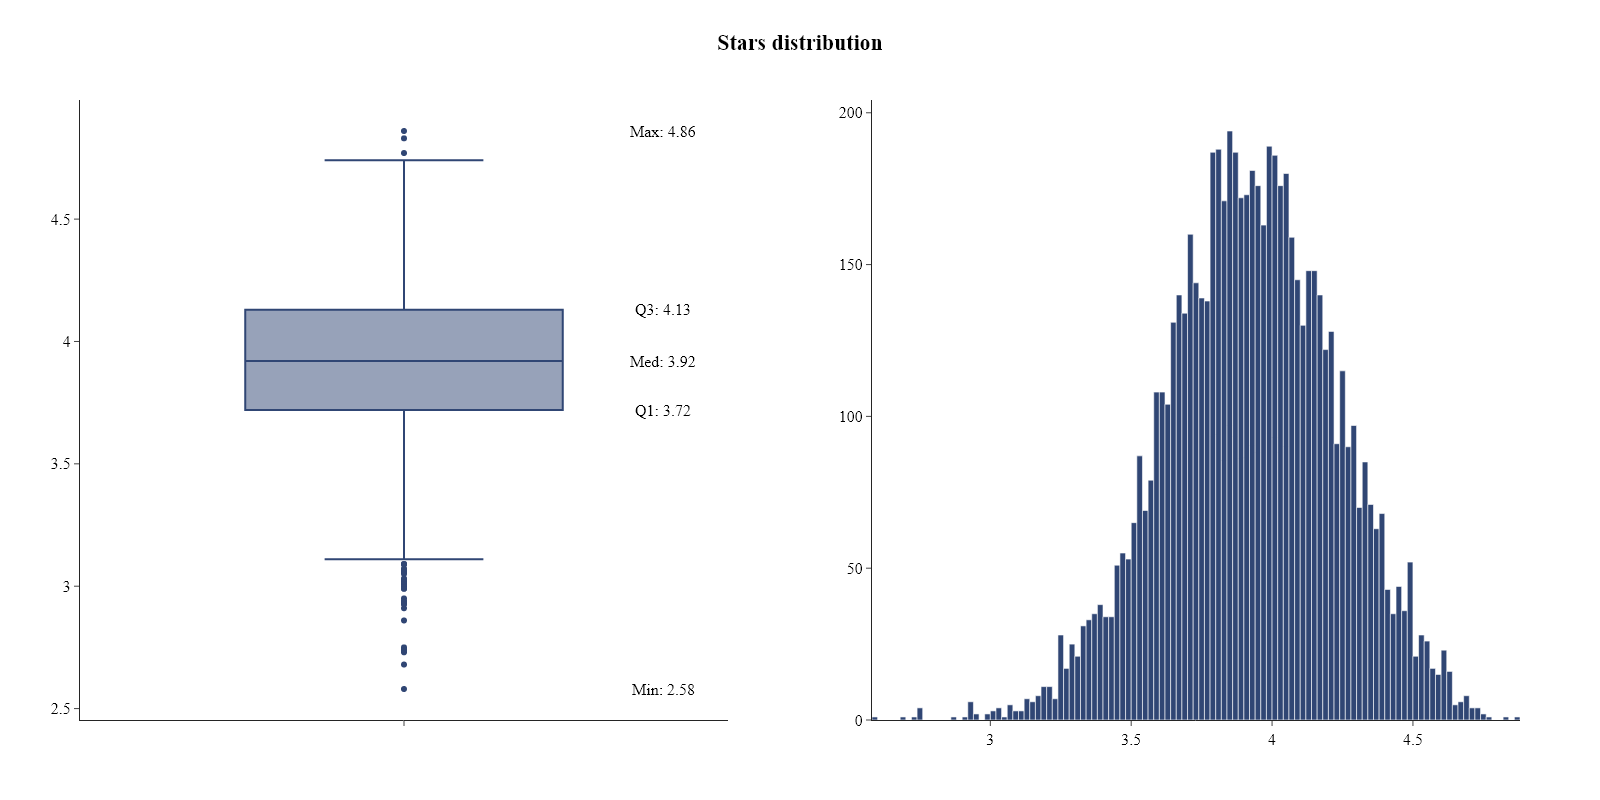

In [18]:
plots.histogram_and_box_plot(data[target], name="stars")

$\text{Rozkład zmiennej celu jest zbliżony do rozkładu normalnego.}$<p>
$\text{Mediana oscyluje w okolicach 4, a więcej wartości odstających znajduje się przy lewym ogonie rozkładu.}$

## Zmienne kategoryczne

### series

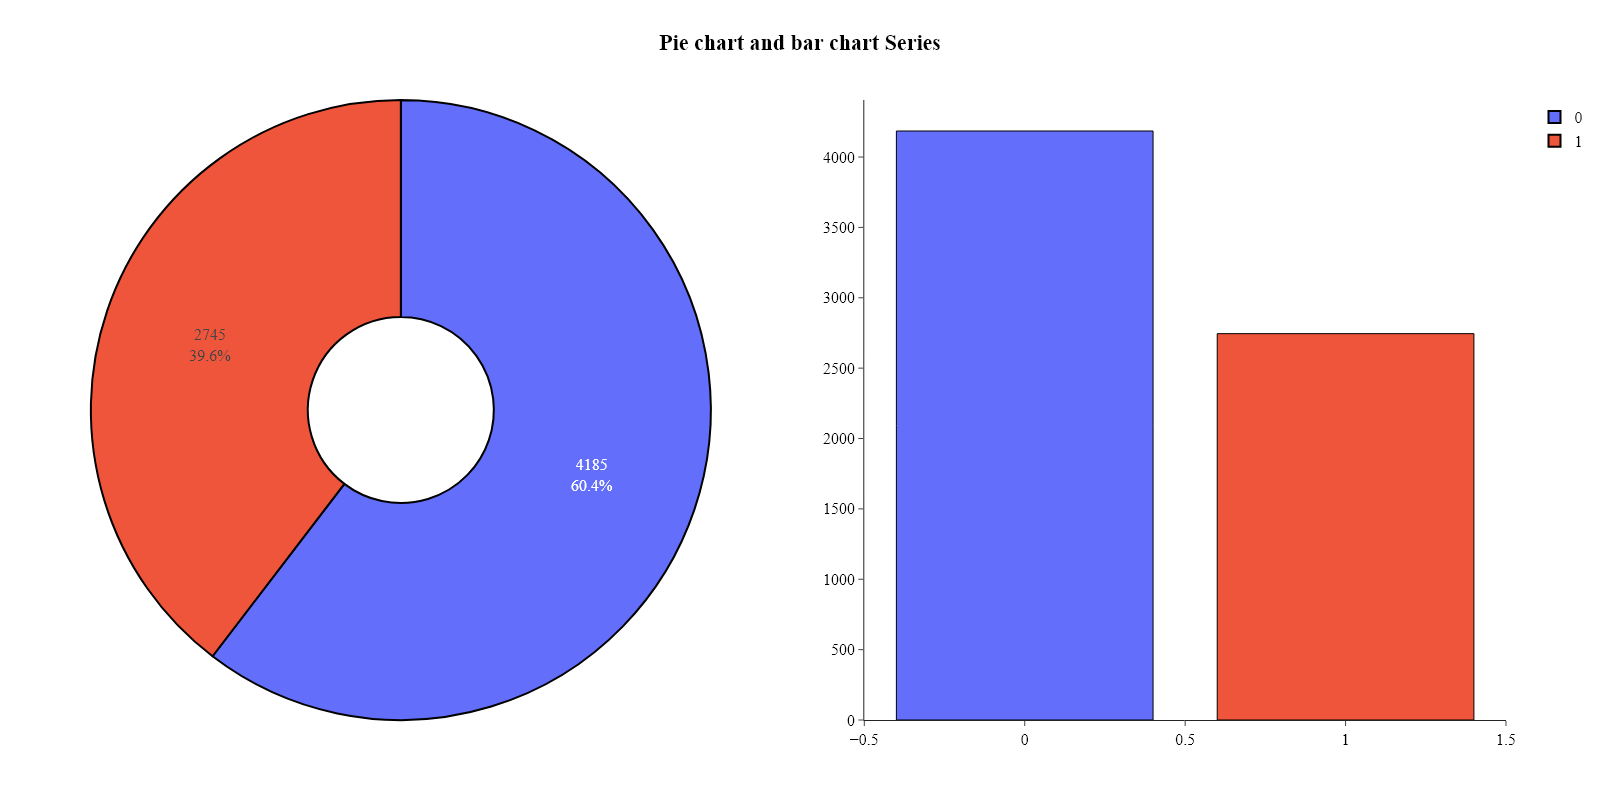

In [19]:
plots.pie_and_bar_plot(data["series"], name="series")

$\text{Większość książek (60\%) nie jest częścią serii.}$

### Literature and Art

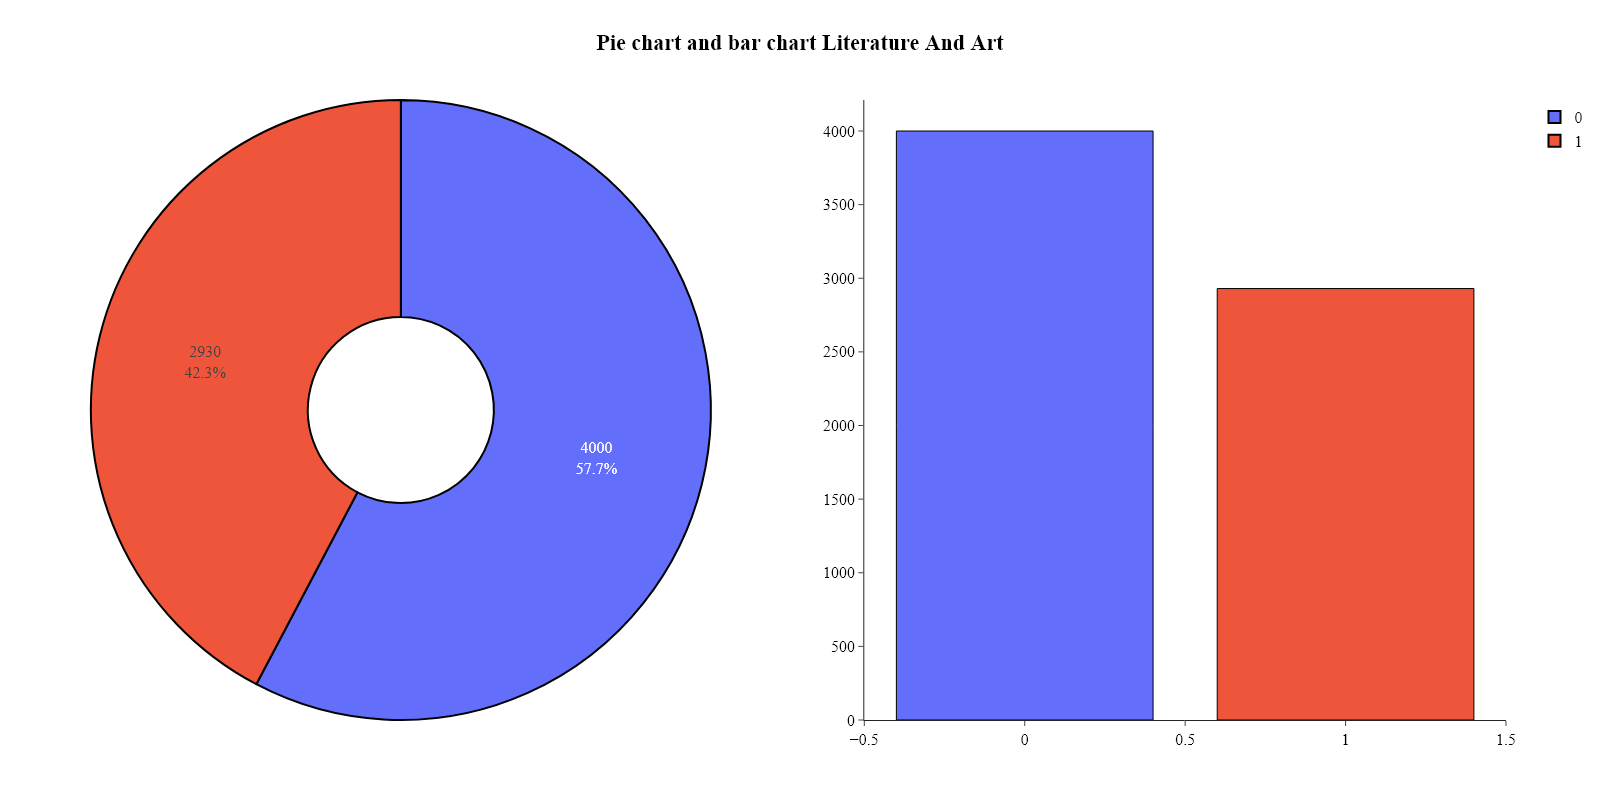

In [20]:
plots.pie_and_bar_plot(data["Literature and Art"], name="Literature and Art")

$\text{Około 42\% książek należy do kategorii Literatura i Sztuka.}$

### Fiction

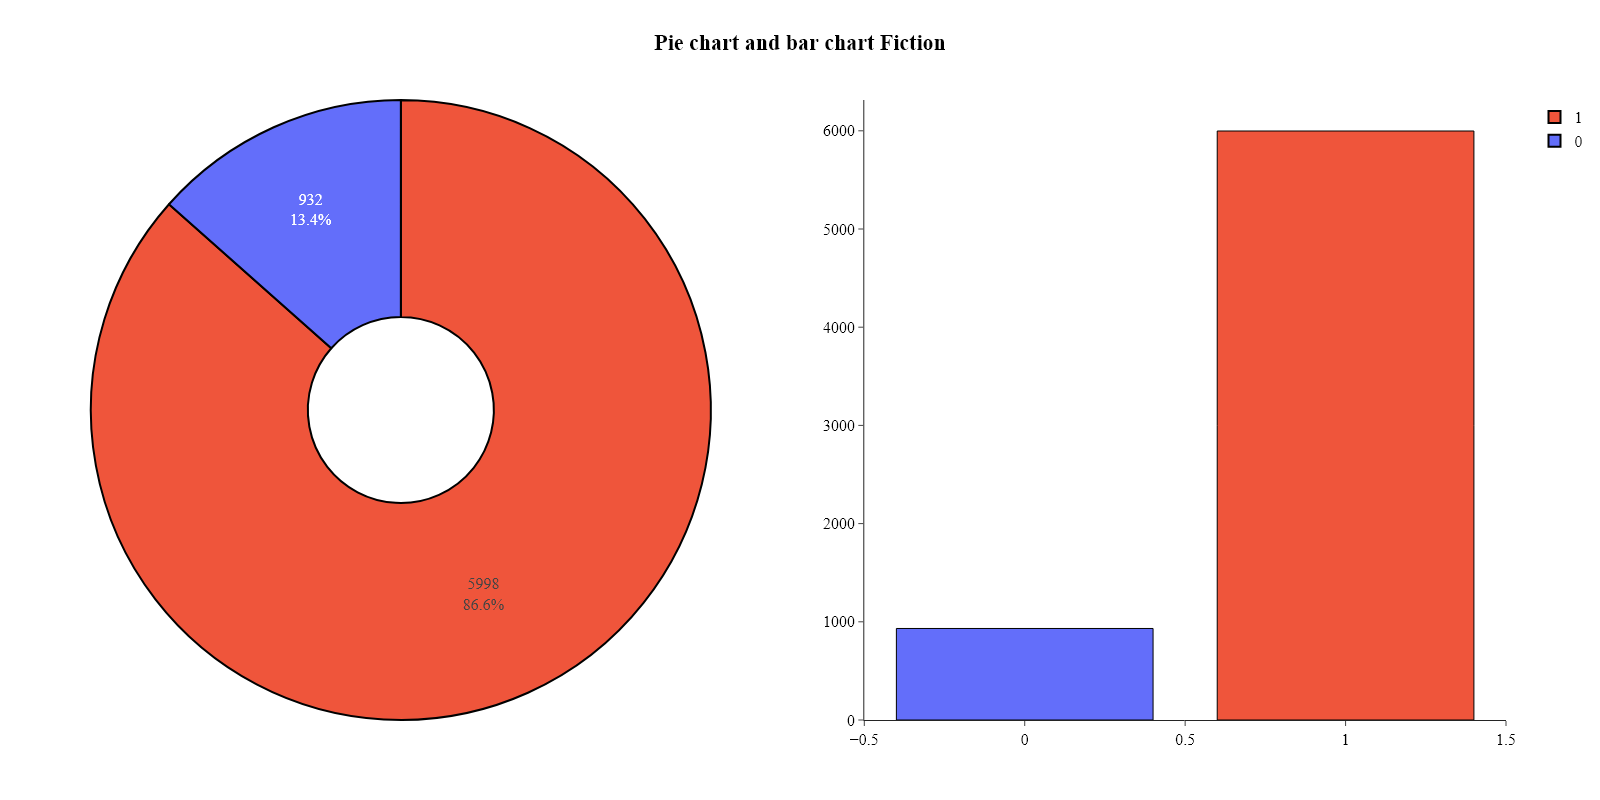

In [21]:
plots.pie_and_bar_plot(data["Fiction"], name="Fiction")

$\text{Zdecydowaną większość książek stanowią książki z kategorii Fikcja.}$

### Science

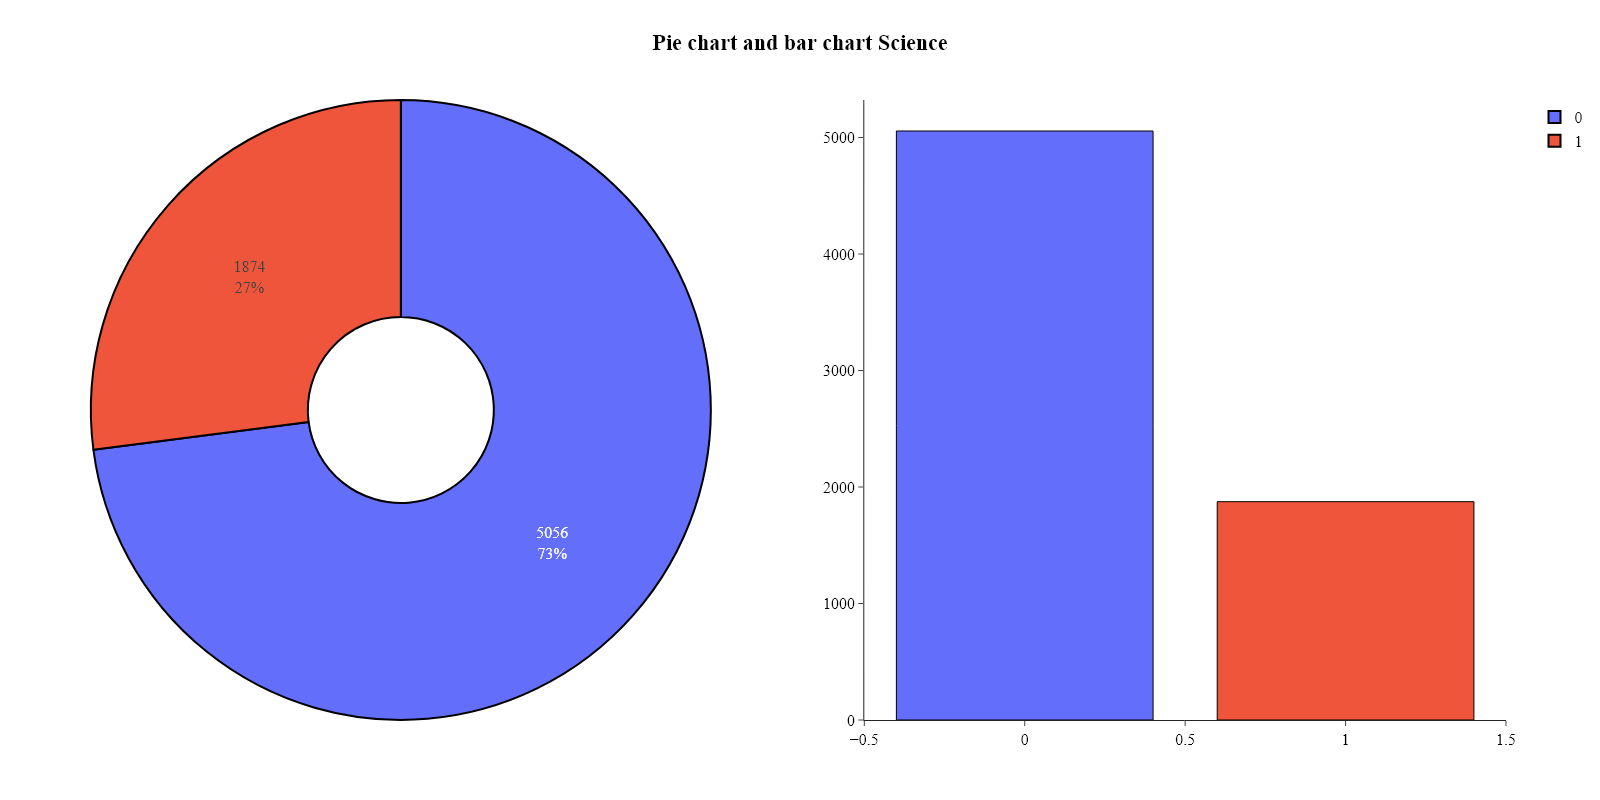

In [22]:
plots.pie_and_bar_plot(data["Science"], name="Science")

$\text{27\% książek możemy przypisać do kategorii Nauka.}$

### Crime

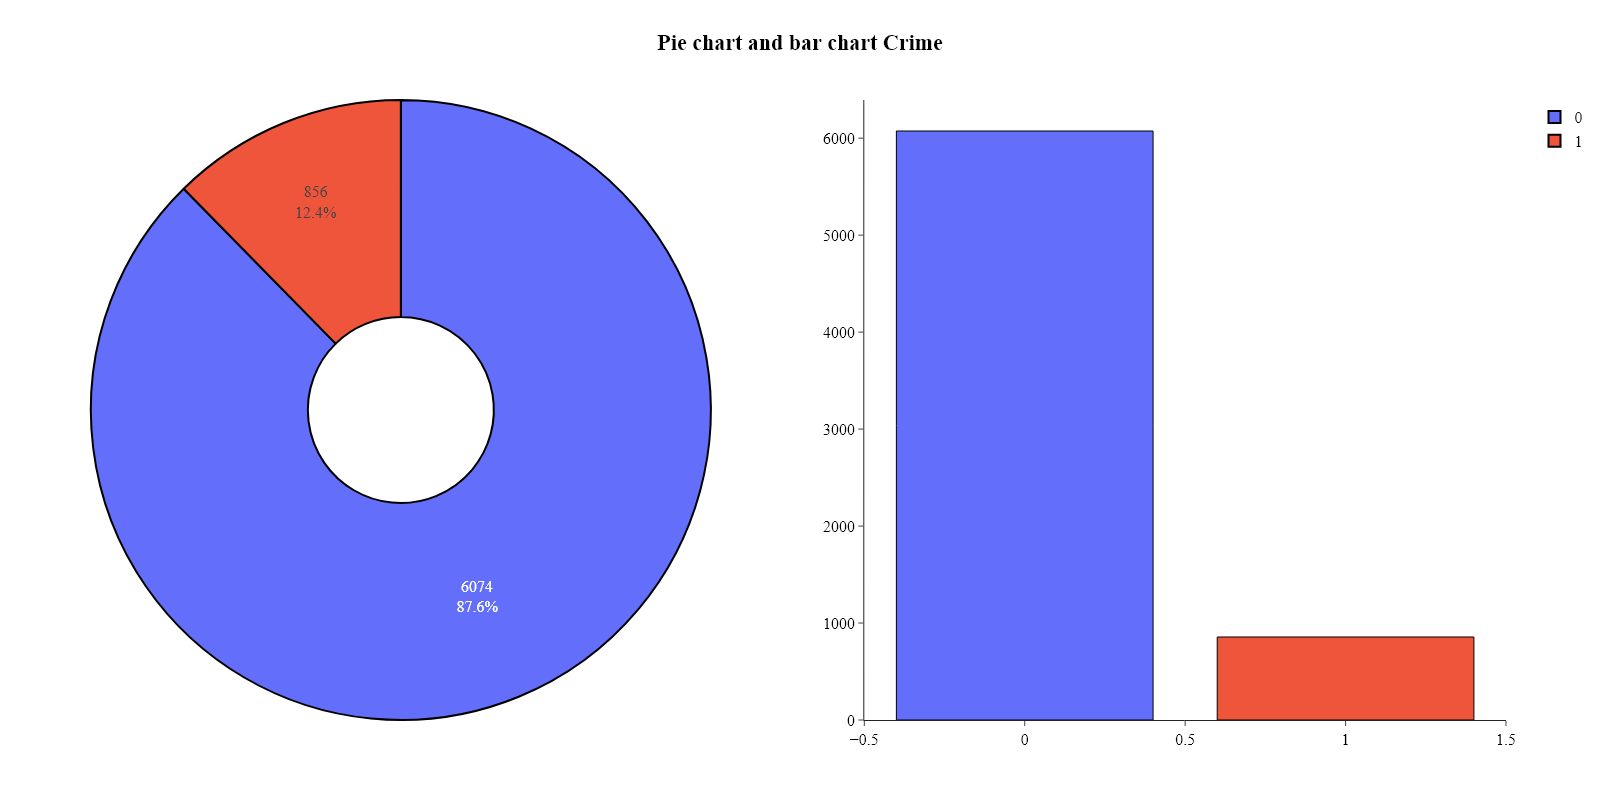

In [23]:
plots.pie_and_bar_plot(data["Crime"], name="Crime")

$\text{Ponad 87\% książek nie należy do kategorii Kryminał.}$

### Psychology

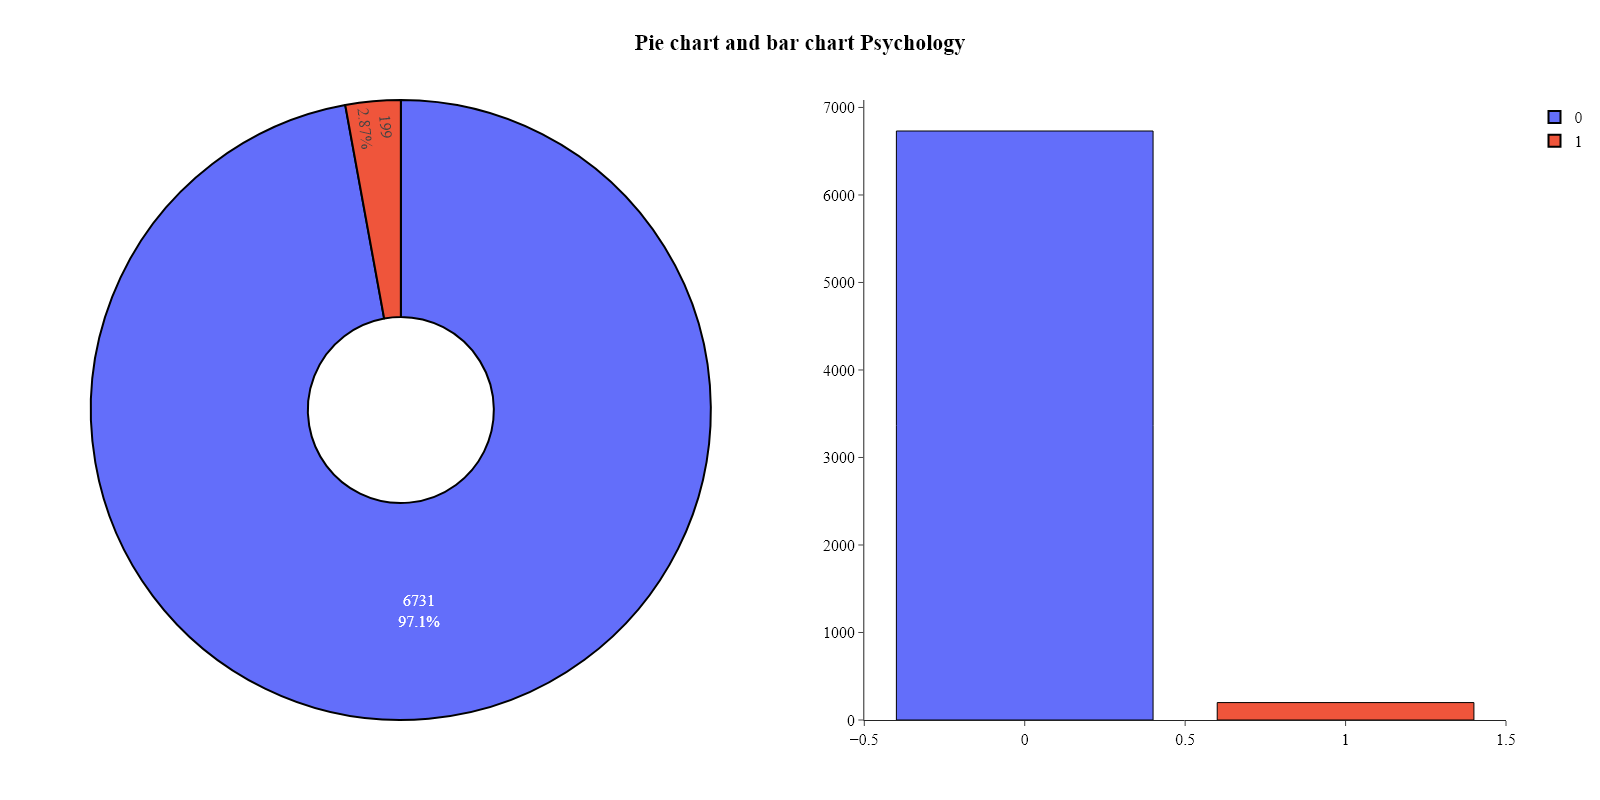

In [24]:
plots.pie_and_bar_plot(data["Psychology"], name="Psychology")

$\text{Niecałe 3\% książek należy do kategorii Psychologia.}$

### Social

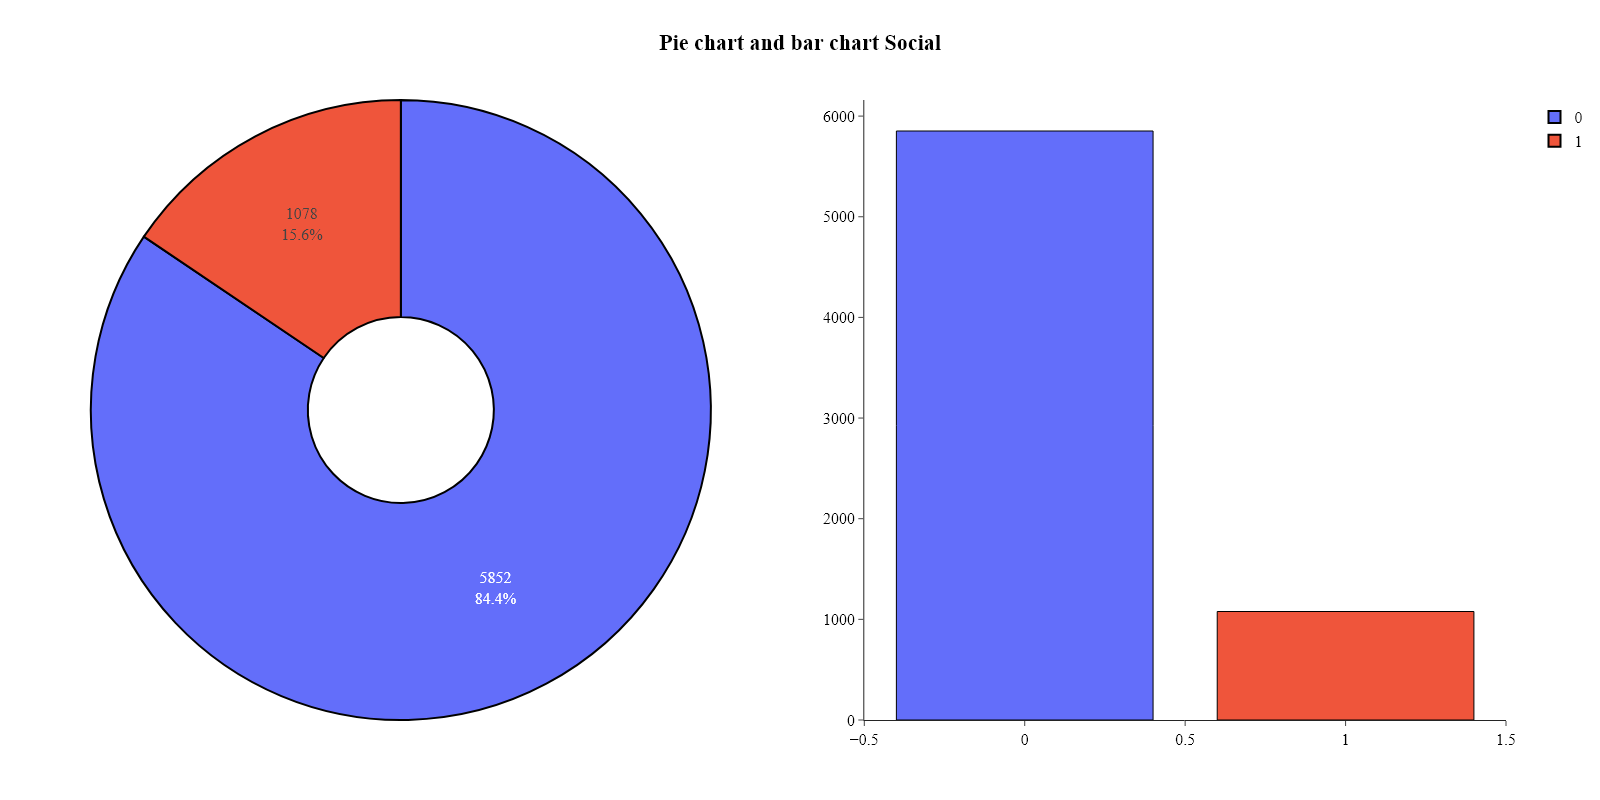

In [25]:
plots.pie_and_bar_plot(data["Social"], name="Social")

$\text{Około 16\% książek należy do kategorii Społeczne.}$

### Children

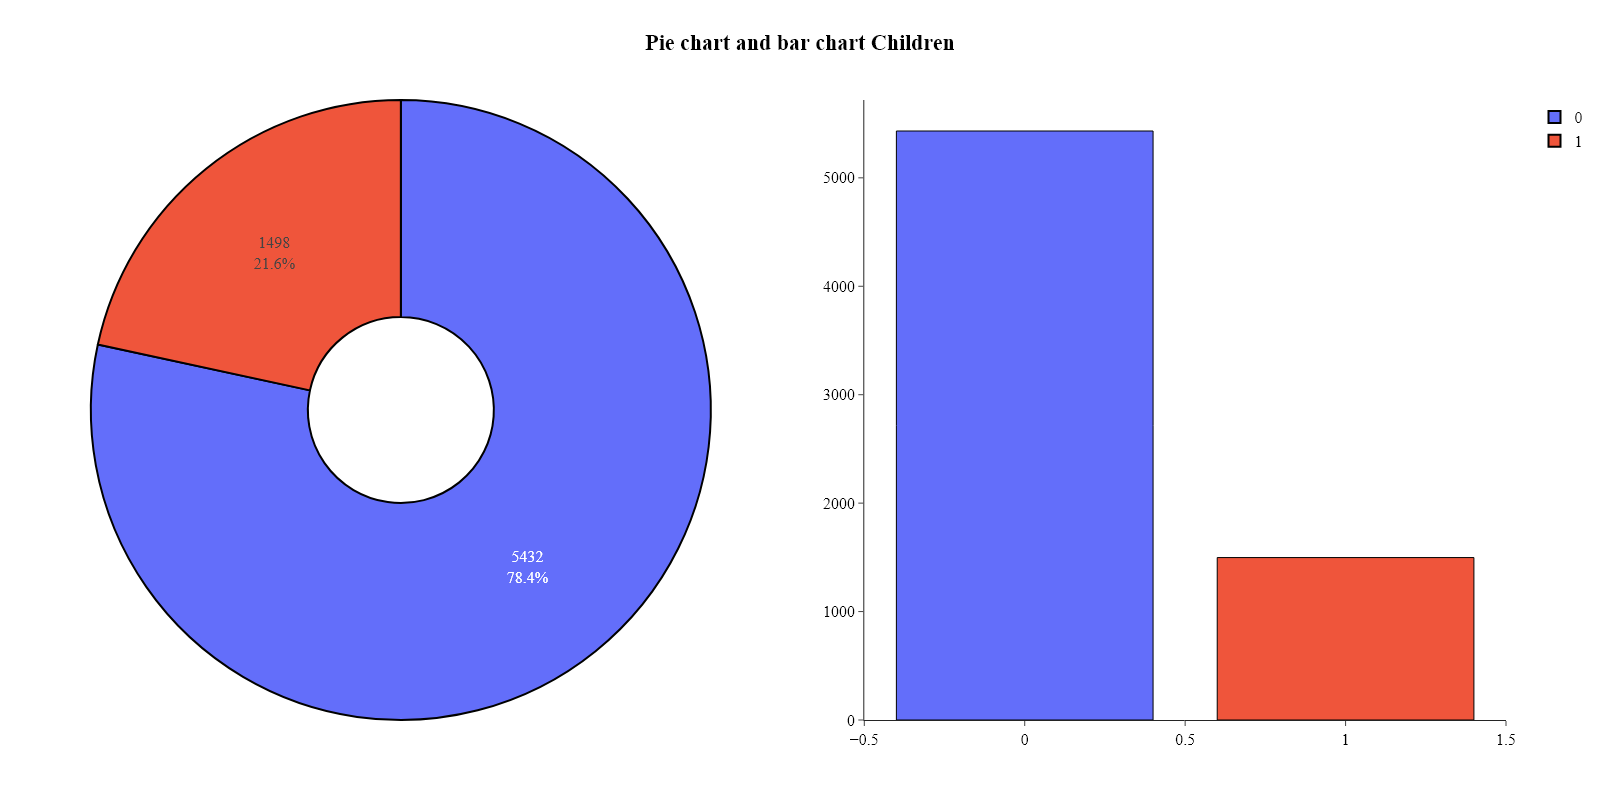

In [26]:
plots.pie_and_bar_plot(data["Children"], name="Children")

$\text{21.6\% książek w zbiorze danych jest przeznaczona dla osób poniżej 18 roku życia.}$

### Romans

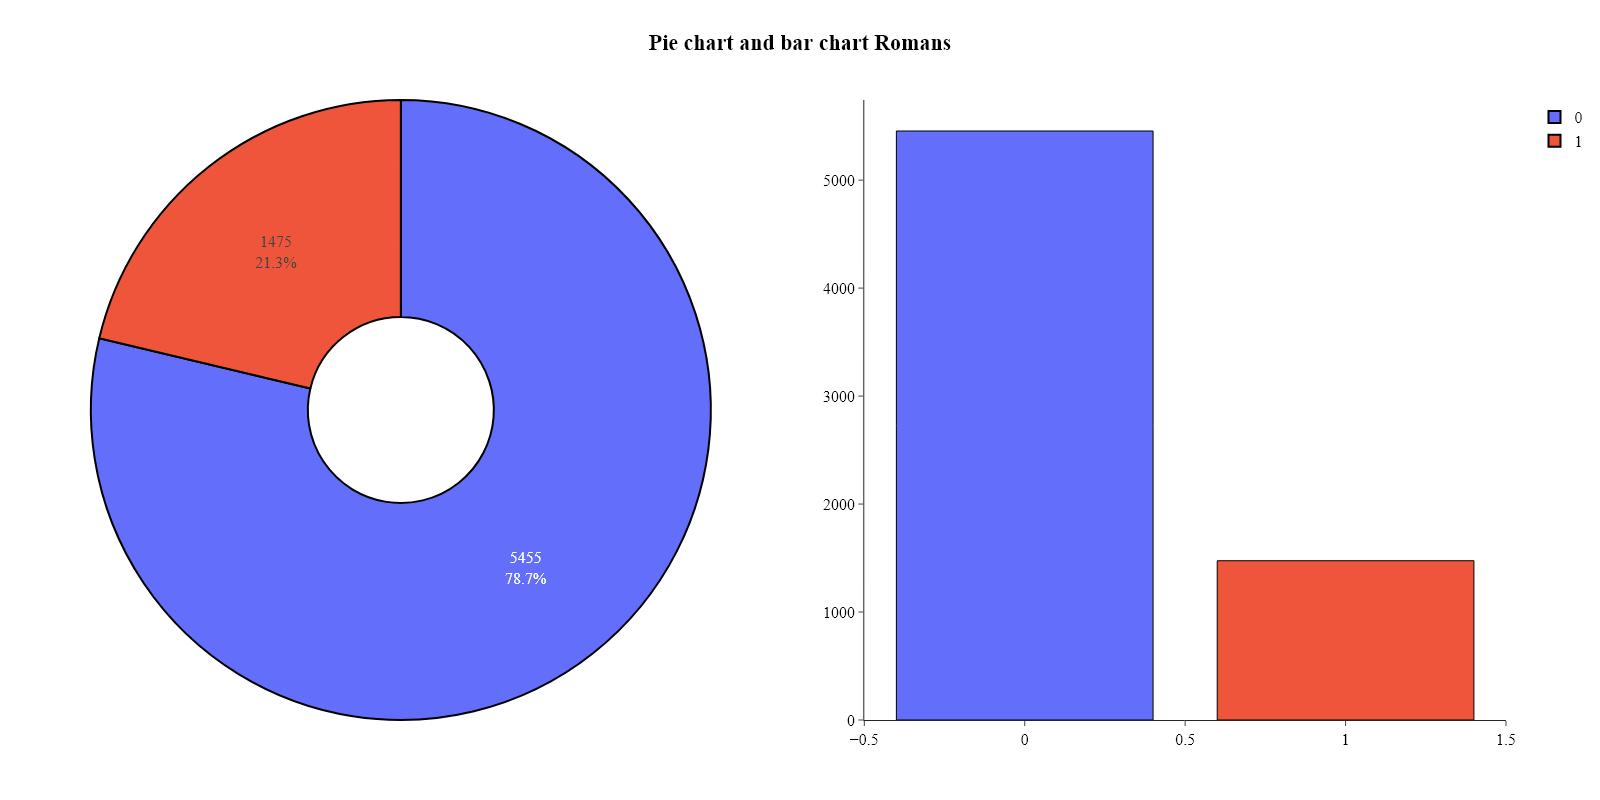

In [27]:
plots.pie_and_bar_plot(data["Romans"], name="Romans")

$\text{Około 21\% książek w danych to romanse.}$

### Biography

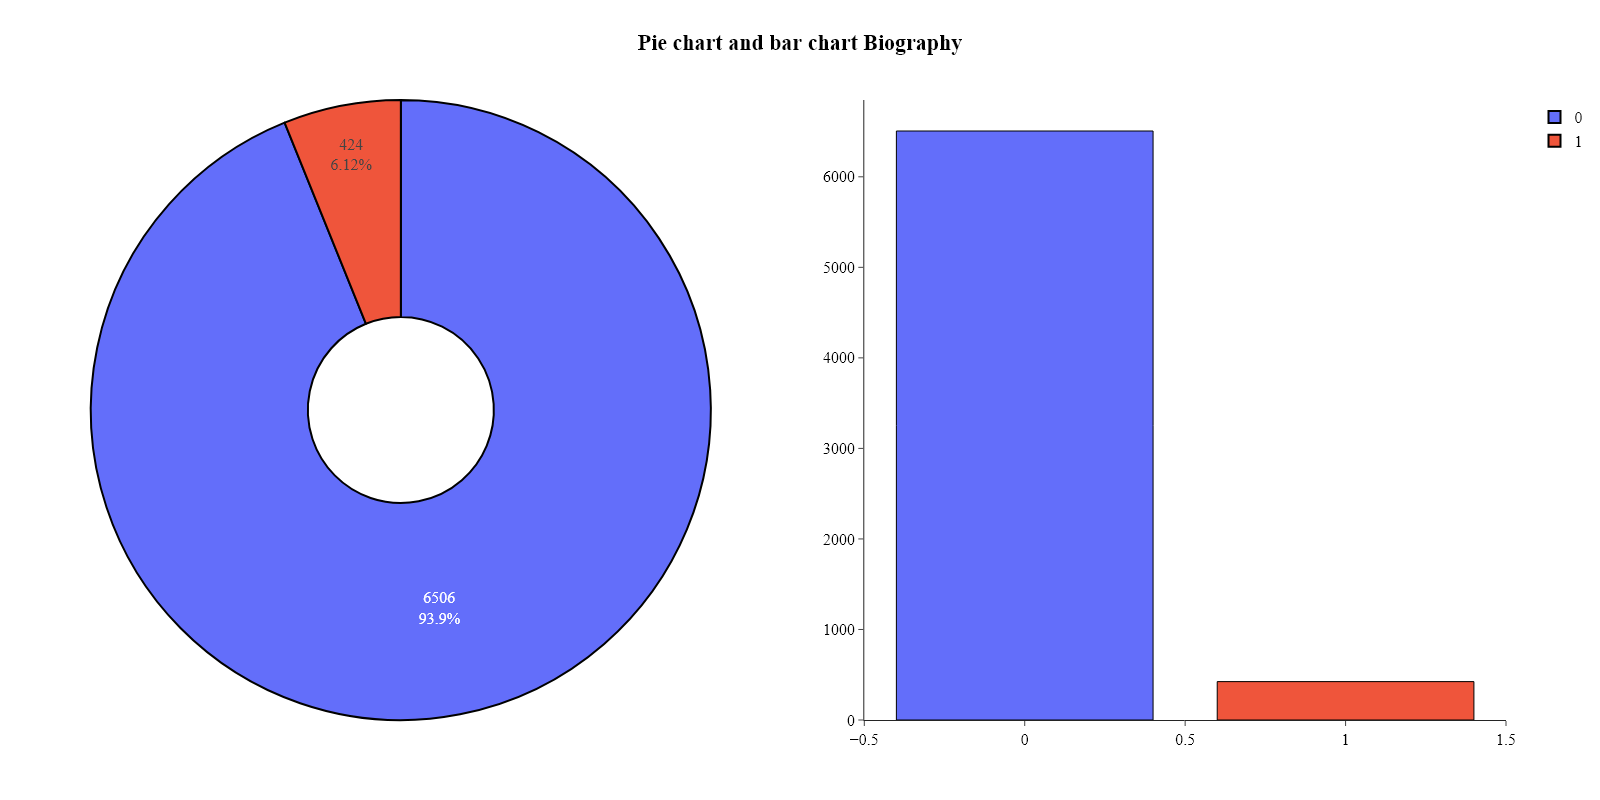

In [28]:
plots.pie_and_bar_plot(data["Biography"], name="Biography")

$\text{Rozkład wygląda podobnie jak w przypadku kategorii psychologia - niewielką część książek stanowią biografie.}$

### Entertainment

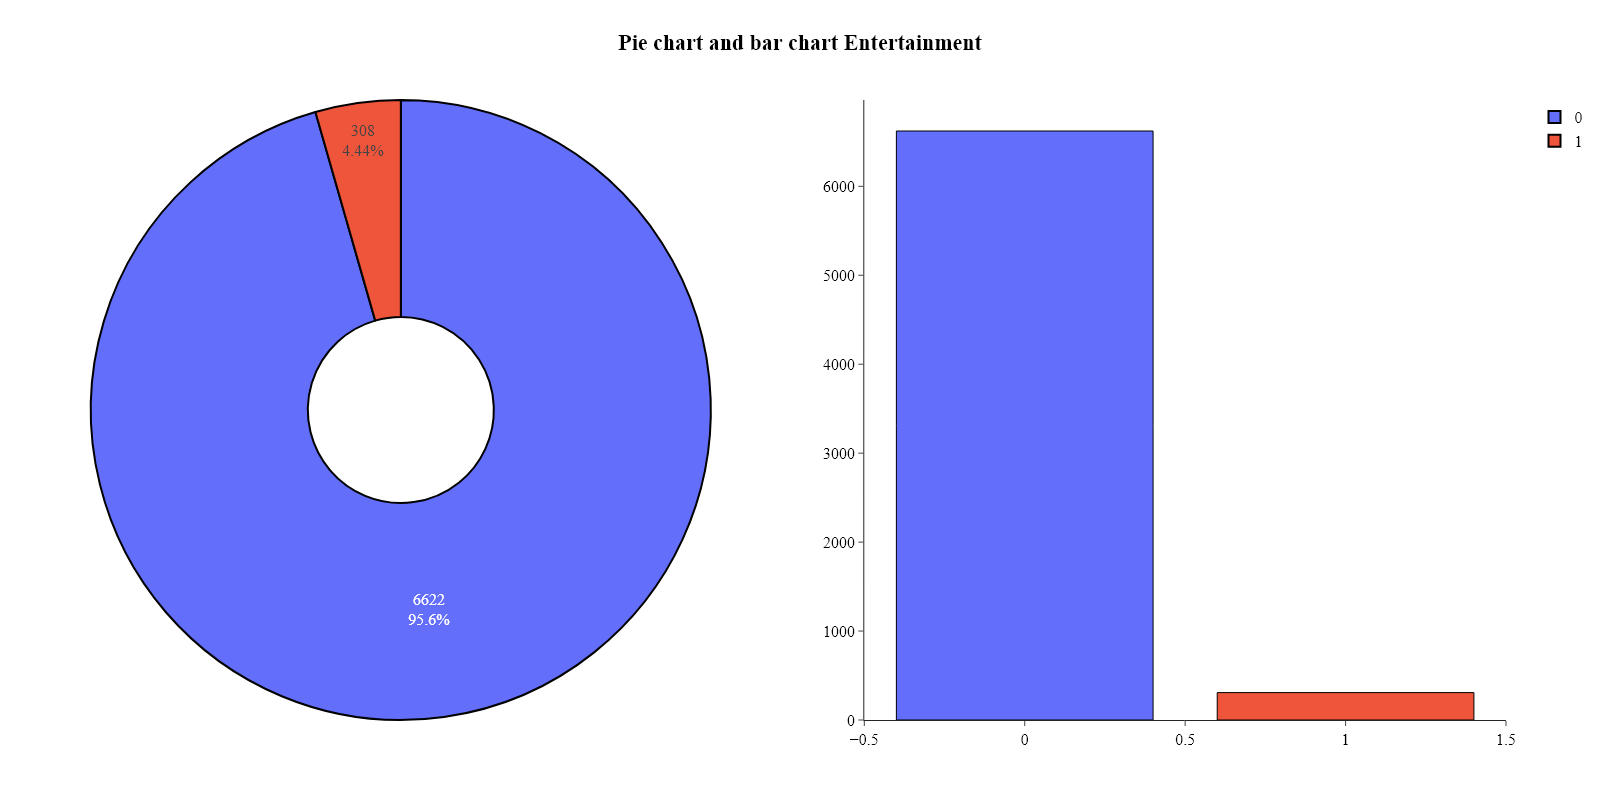

In [29]:
plots.pie_and_bar_plot(data["Entertainment"], name="Entertainment")

$\text{Tak samo jak dla Psychologii i Biografii, niewielka część książek należy do kategorii Rozrywka.}$

## Zmienne ciągłe

### pages

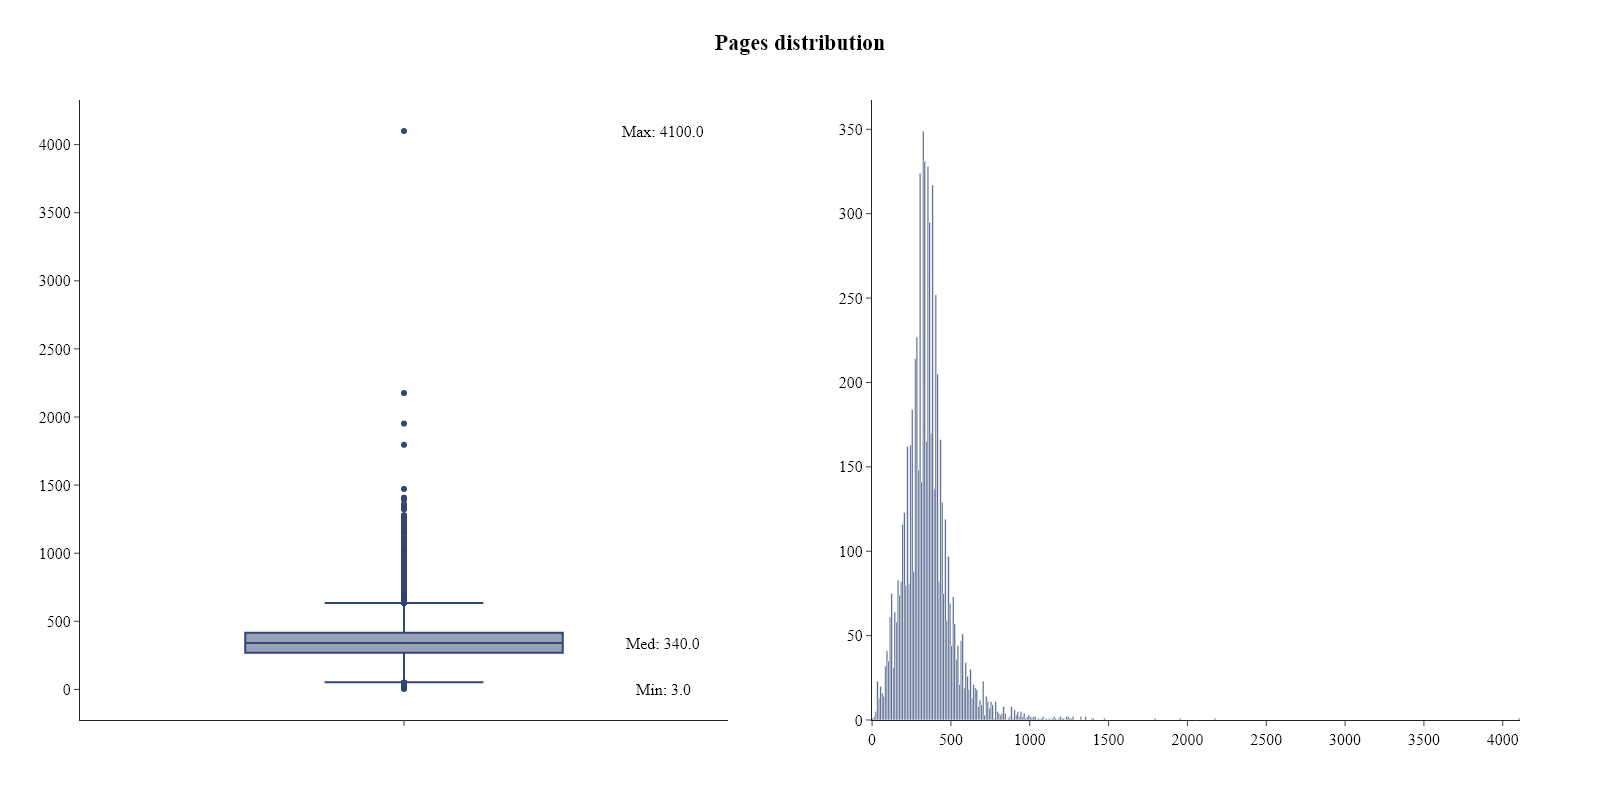

In [30]:
plots.histogram_and_box_plot(data["pages"], name="pages", annotation=["Min","Med","Max"])

$\text{Większość obserwacji skoncentrowana jest w okolicach 300 stron.}$<p>
$\text{Liczba stron znajduje się w przedziale od 3 do 4100, co wskazuje na dużą różnorodność wśród książek.}$

### reviews

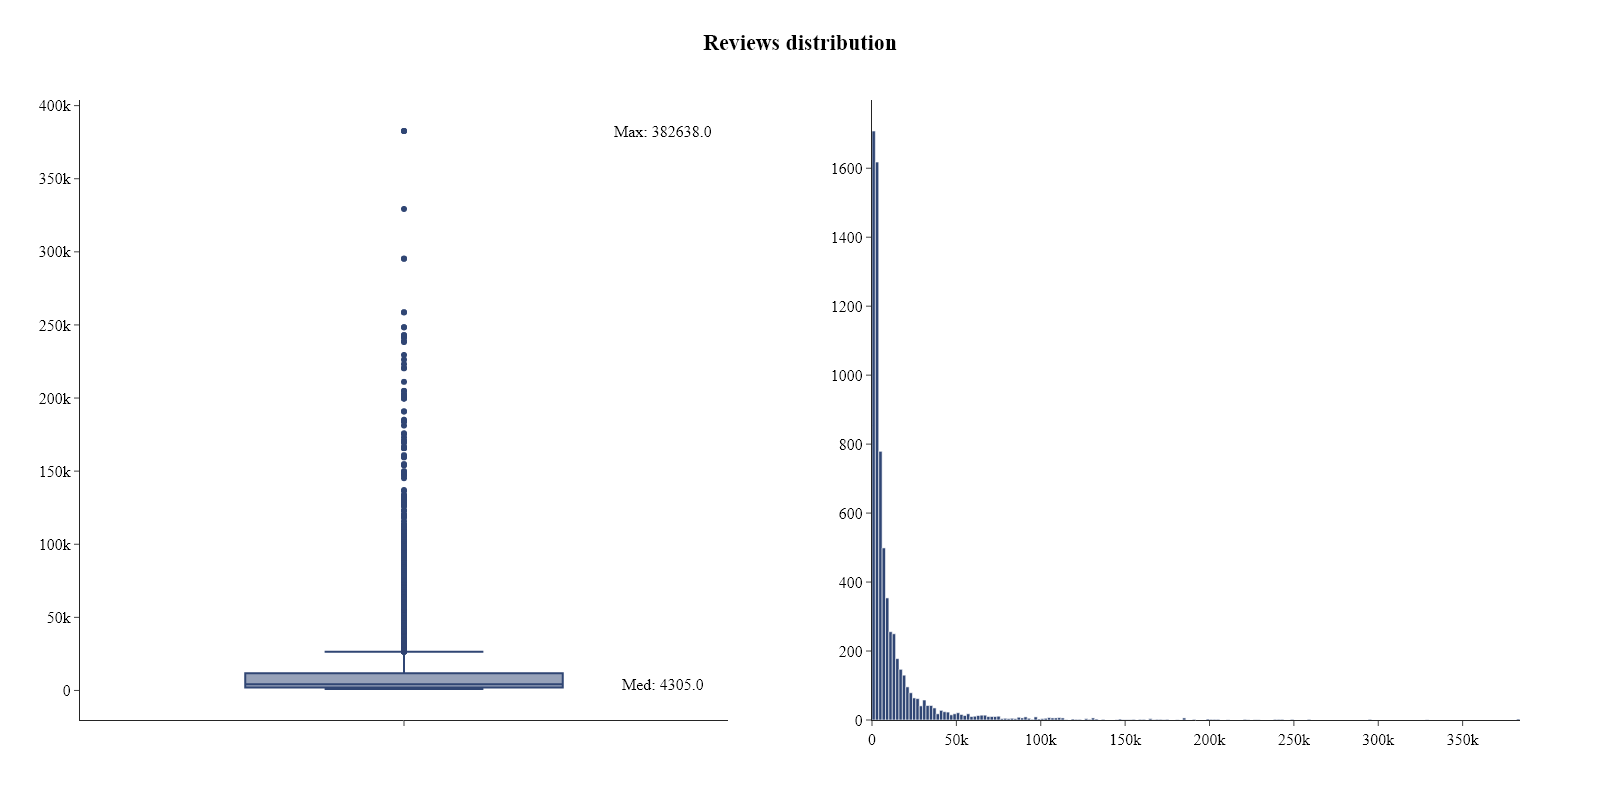

In [31]:
plots.histogram_and_box_plot(data["reviews"], name="reviews", annotation=["Med","Max"])

$\text{Zmienna dotycząca liczby recenzji jest prawostronnie skośna.}$

### mix

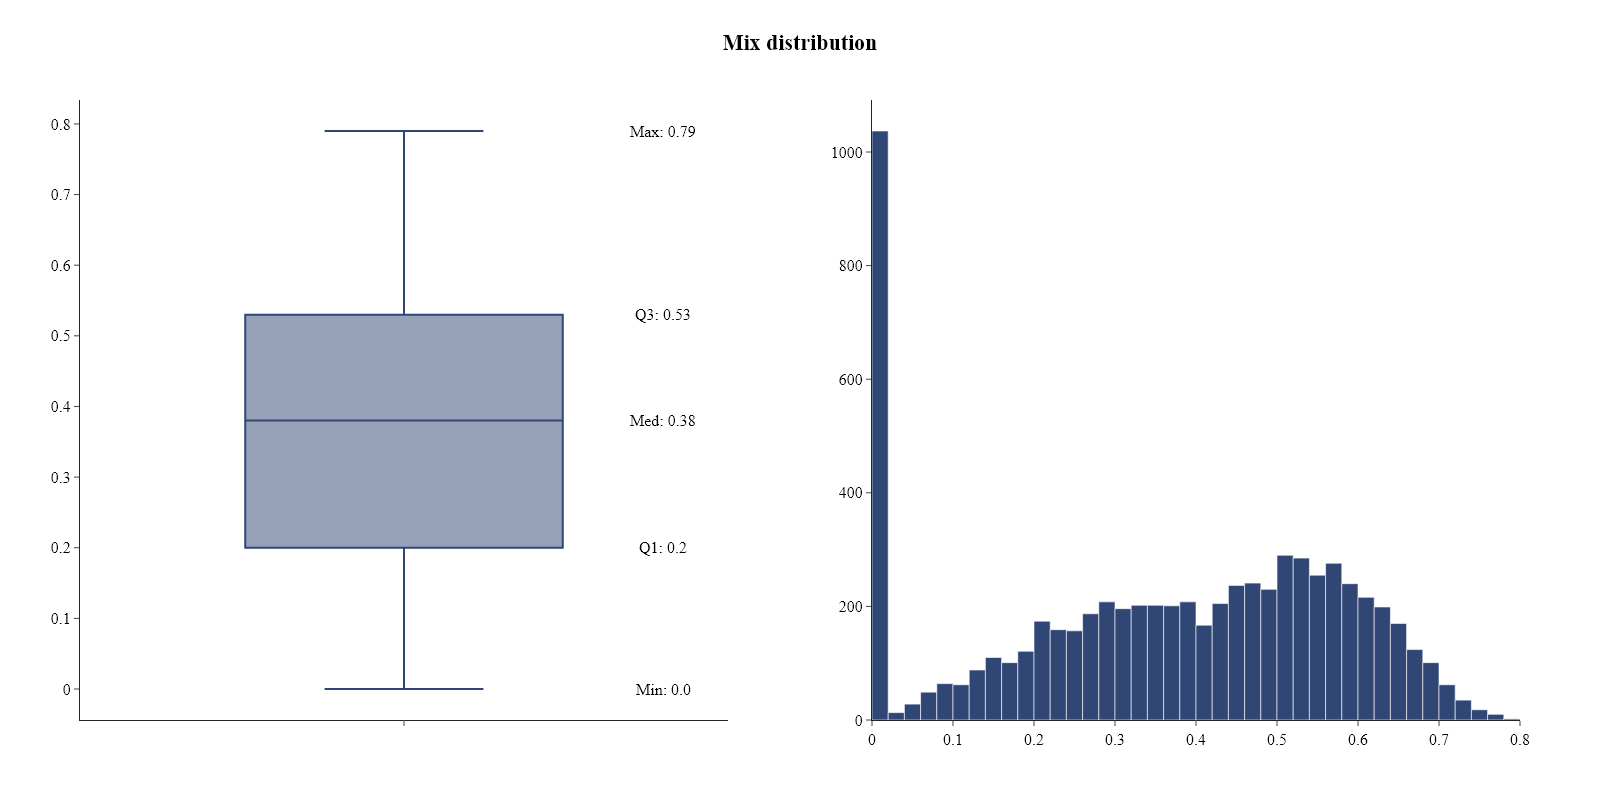

In [32]:
plots.histogram_and_box_plot(data["mix"], name="mix")

$\text{W przypadku dużej liczby obserwacji wartości zmiennej mix wynoszą 0.}$<p>
$\text{Poza tą skrajną wartością, rozkład jest stosunkowo równomiernie rozłożony.}$

### character

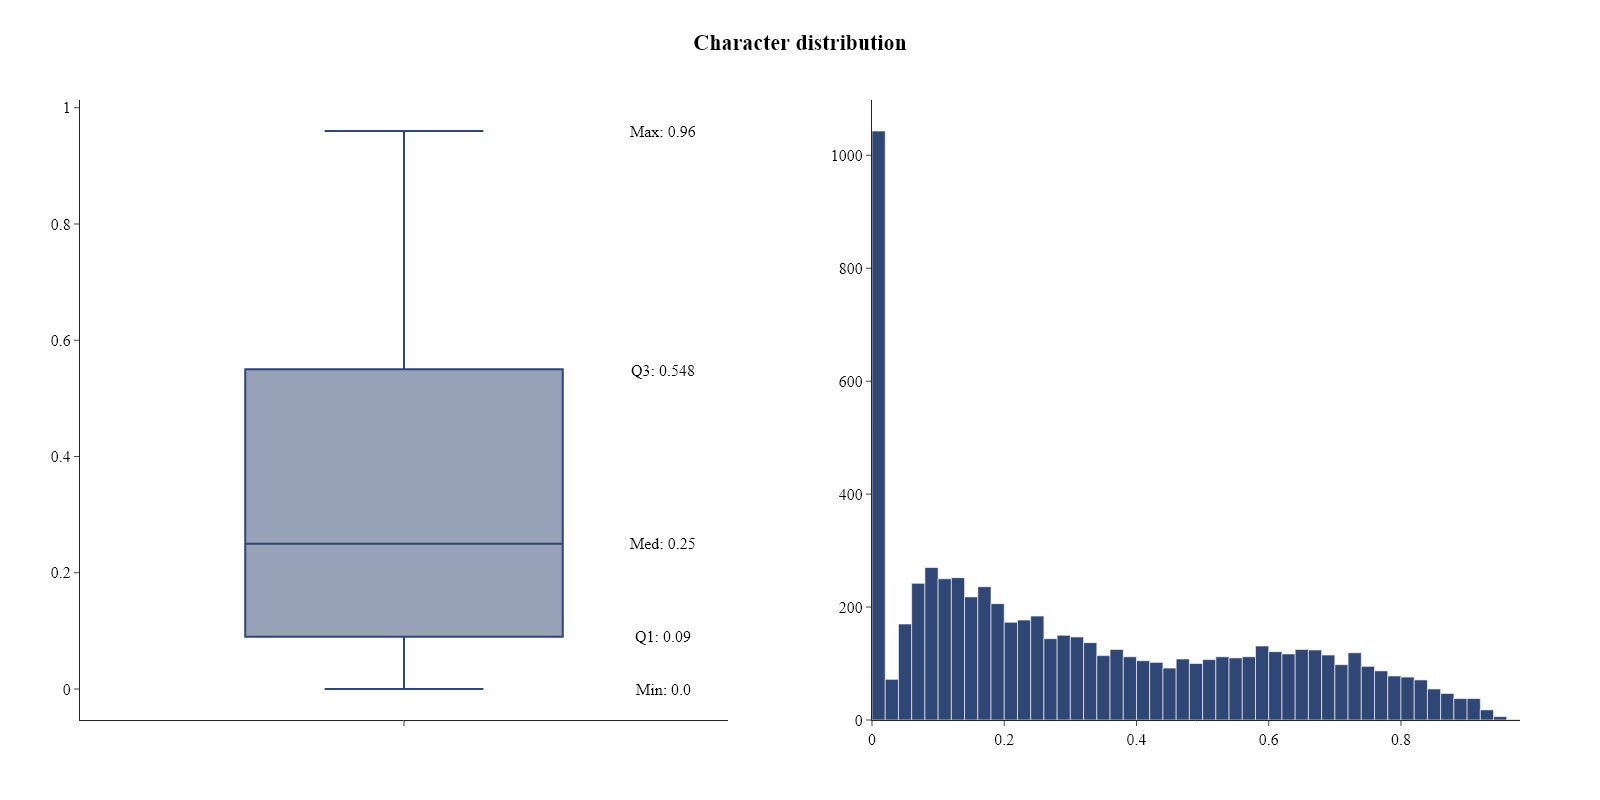

In [33]:
plots.histogram_and_box_plot(data["character"], name="character")

$\text{Rozkład wygląda podobnie jak w przypadku zmiennej mix.}$

### plot

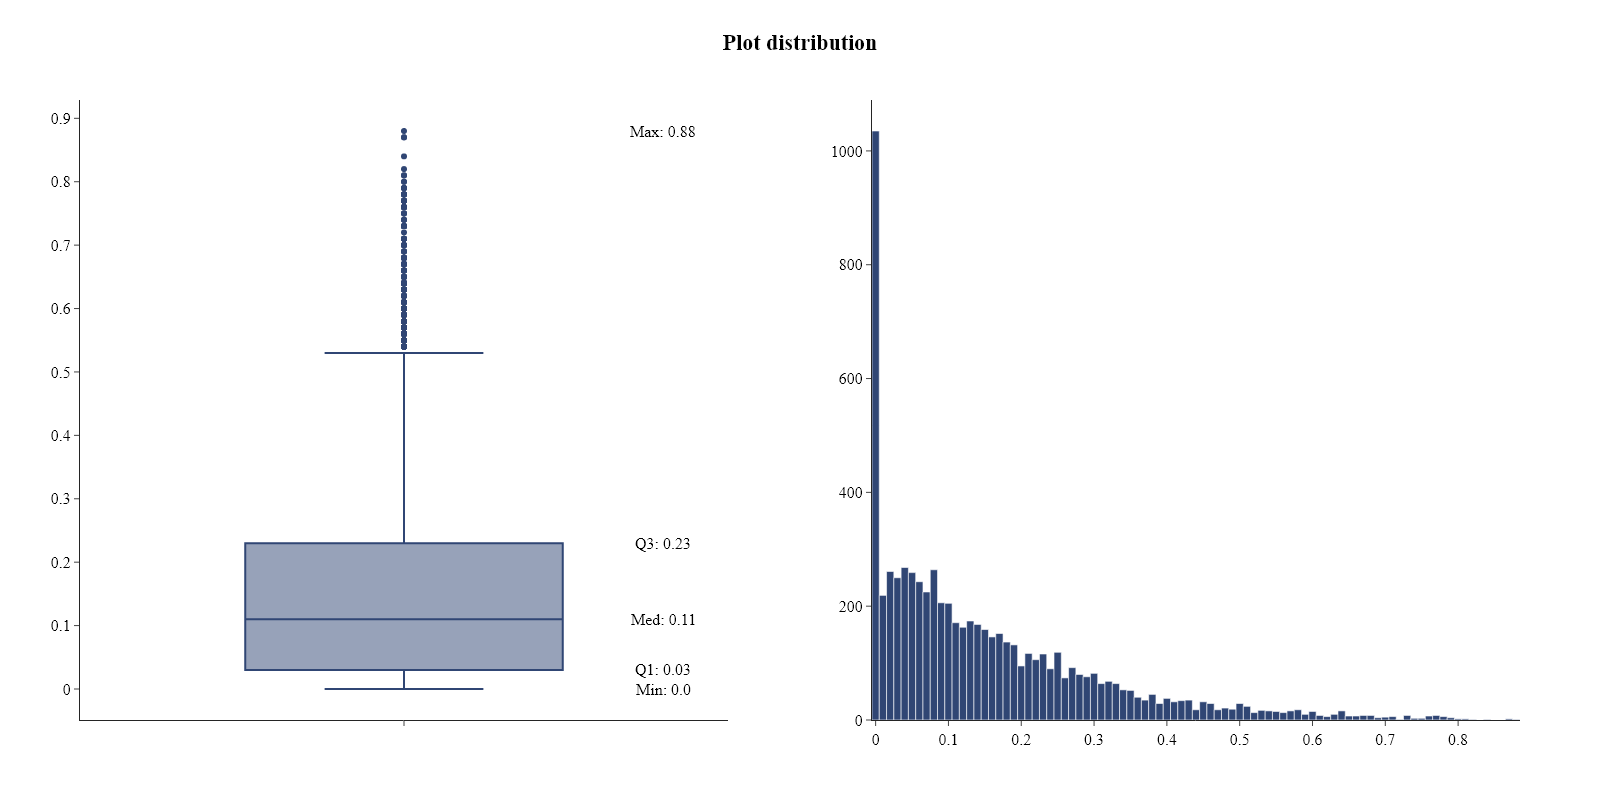

In [34]:
plots.histogram_and_box_plot(data["plot"], name="plot")

$\text{W przypadku zmiennej plot, rozkład jest bardziej skupiony wokół wartości 0.}$<p>
$\text{Sugeruje to, że większość książek nie jest oparta na fabule.}$

### Unknown

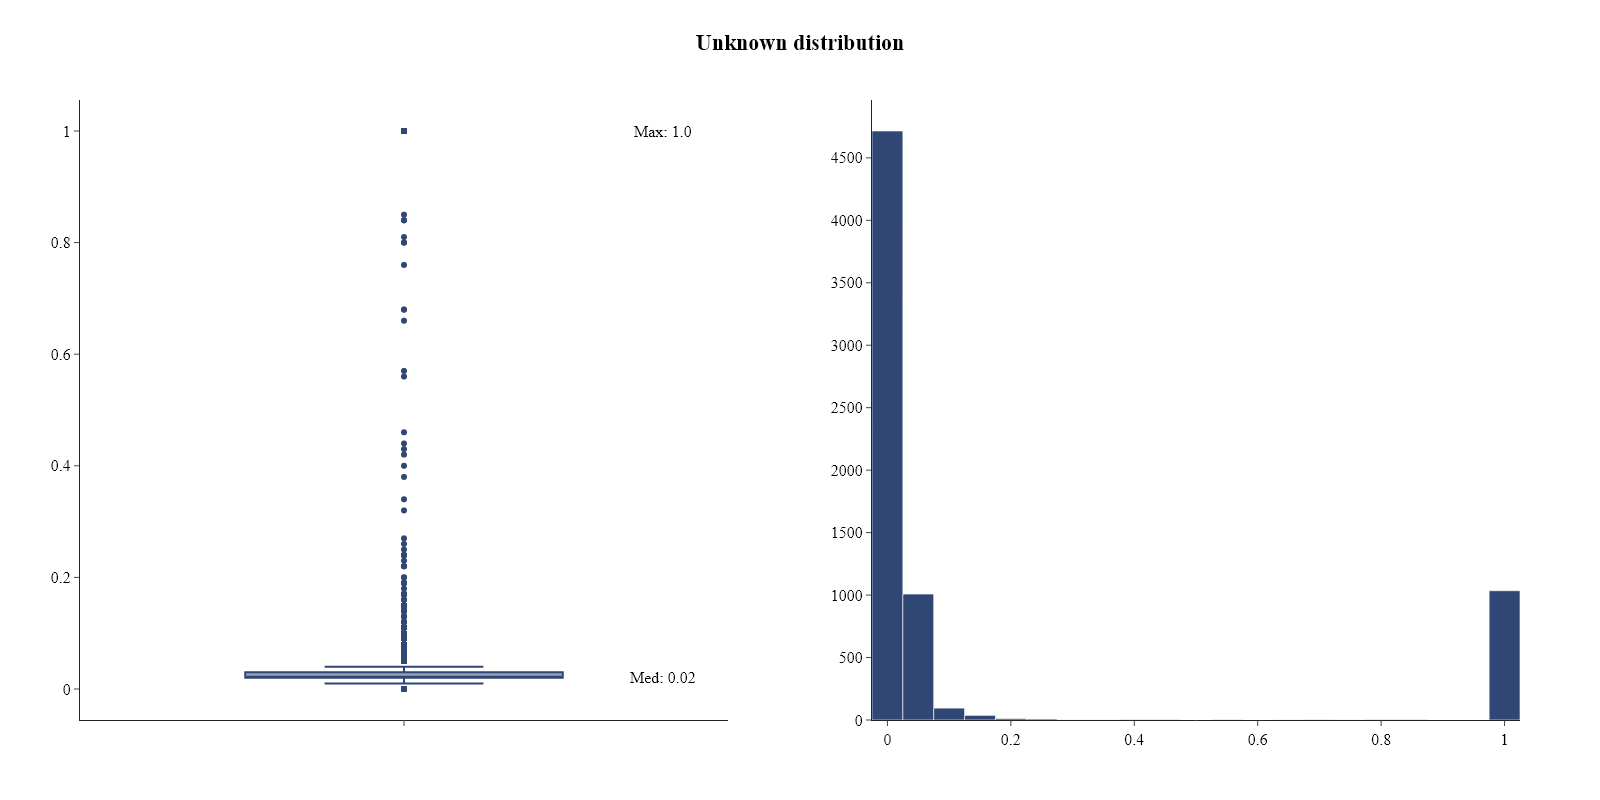

In [35]:
plots.histogram_and_box_plot(data["Unknown"], name="Unknown", annotation=["Med","Max"])

$\text{Utworzona przez nas zmienna Unknown znajduje się w przedziale [0, 1], z czego większość wartości znajduje się na krańcach przedziału.}$

### funny

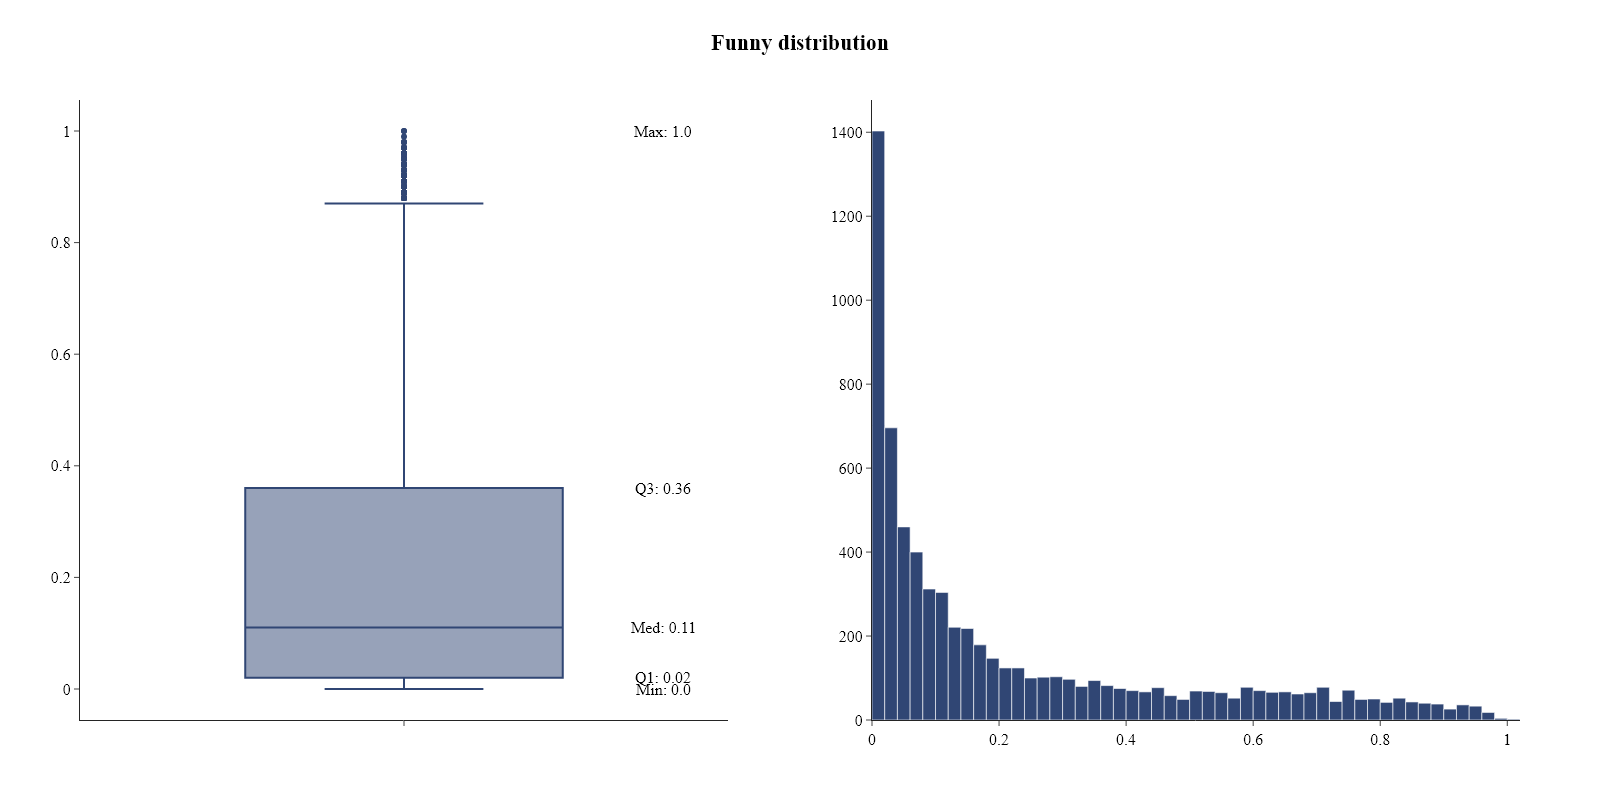

In [36]:
plots.histogram_and_box_plot(data["funny"], name="funny")

$\text{funny ma niemal modelowy rozkład prawostronnie skośny.}$

### lighthearted

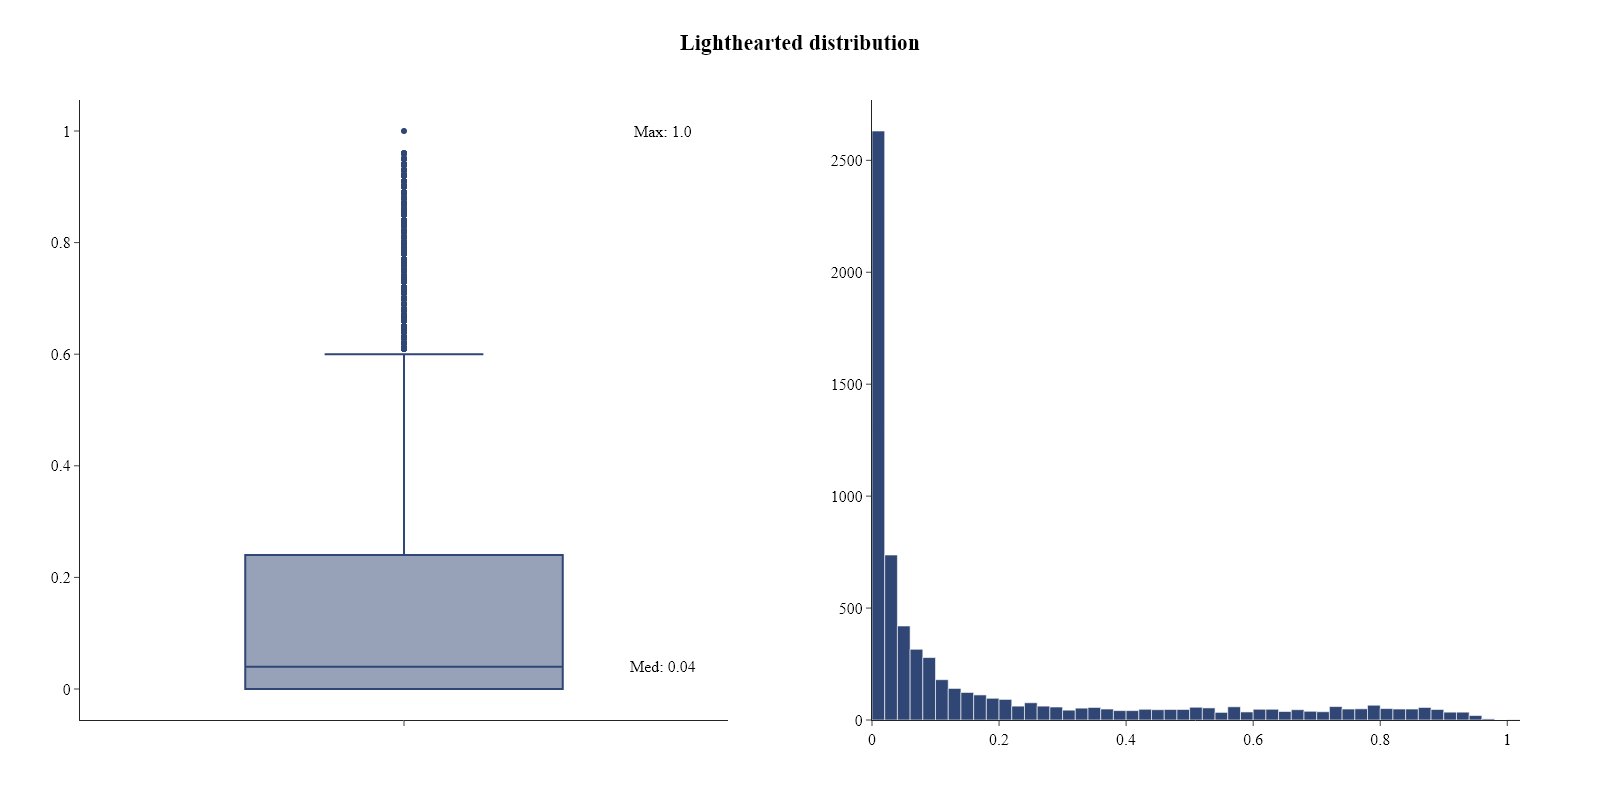

In [37]:
plots.histogram_and_box_plot(data["lighthearted"], name="lighthearted", annotation=["Med","Max"])

$\text{Podobnie jak w przypadku moodu funny, lightearted ma rozkład prawostronnie skośny.}$

### emotional

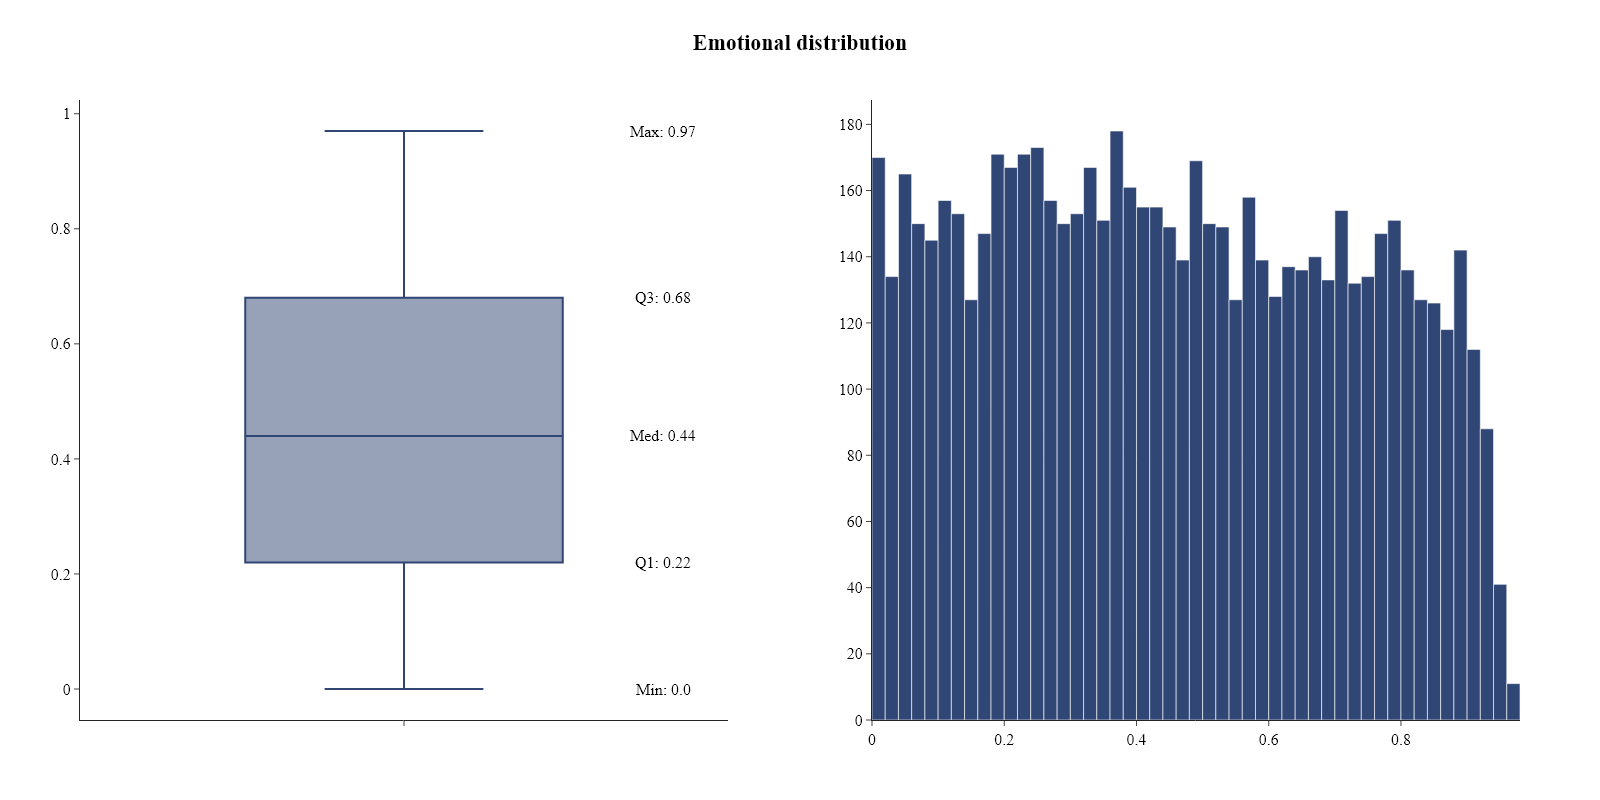

In [38]:
plots.histogram_and_box_plot(data["emotional"], name="emotional")

$\text{Mood emotional ma rozkład zbliżony do rozkładu jednostajnego, lekkie załamanie występuje po prawej stronie rozkładu.}$

### hopeful

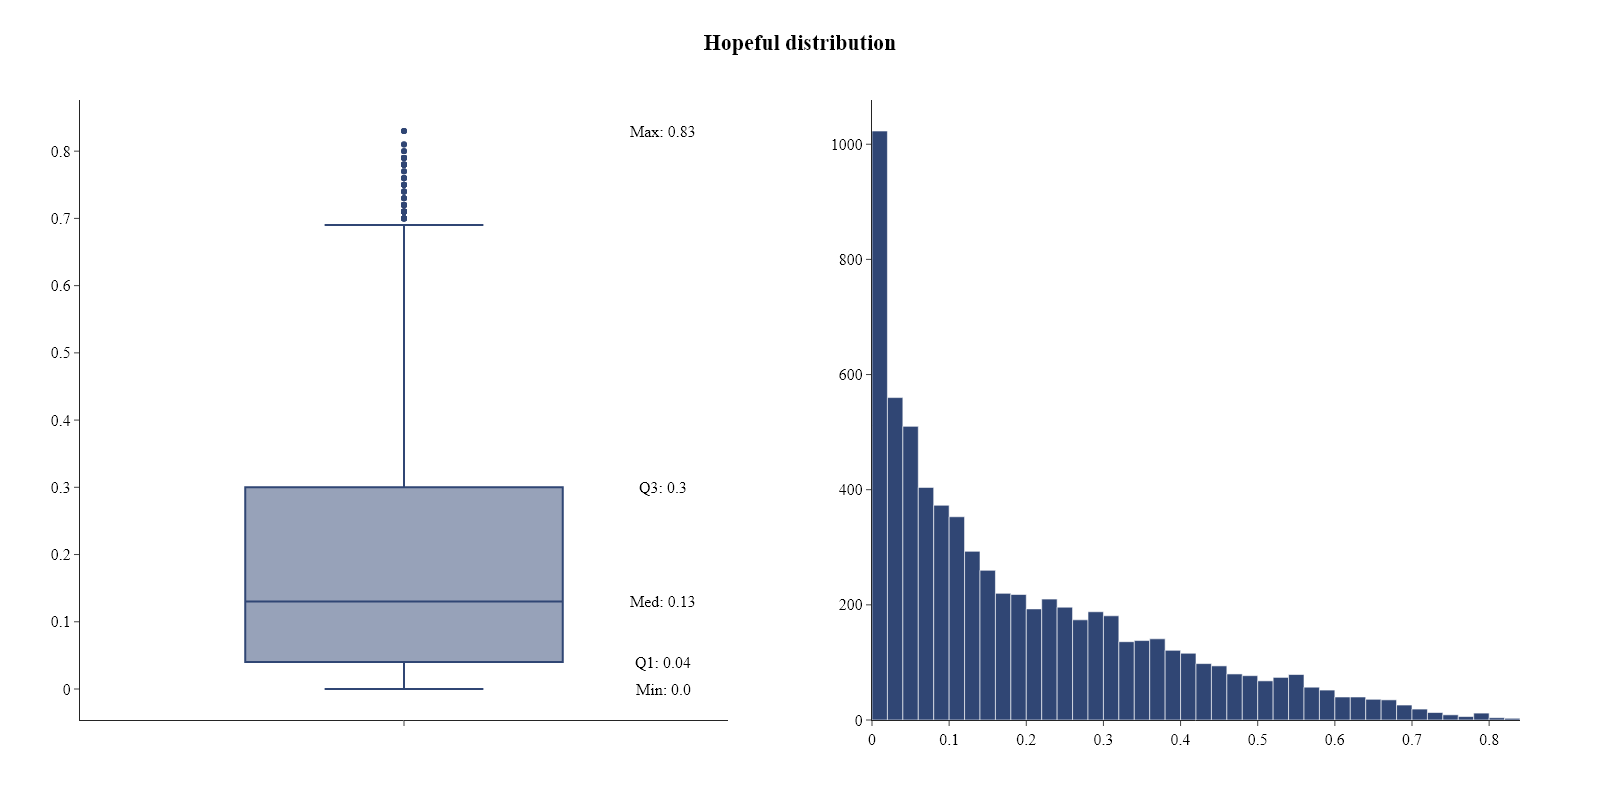

In [39]:
plots.histogram_and_box_plot(data["hopeful"], name="hopeful")

$\text{Dla moodu hopeful średnia jest większa od mediany, co wskazuje na prawostronnie skośny rozkład.}$

### inspiring

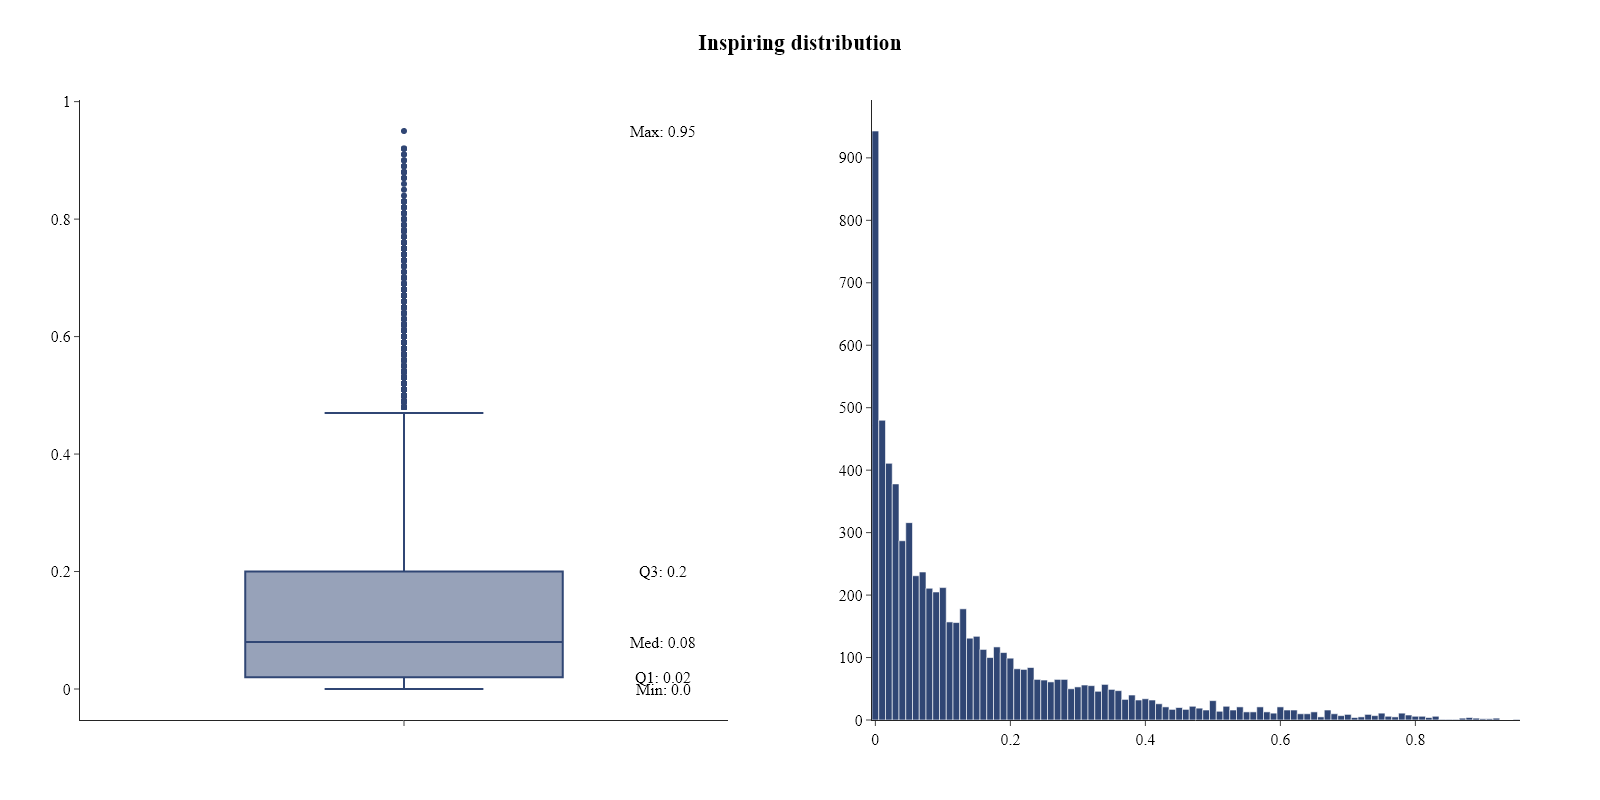

In [40]:
plots.histogram_and_box_plot(data["inspiring"], name="inspiring")

$\text{Inspiring ma rozkład prawostronnie skośny.}$

### relaxing

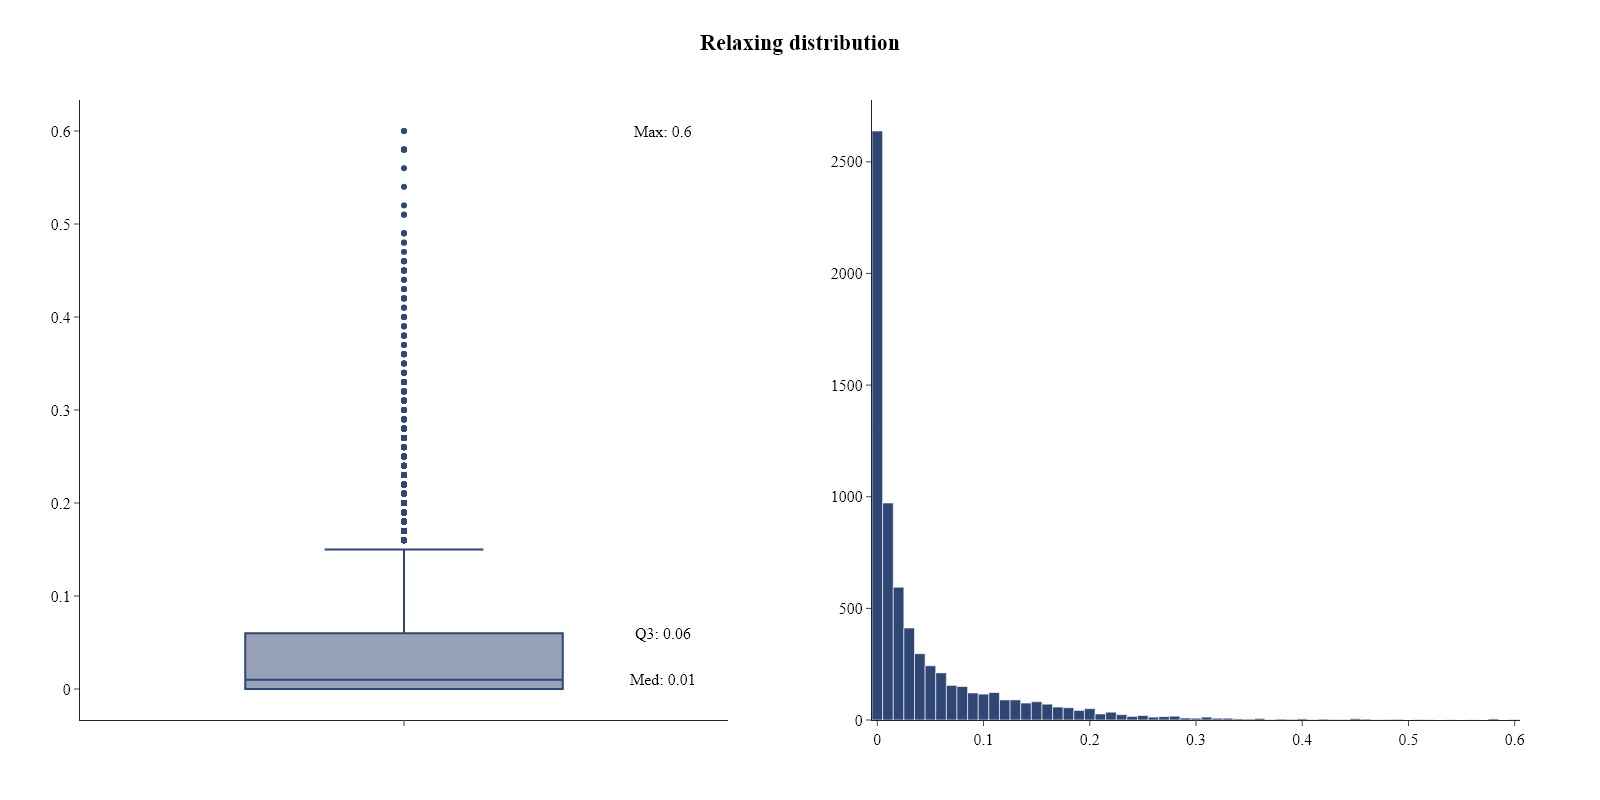

In [41]:
plots.histogram_and_box_plot(data["relaxing"], name="relaxing", annotation=["Med","Q3", "Max"])

$\text{Dla niewielkiej liczby książek mood relaxing przyjmuje wartości większe od 0.2.}$

### tense

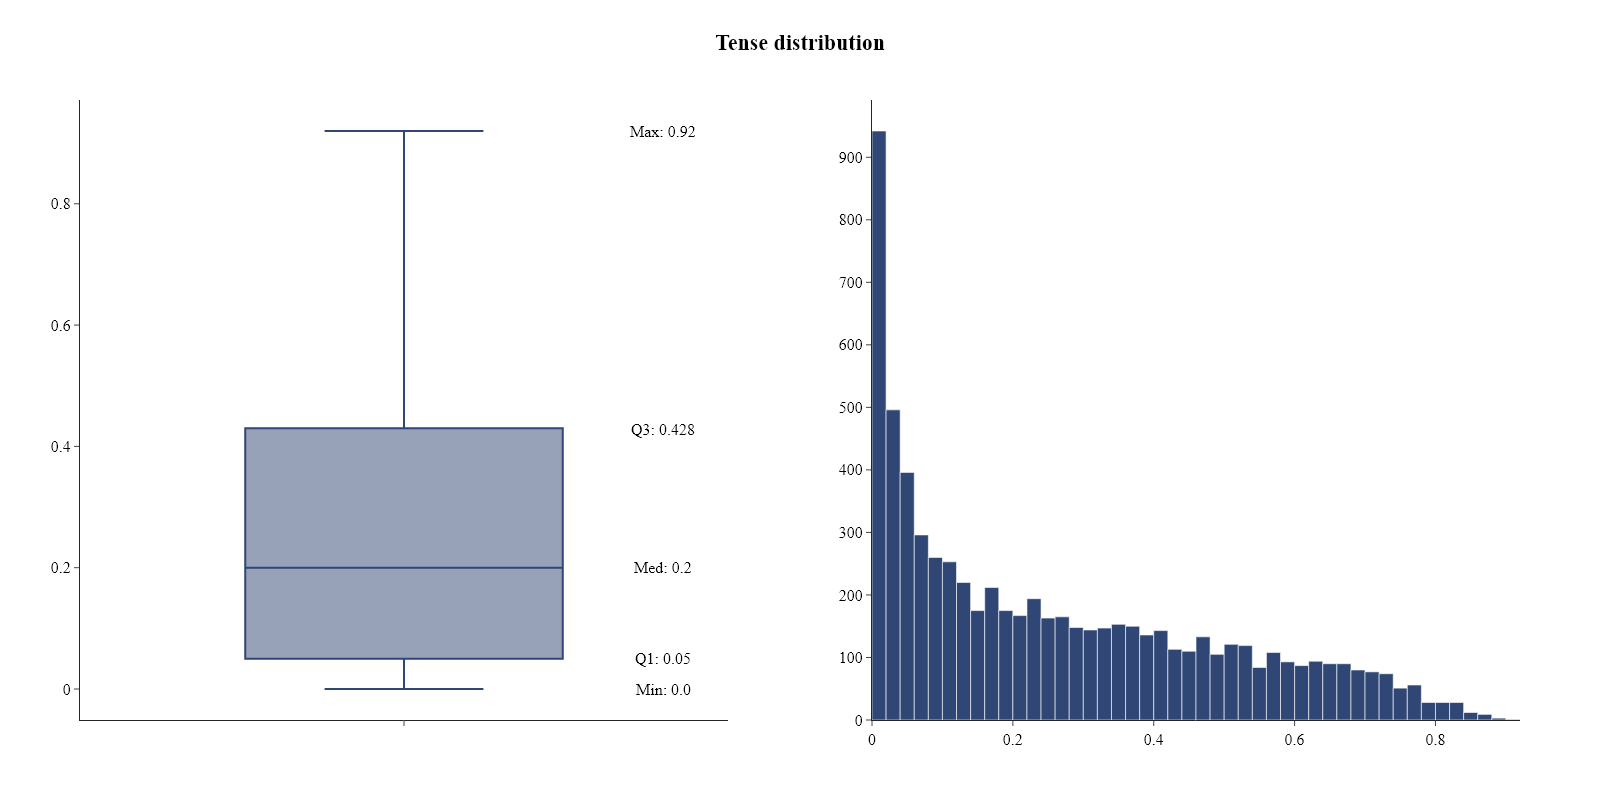

In [42]:
plots.histogram_and_box_plot(data["tense"], name="tense")

$\text{Rozkład moodu tense jest prawostronnie skośny.}$

### sad

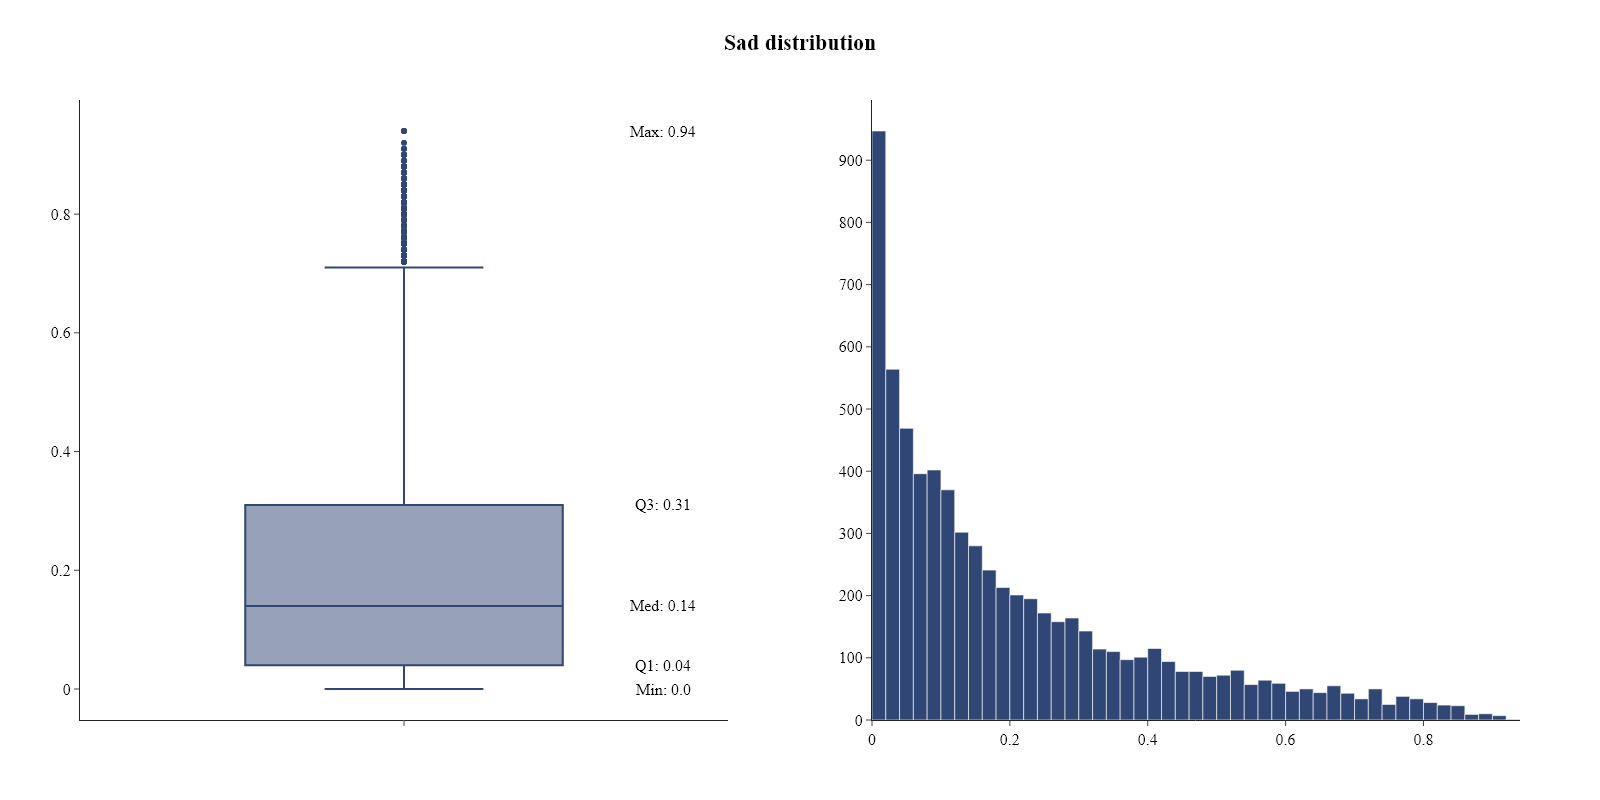

In [43]:
plots.histogram_and_box_plot(data["sad"], name="sad")

$\text{Sad jest rozkładem prawostronnie skośnym.}$

### reflective

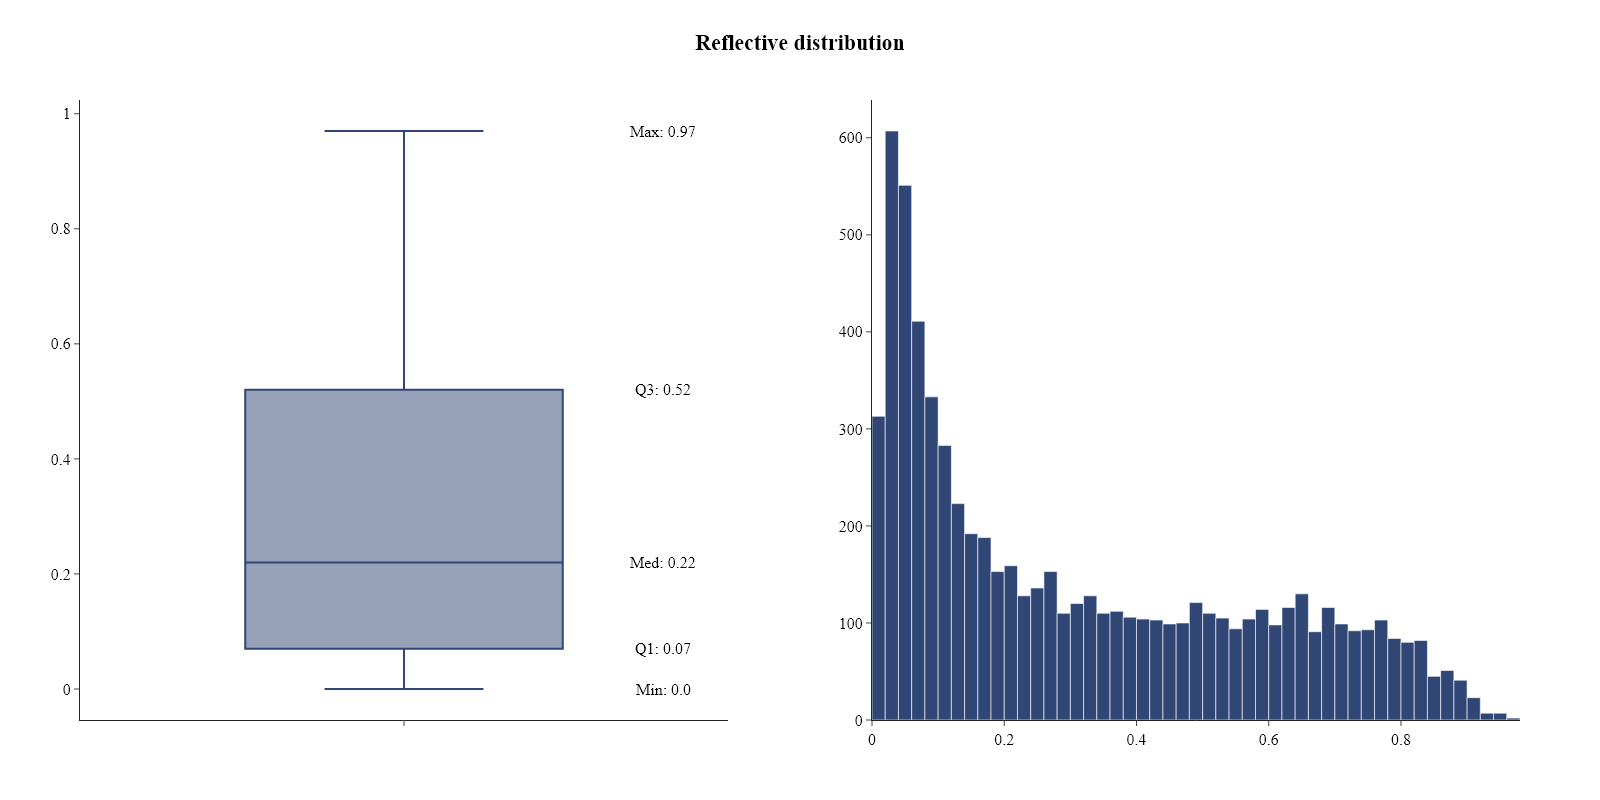

In [44]:
plots.histogram_and_box_plot(data["reflective"], name="reflective")

$\text{W odróżnieniu od większości moodów, w przypadku reflective nieco bardziej liczne są przedziały o wartościach większych od 0.}$

### adventurous

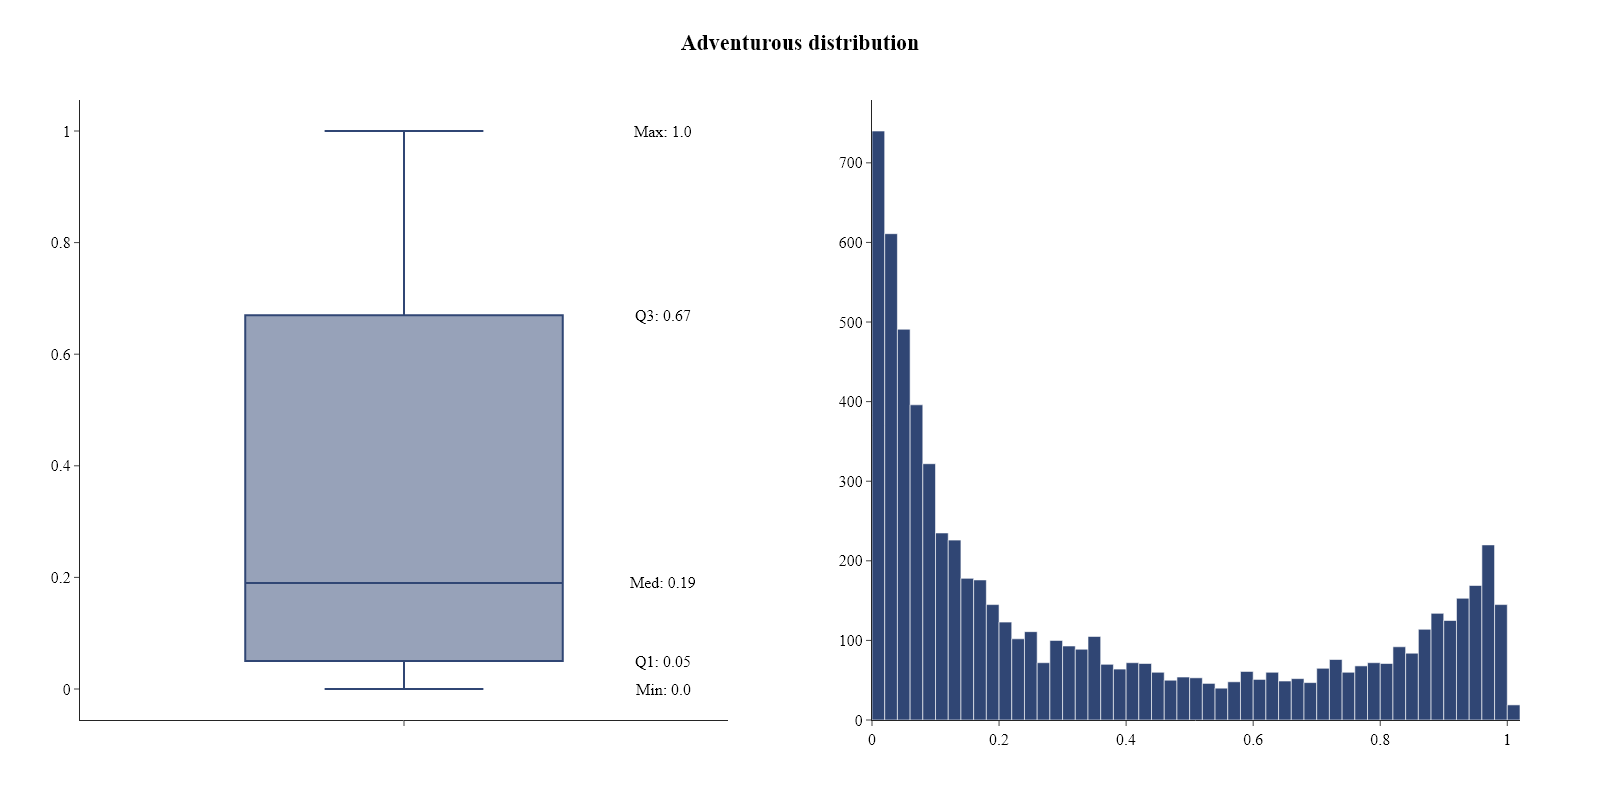

In [45]:
plots.histogram_and_box_plot(data["adventurous"], name="adventurous")

$\text{Wgłębienie w okolicach wartości 0.5 sygnalizuje, że adventorous przyjmuje prezeważnie wartości skrajne.}$

### challenging

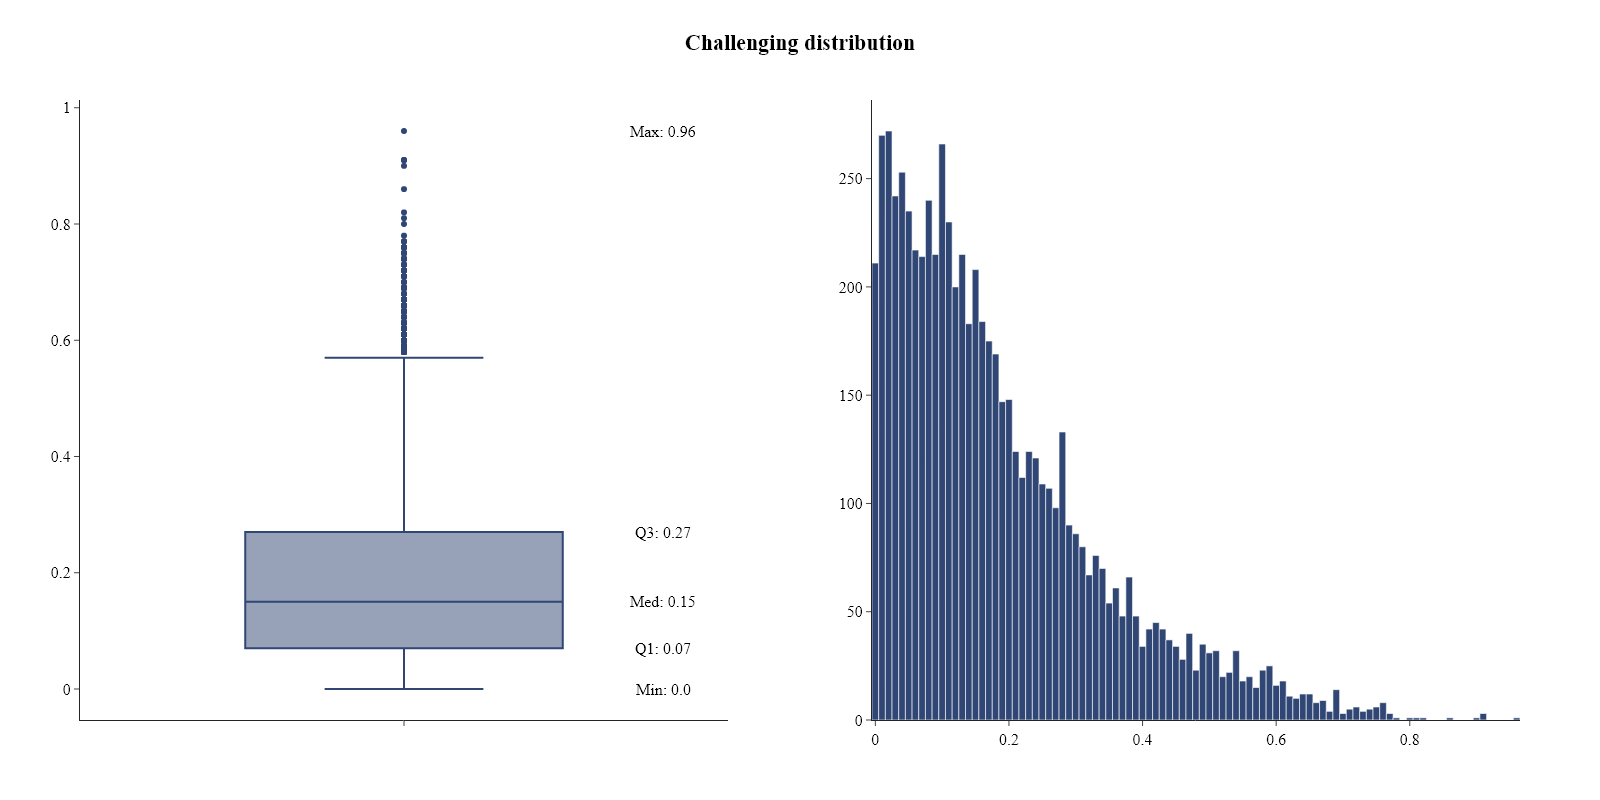

In [46]:
plots.histogram_and_box_plot(data["challenging"], name="challenging")

$\text{Bardzo niewielka liczba książek ma mood challenging większy od 0.8.}$

### informative

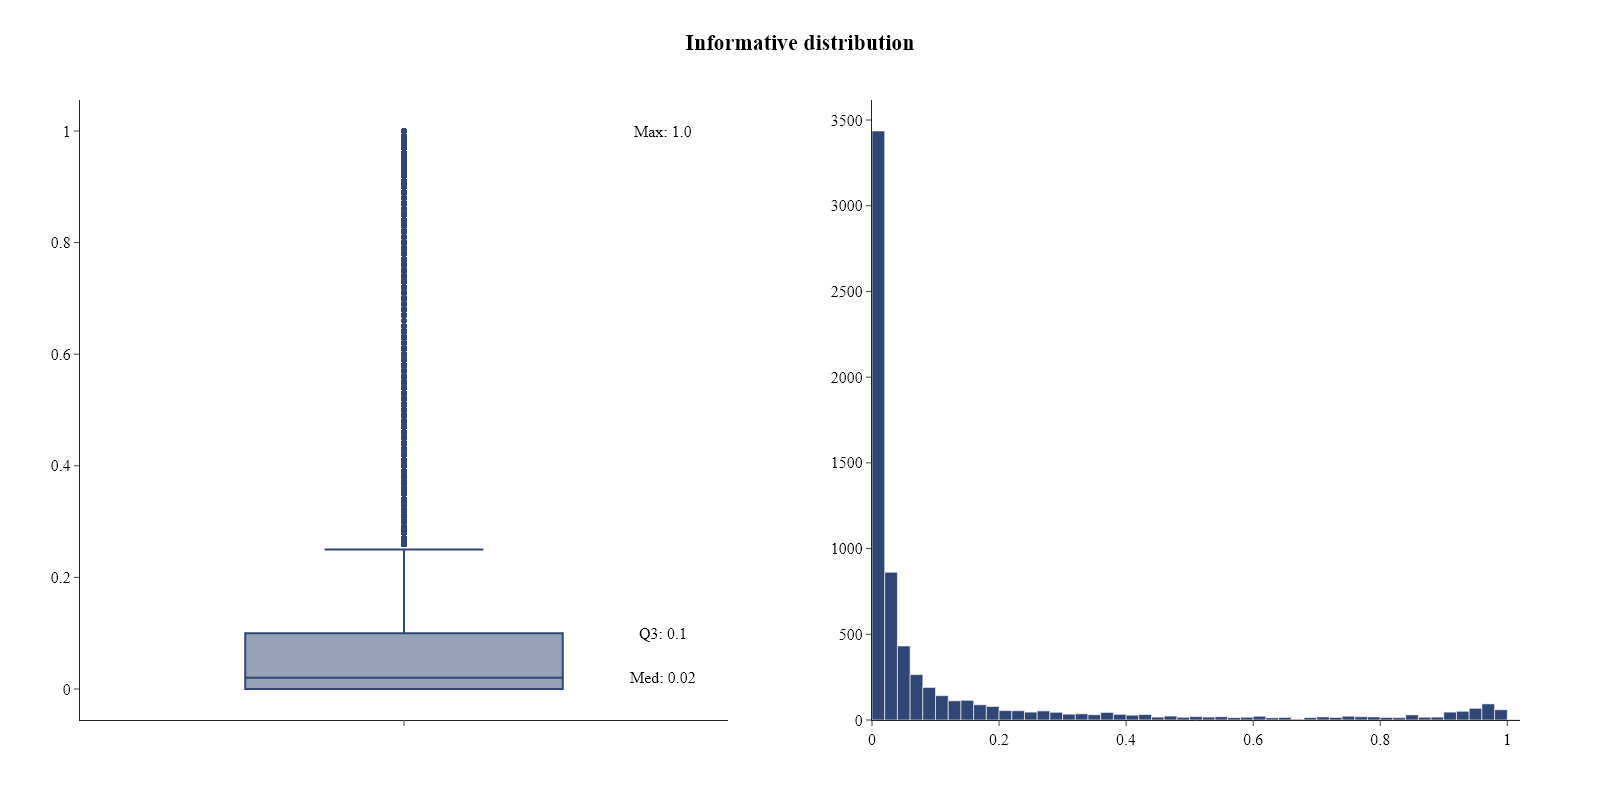

In [47]:
plots.histogram_and_box_plot(data["informative"], name="informative", annotation=["Med","Q3", "Max"])

$\text{Niemal połowa obserwacji zbioru danych dla zmiennej informative znajduje się w przedziale [0, 0.01].}$

### mysterious

In [48]:
plots.histogram_and_box_plot(data["mysterious"], name="mysterious", annotation=["Min", "Med", "Max"])

$\text{Pomijając skrajne wartości znajdujące się przy minimum, mood mysterious ma rozkład zbliżony do rozkładu jednostajnego.}$

### dark

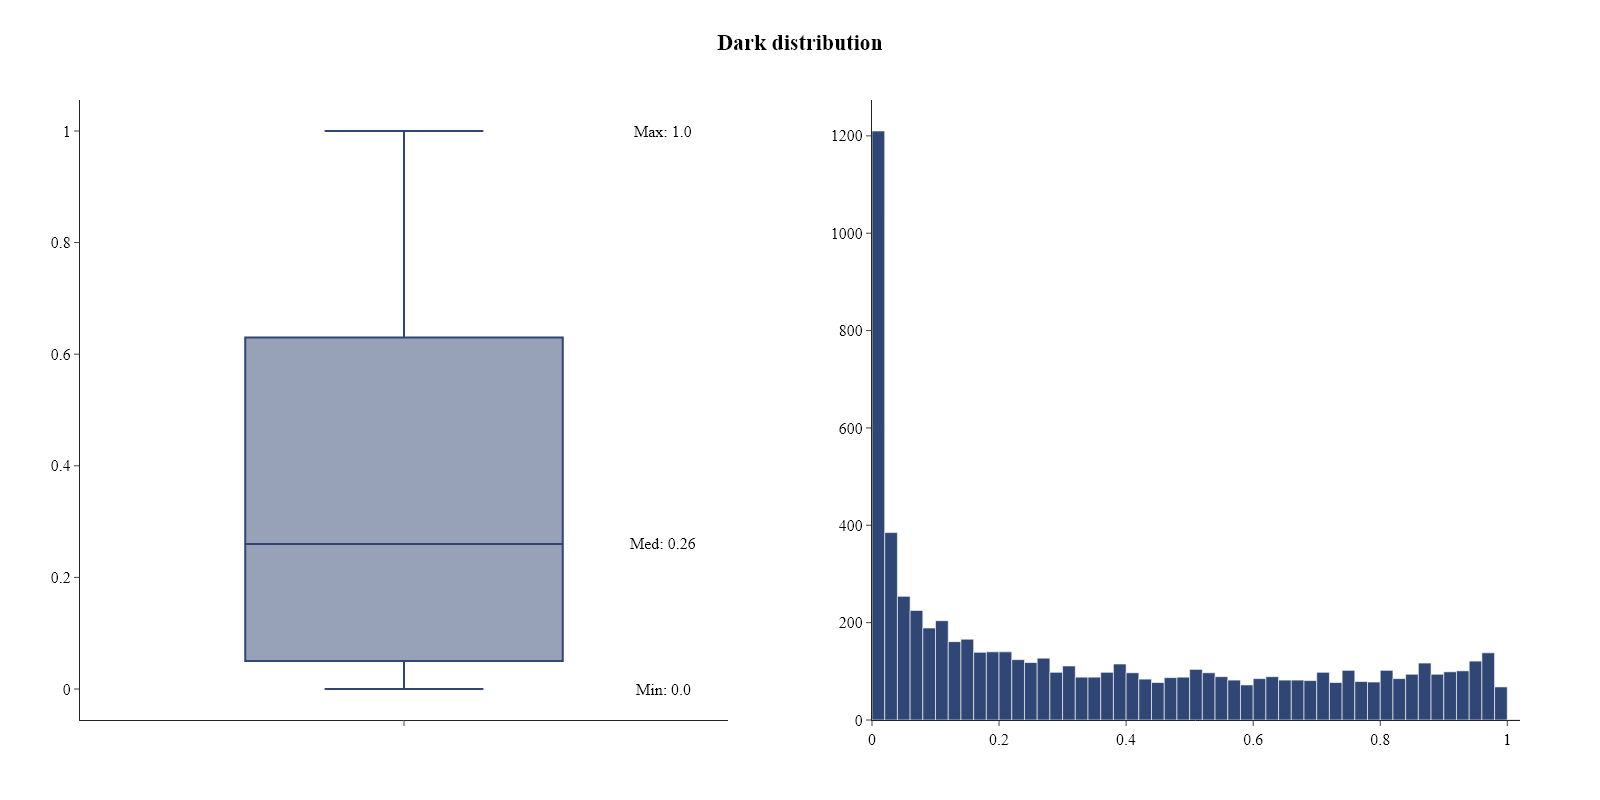

In [49]:
plots.histogram_and_box_plot(data["dark"], name="dark", annotation=["Min", "Med", "Max"])

$\text{Podobnie jak w przypadku moodu mysterious, dark ma rozkład zbliżony do rozkładu jednostajnego.}$

## Rozkład zmiennej celu w zależności od zmiennych kategorycznych

$\text{W poniższej sekcji przedstawiono rozkład zmiennej celu w zależności od wartości zmiennych kategorycznych.}$<p>
$\text{Po przedstawieniu wszystkich wykresów zapiszemy kilka wniosków.}$

### series

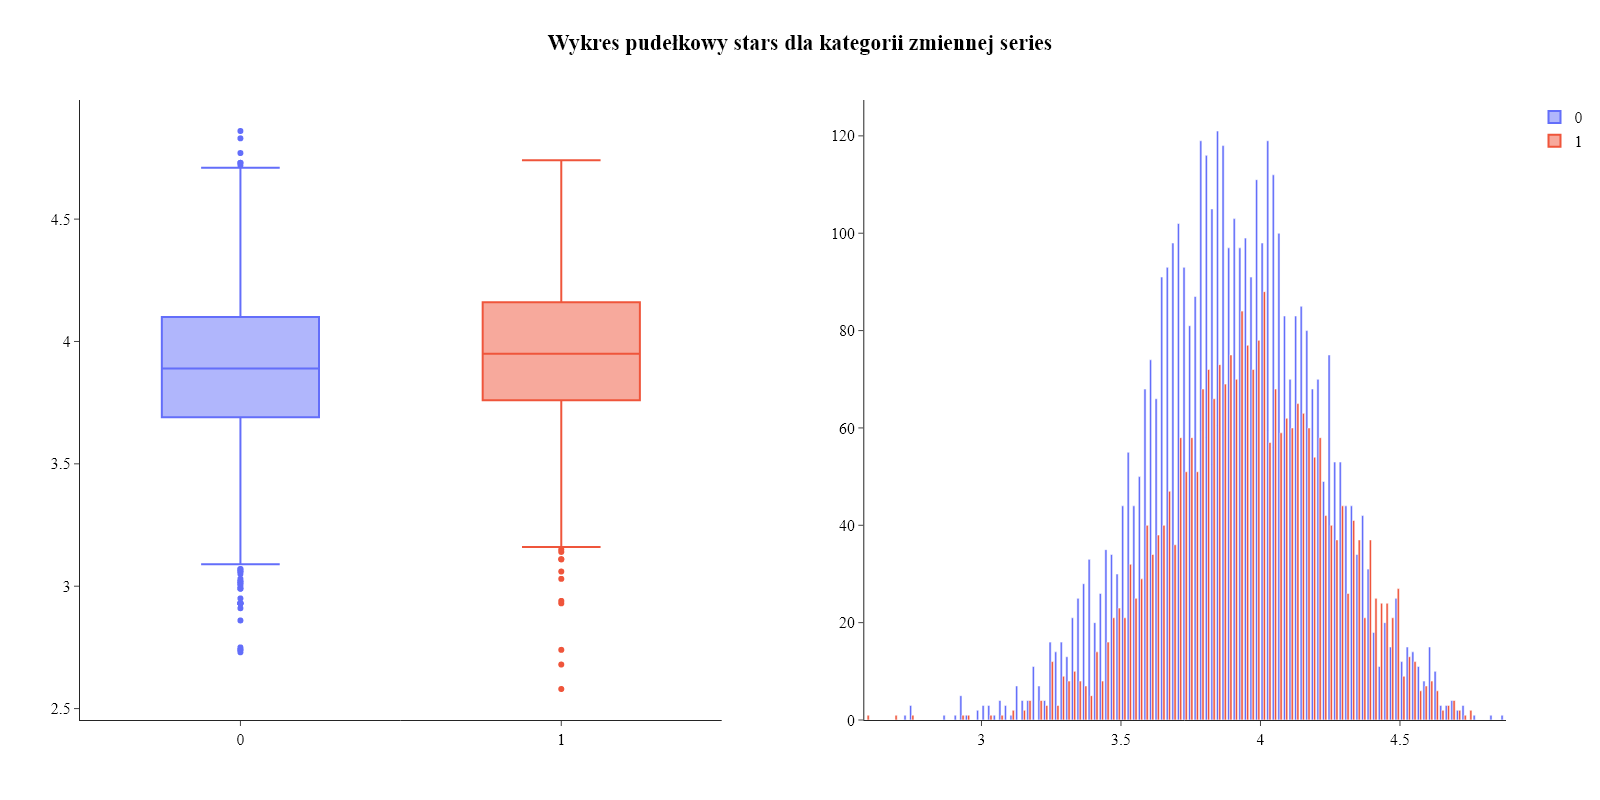

In [50]:
plots.boxplot_by_categorical(data, categorical="series", target=target)

### Literature and Art

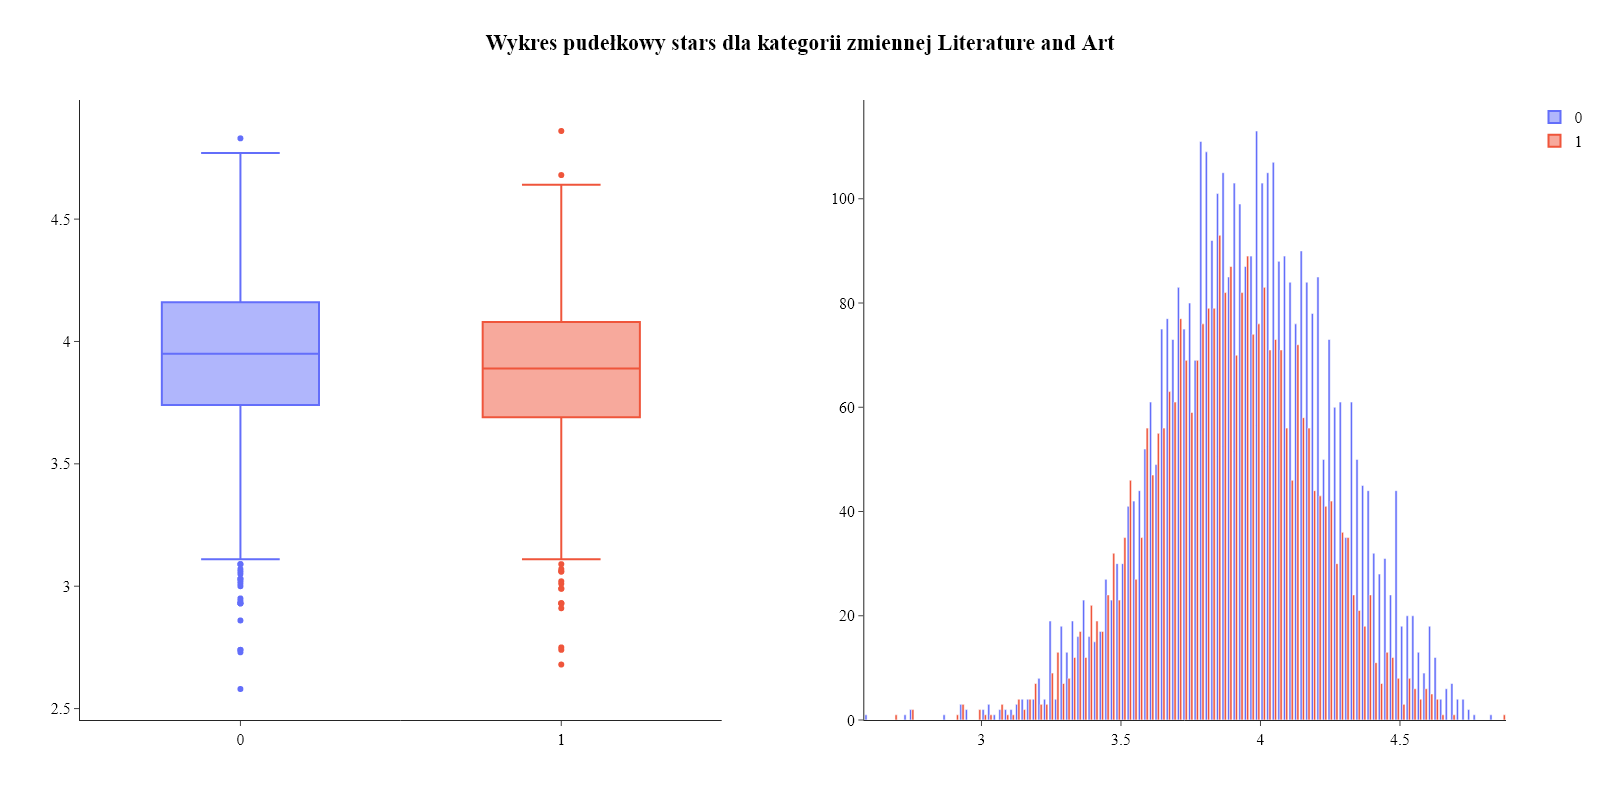

In [51]:
plots.boxplot_by_categorical(data, categorical="Literature and Art", target=target)

### Fiction

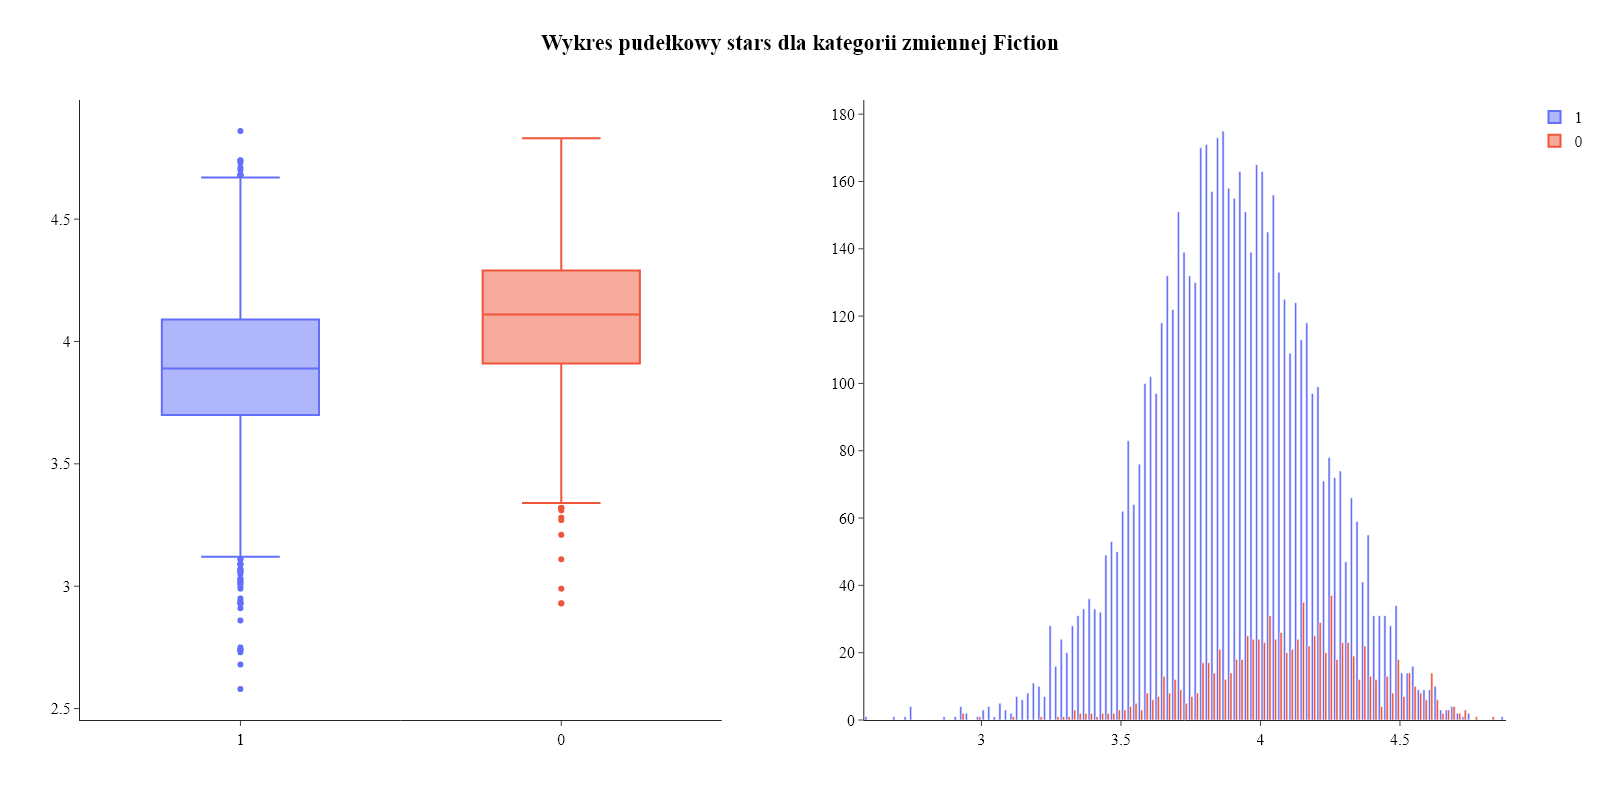

In [52]:
plots.boxplot_by_categorical(data, categorical="Fiction", target=target)

### Science

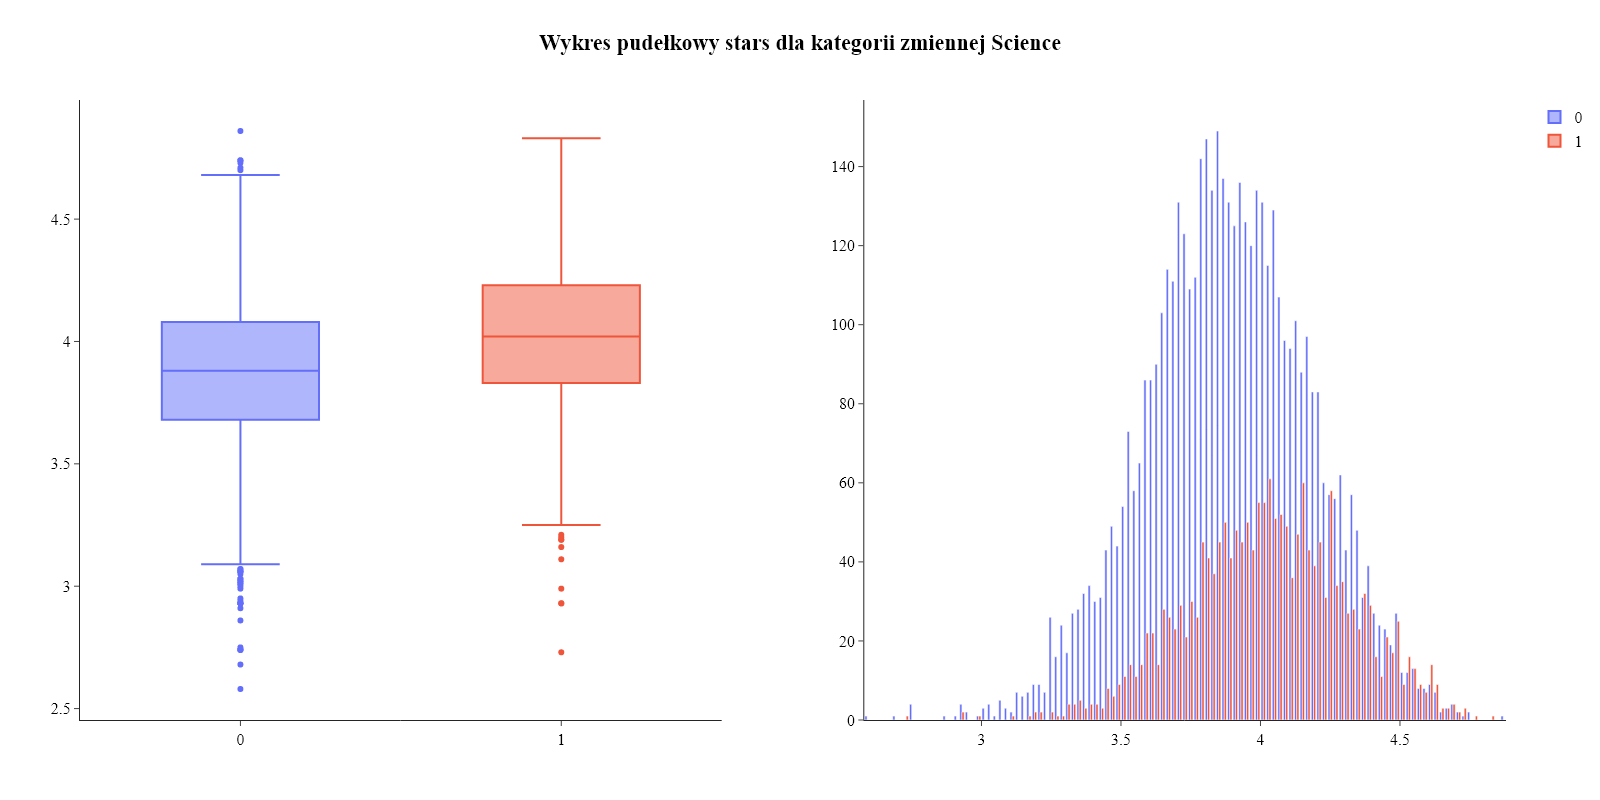

In [53]:
plots.boxplot_by_categorical(data, categorical="Science", target=target)

### Crime

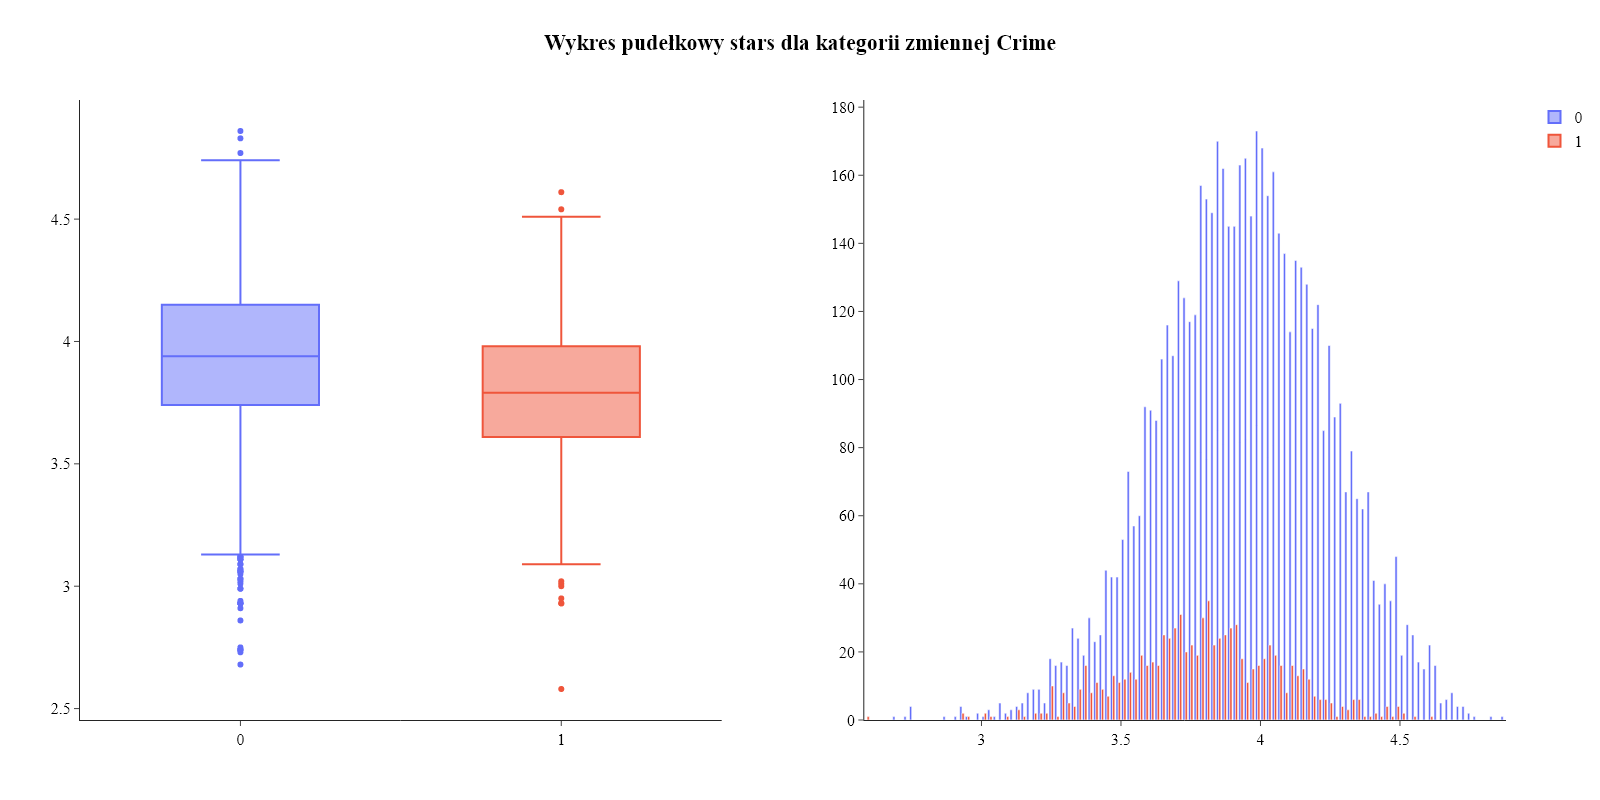

In [54]:
plots.boxplot_by_categorical(data, categorical="Crime", target=target)

### Psychology

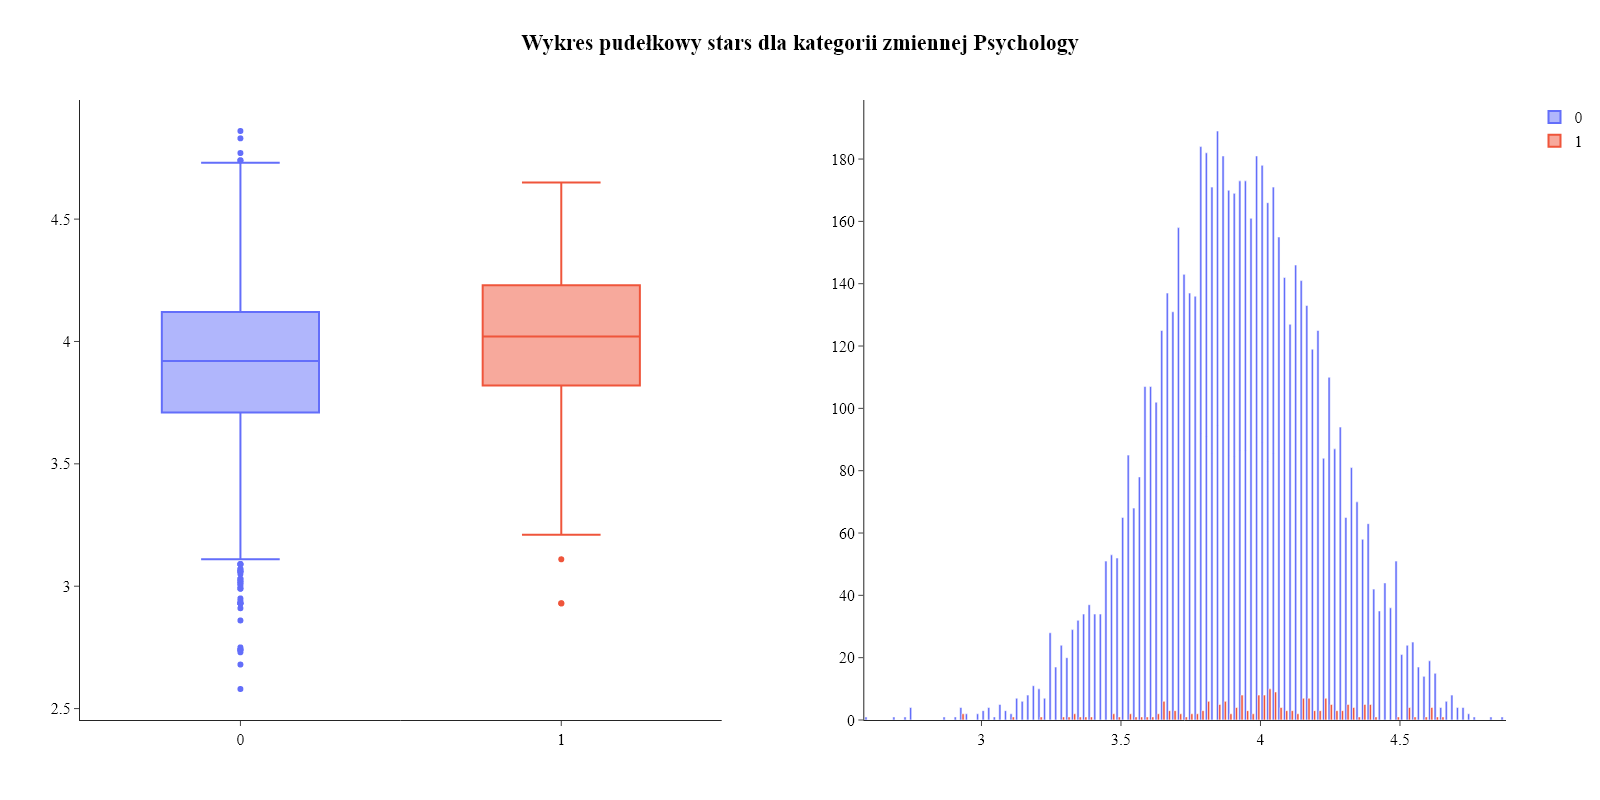

In [55]:
plots.boxplot_by_categorical(data, categorical="Psychology", target=target)

### Social

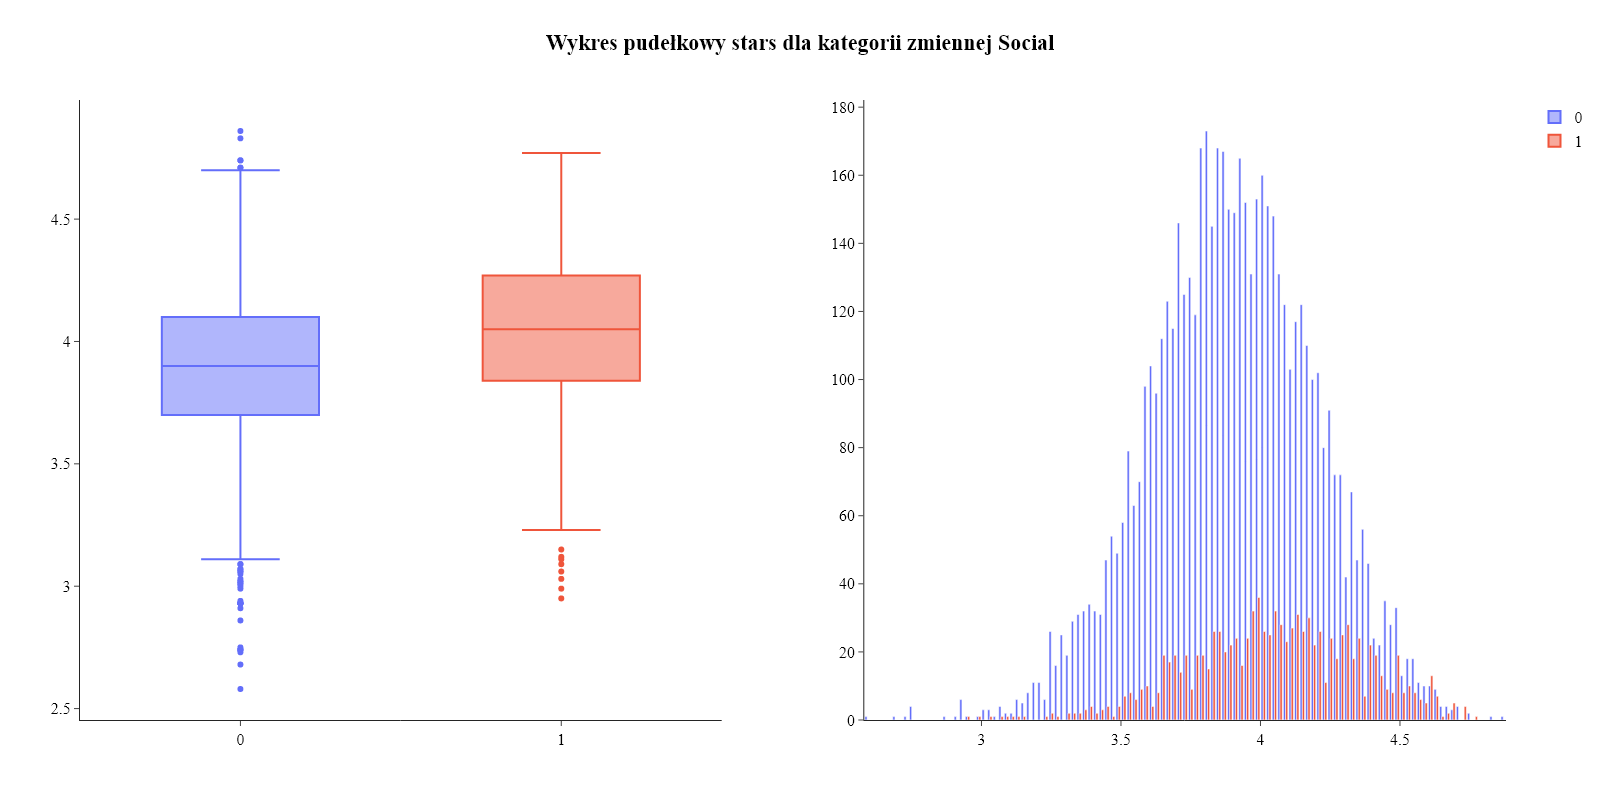

In [56]:
plots.boxplot_by_categorical(data, categorical="Social", target=target)

### Children

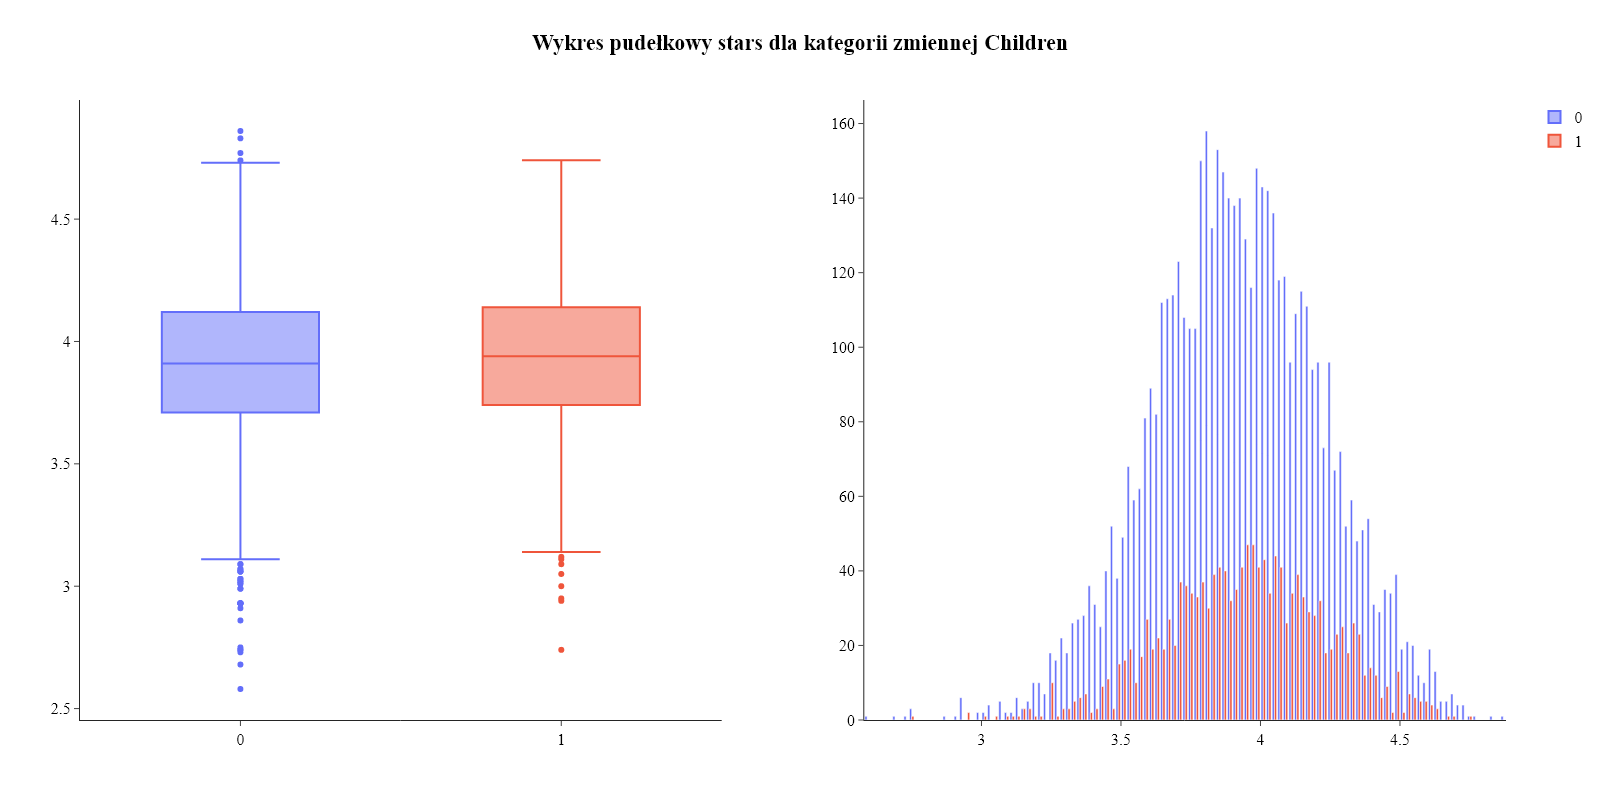

In [57]:
plots.boxplot_by_categorical(data, categorical="Children", target=target)

### Romans

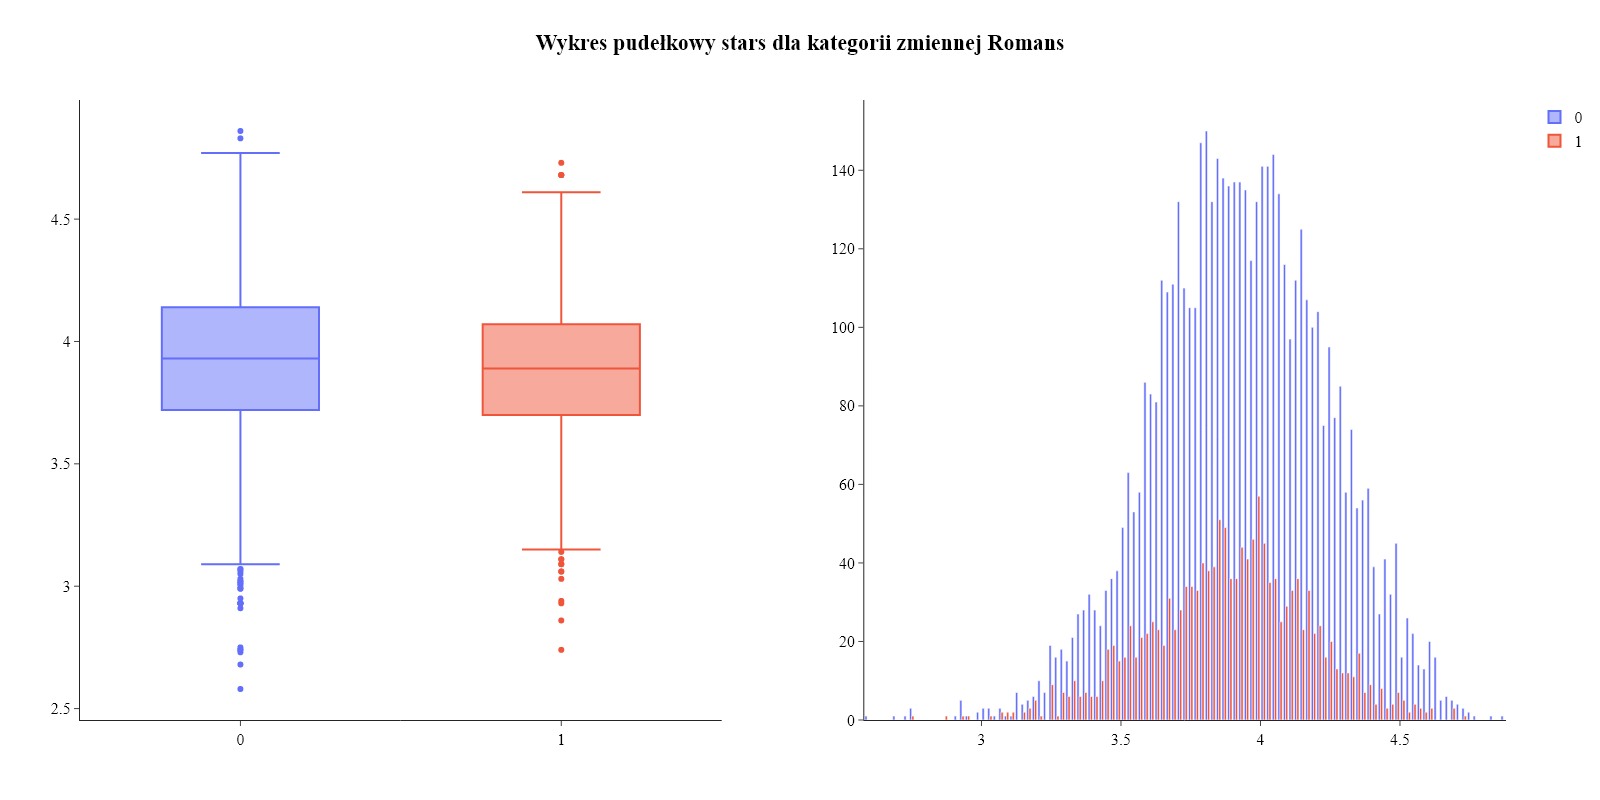

In [58]:
plots.boxplot_by_categorical(data, categorical="Romans", target=target)

### Biography

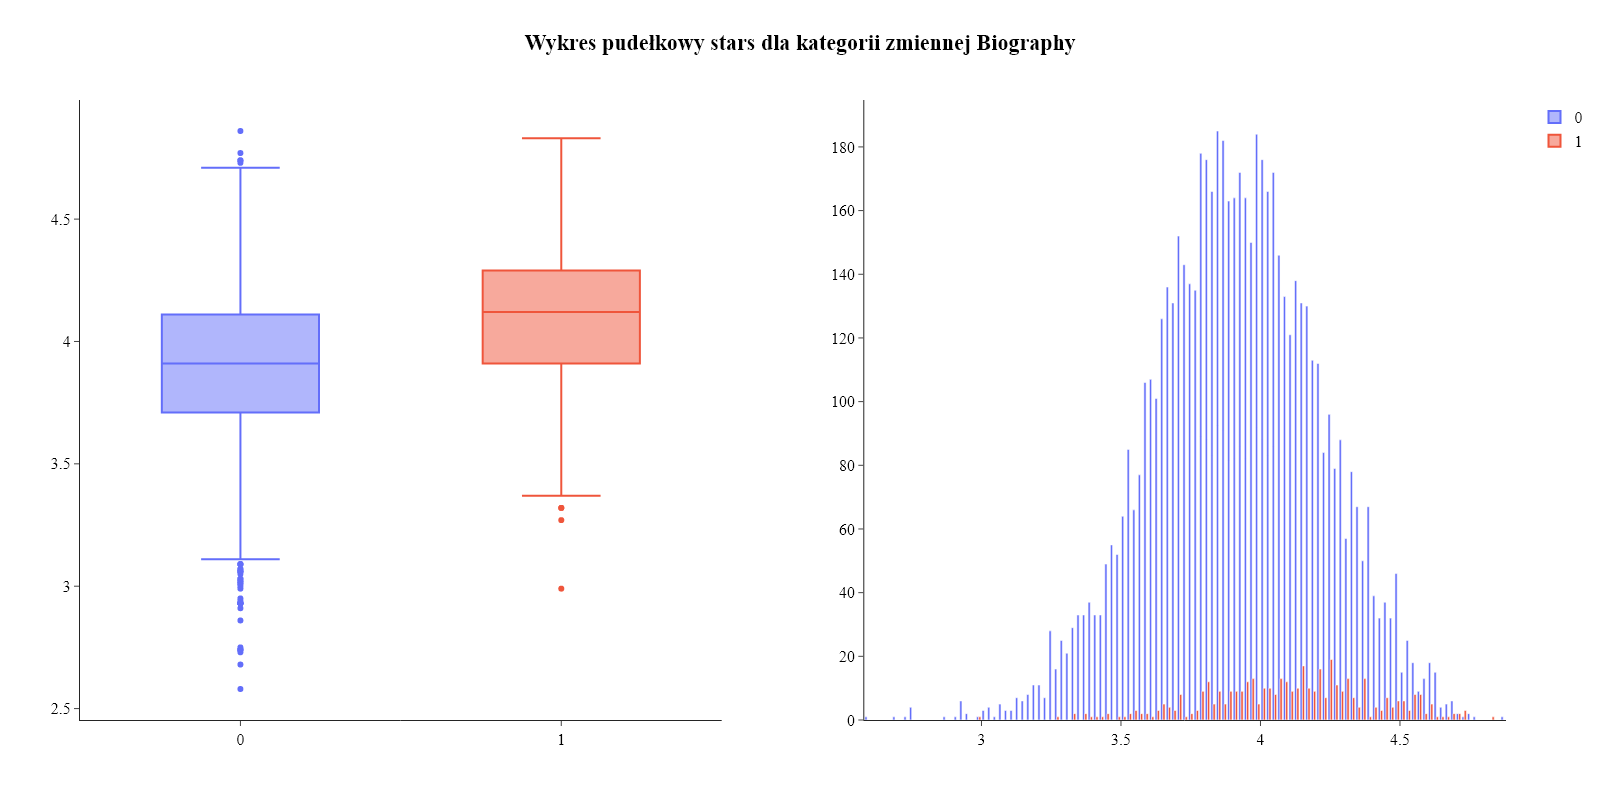

In [59]:
plots.boxplot_by_categorical(data, categorical="Biography", target=target)

### Entertainment

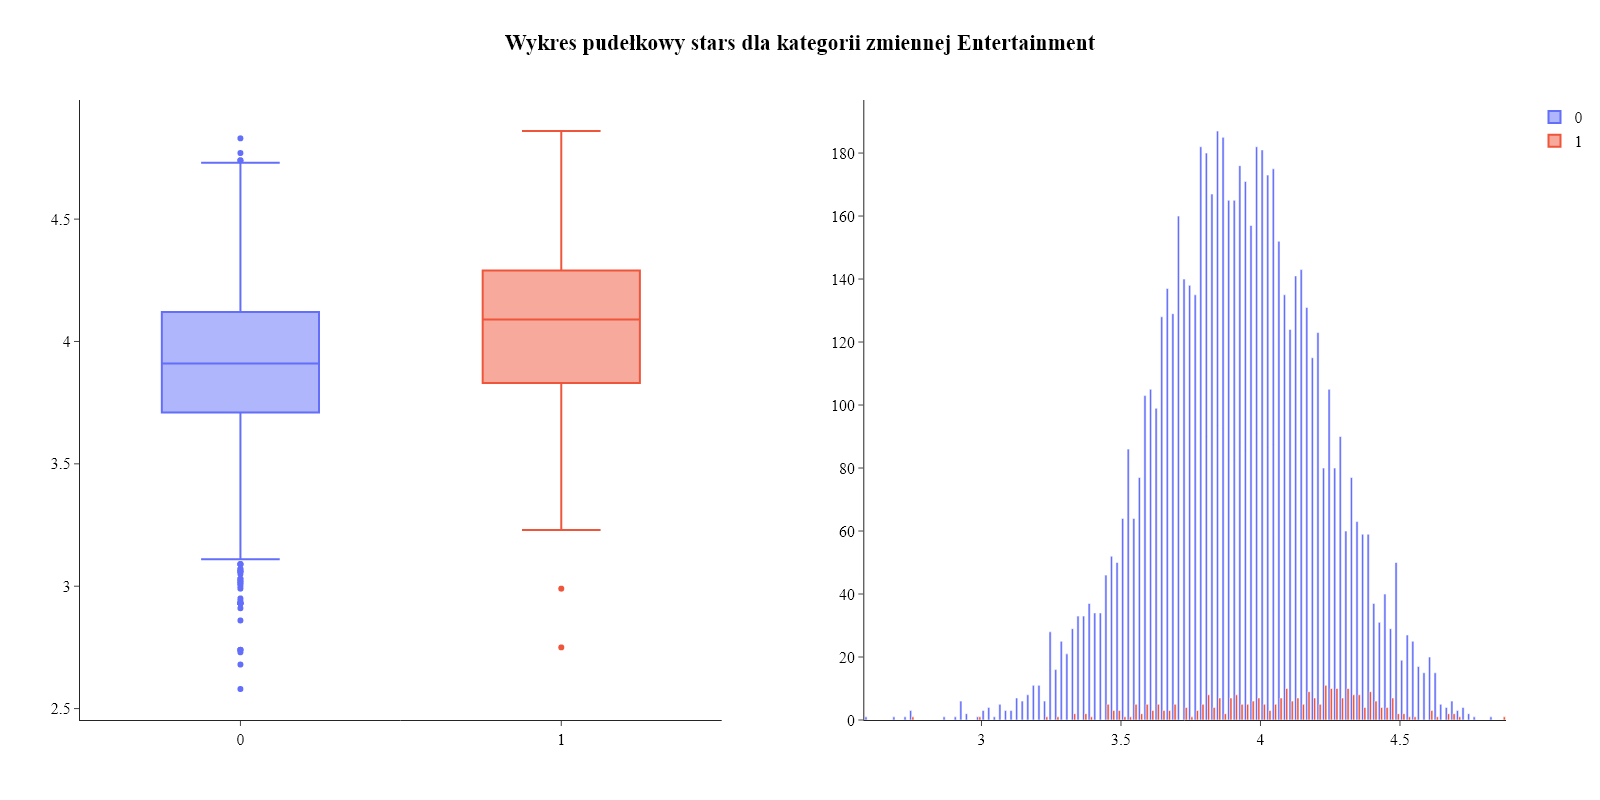

In [60]:
plots.boxplot_by_categorical(data, categorical="Entertainment", target=target)

$\text{Wnioski:}$<p>
$\text{1. W większości przypadków rozkład zmiennej celu nie różni się znacząco w zależności od wartości zmiennej kategorycznej.}$<p>
$\text{2. W przypadku zmiennych: Fiction, Science, Psychology, Biography oraz Entertainment, mediana oceny książki jest wyższa dla książek z danej kategorii. Jednak warto zaznać, że różnice nie są znaczące.}$

## Rozkład zmiennej celu w zależności od zmiennych ciągłych

$\text{W poniższej sekcji przedstawiono rozkład zmiennej celu w zależności od rozkładu zmiennych ciągłych.}$<p>
$\text{Po przedstawieniu wszystkich wykresów zapiszemy kilka wniosków.}$

### pages

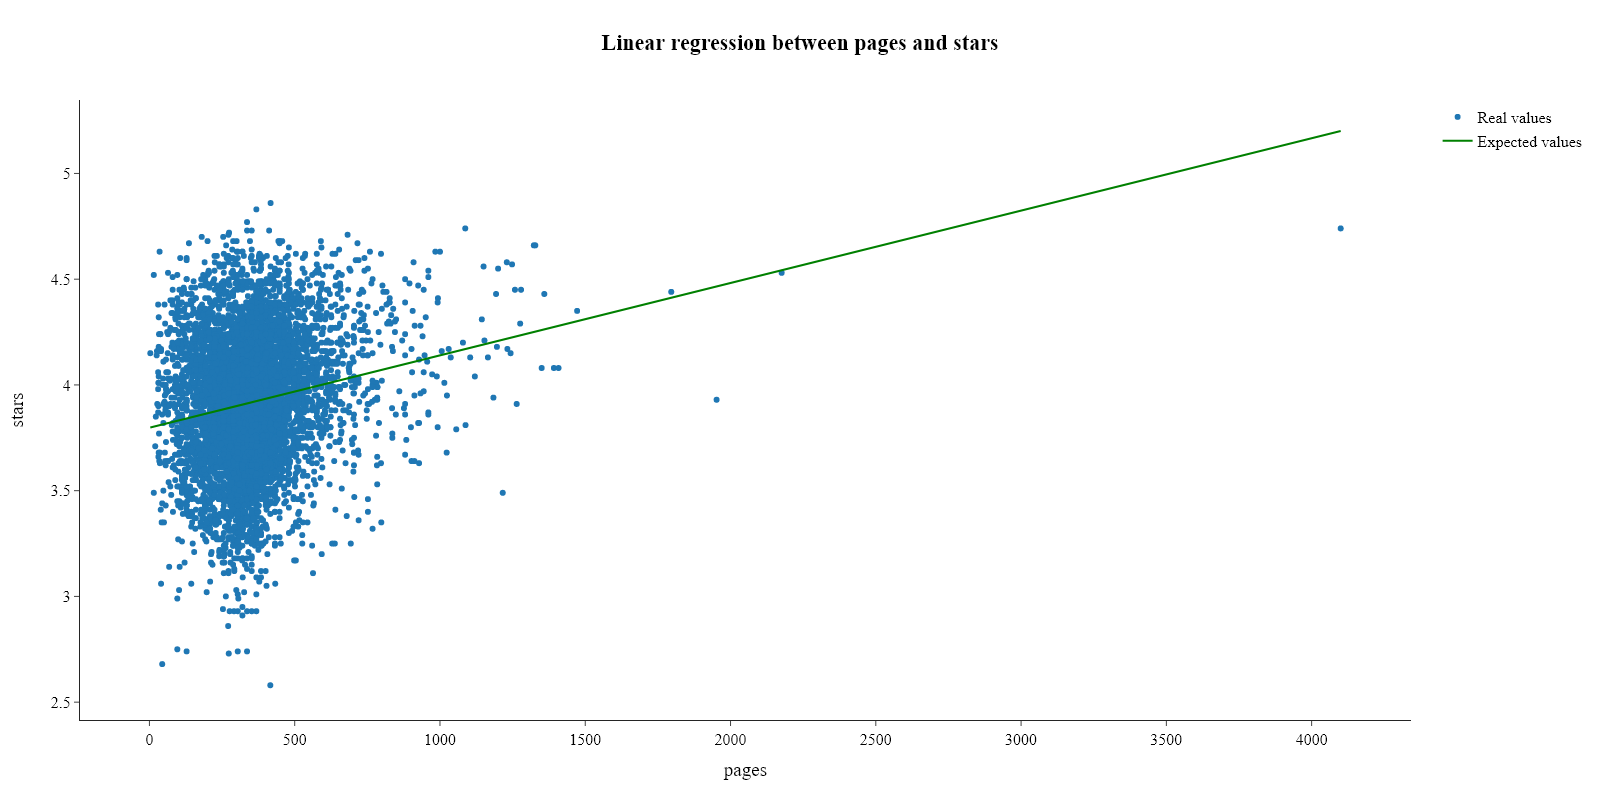

In [61]:
plots.linear_regression_plot(data, feature="pages", target=target)

### reviews

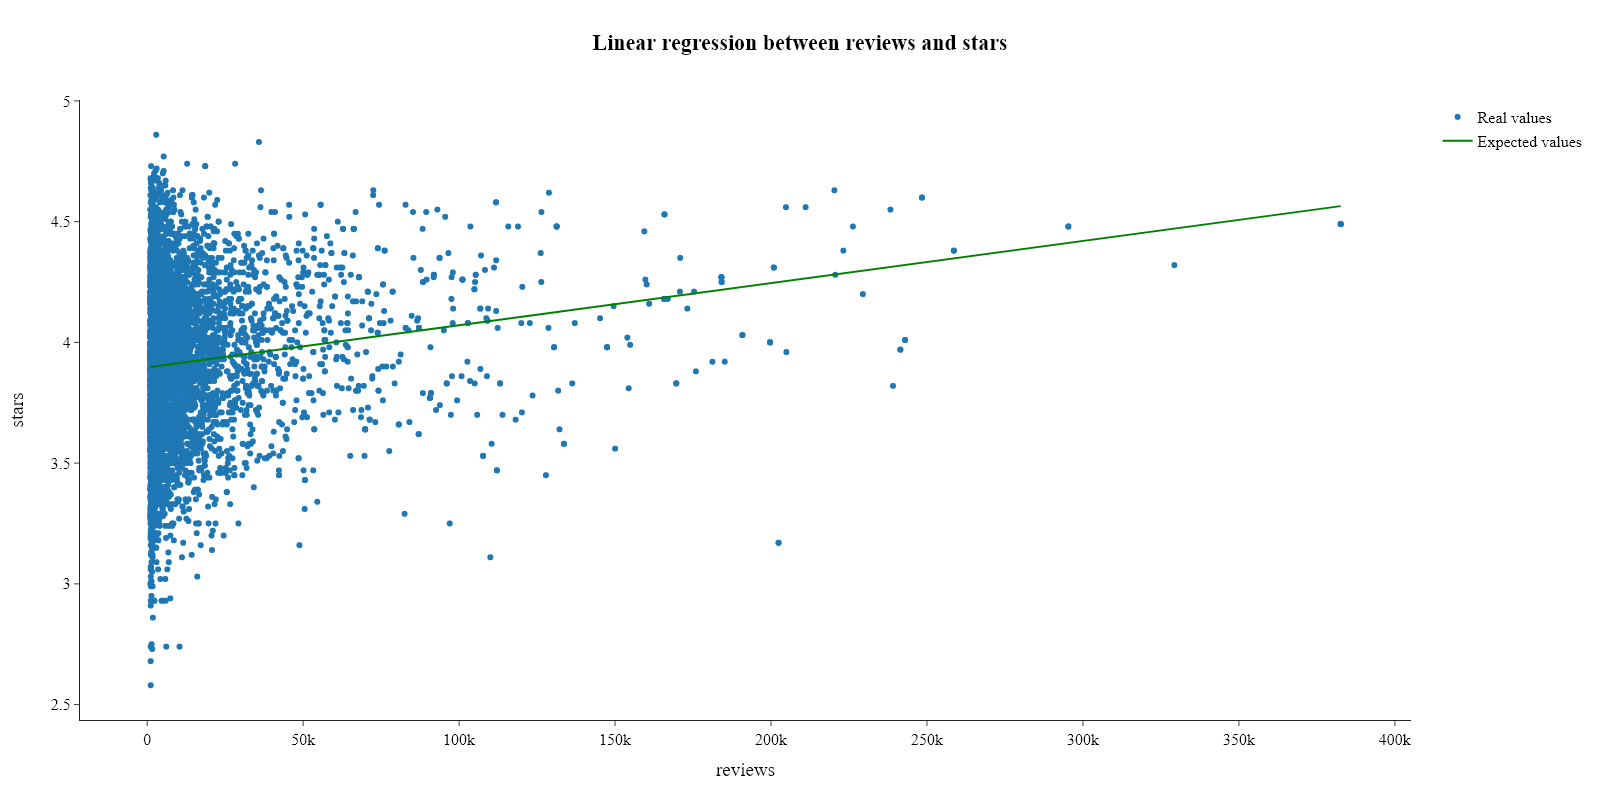

In [62]:
plots.linear_regression_plot(data, feature="reviews", target=target)

### mix

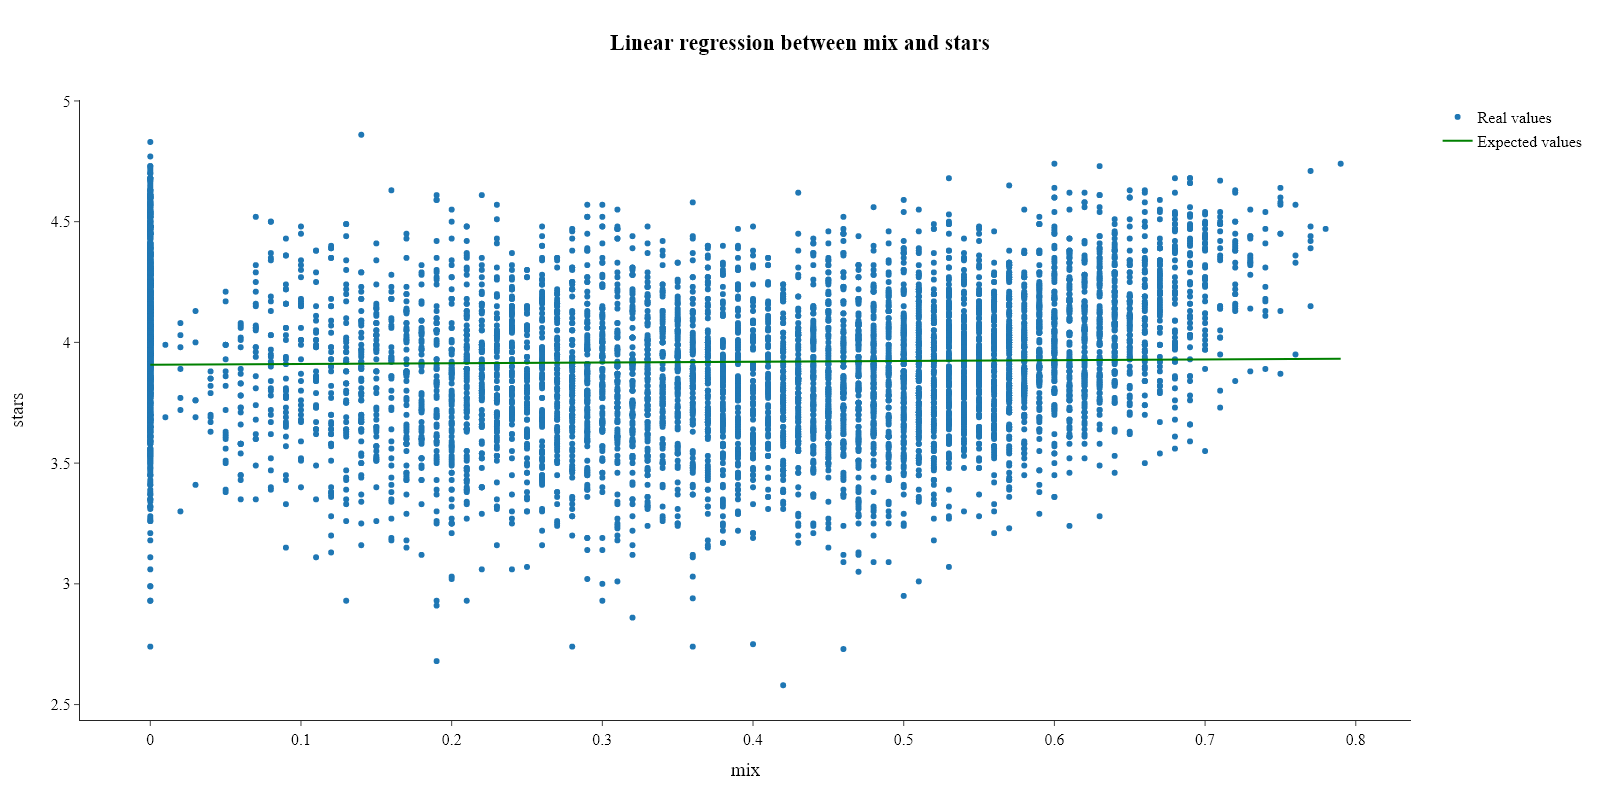

In [63]:
plots.linear_regression_plot(data, feature="mix", target=target)

### character

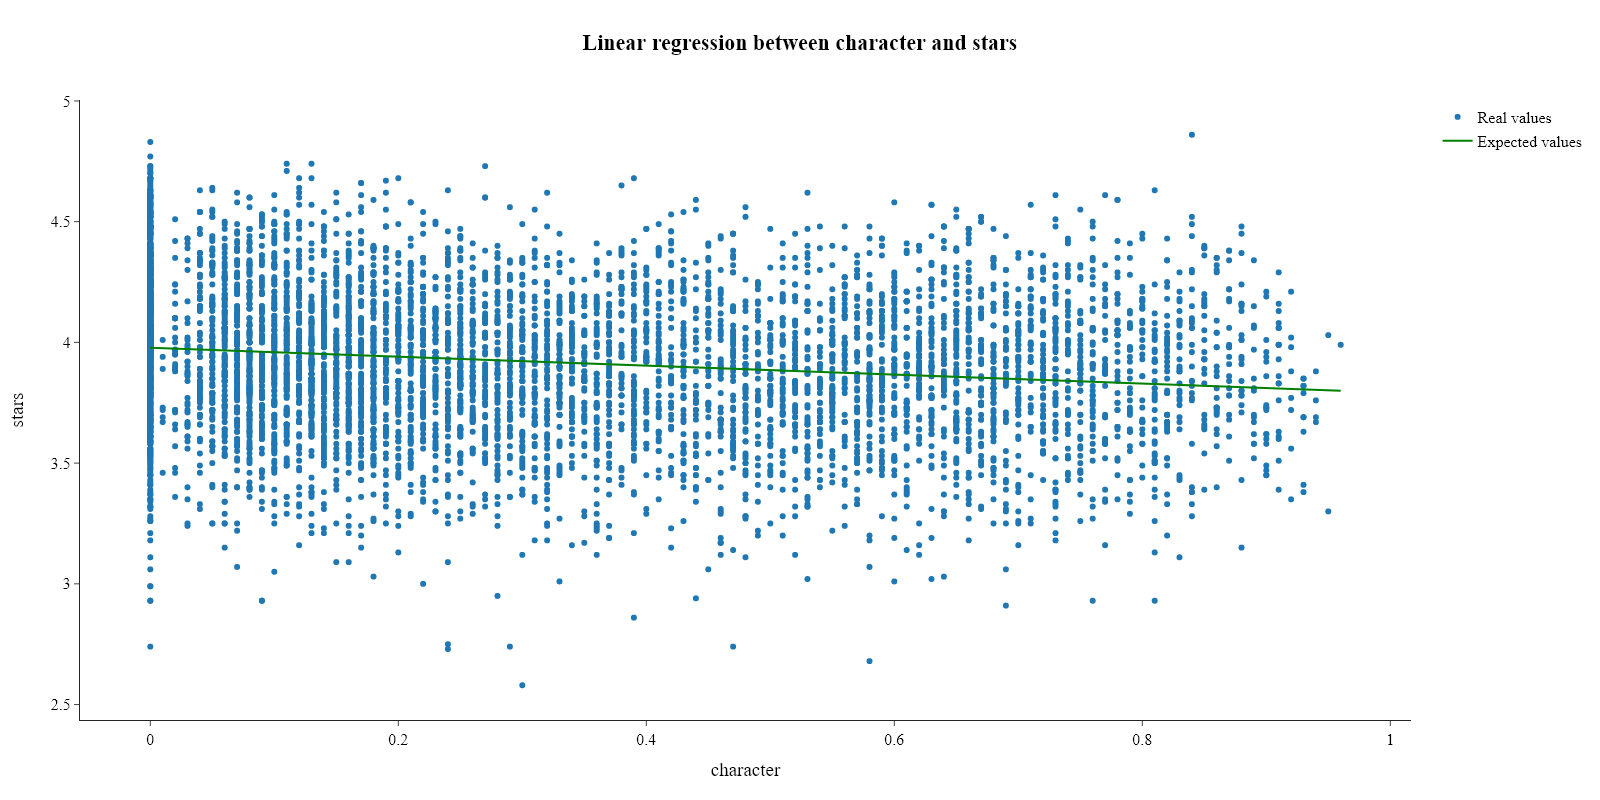

In [64]:
plots.linear_regression_plot(data, feature="character", target=target)

### plot

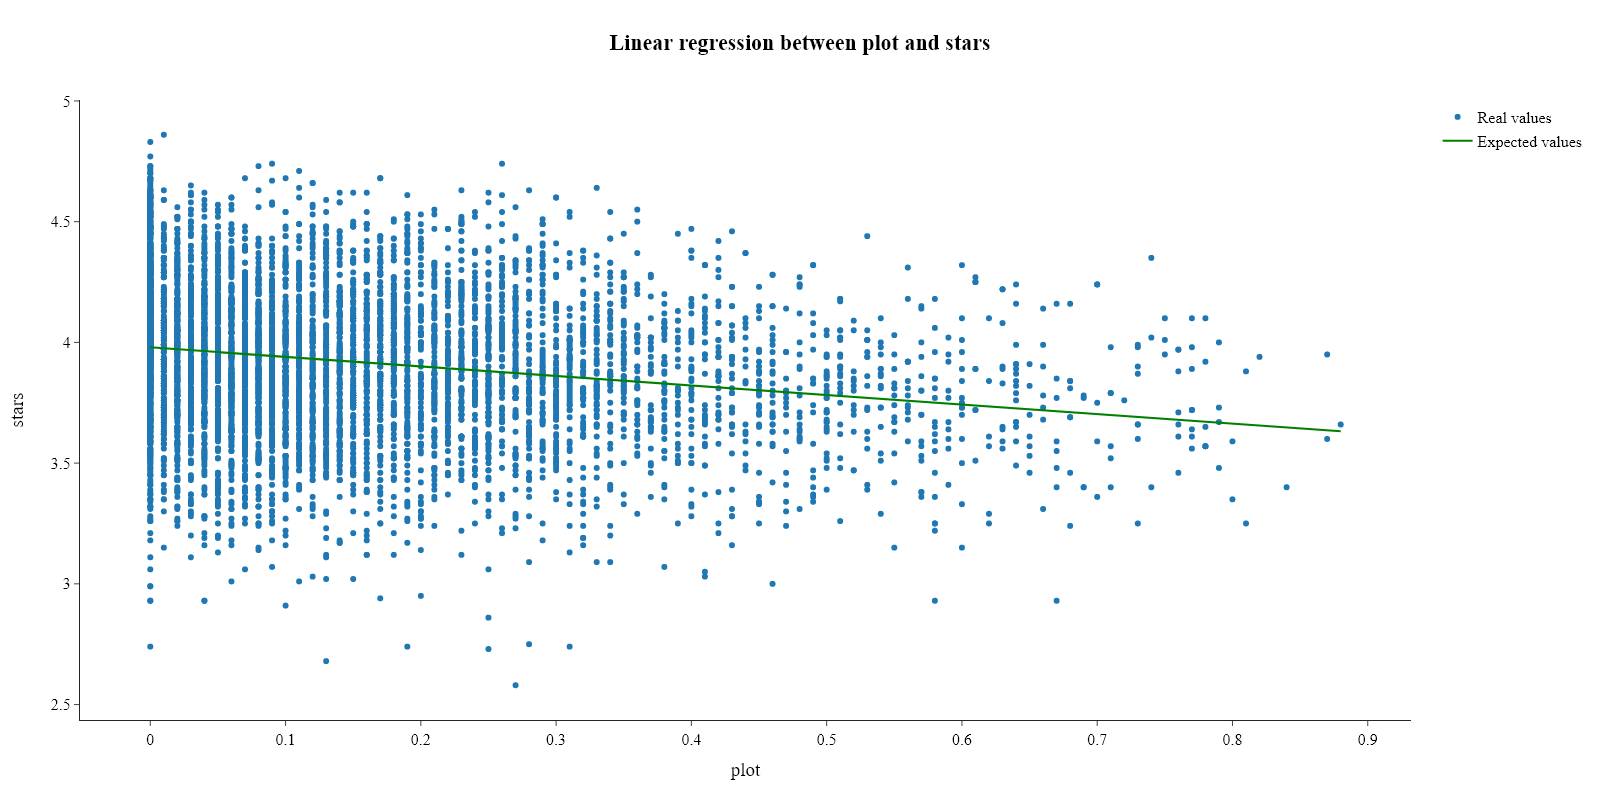

In [65]:
plots.linear_regression_plot(data, feature="plot", target=target)

### Unknown

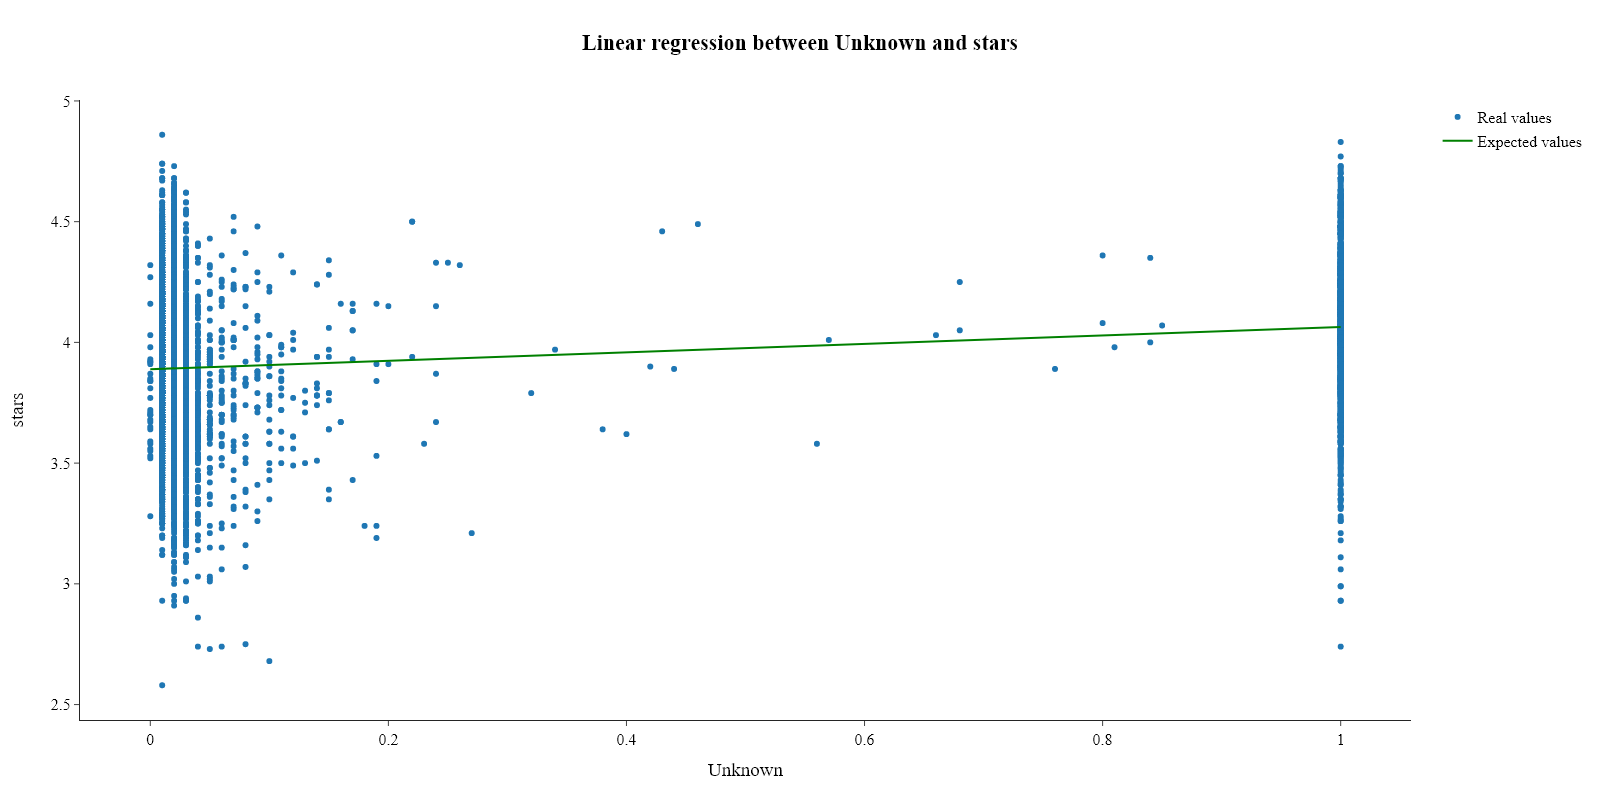

In [66]:
plots.linear_regression_plot(data, feature="Unknown", target=target)

### funny

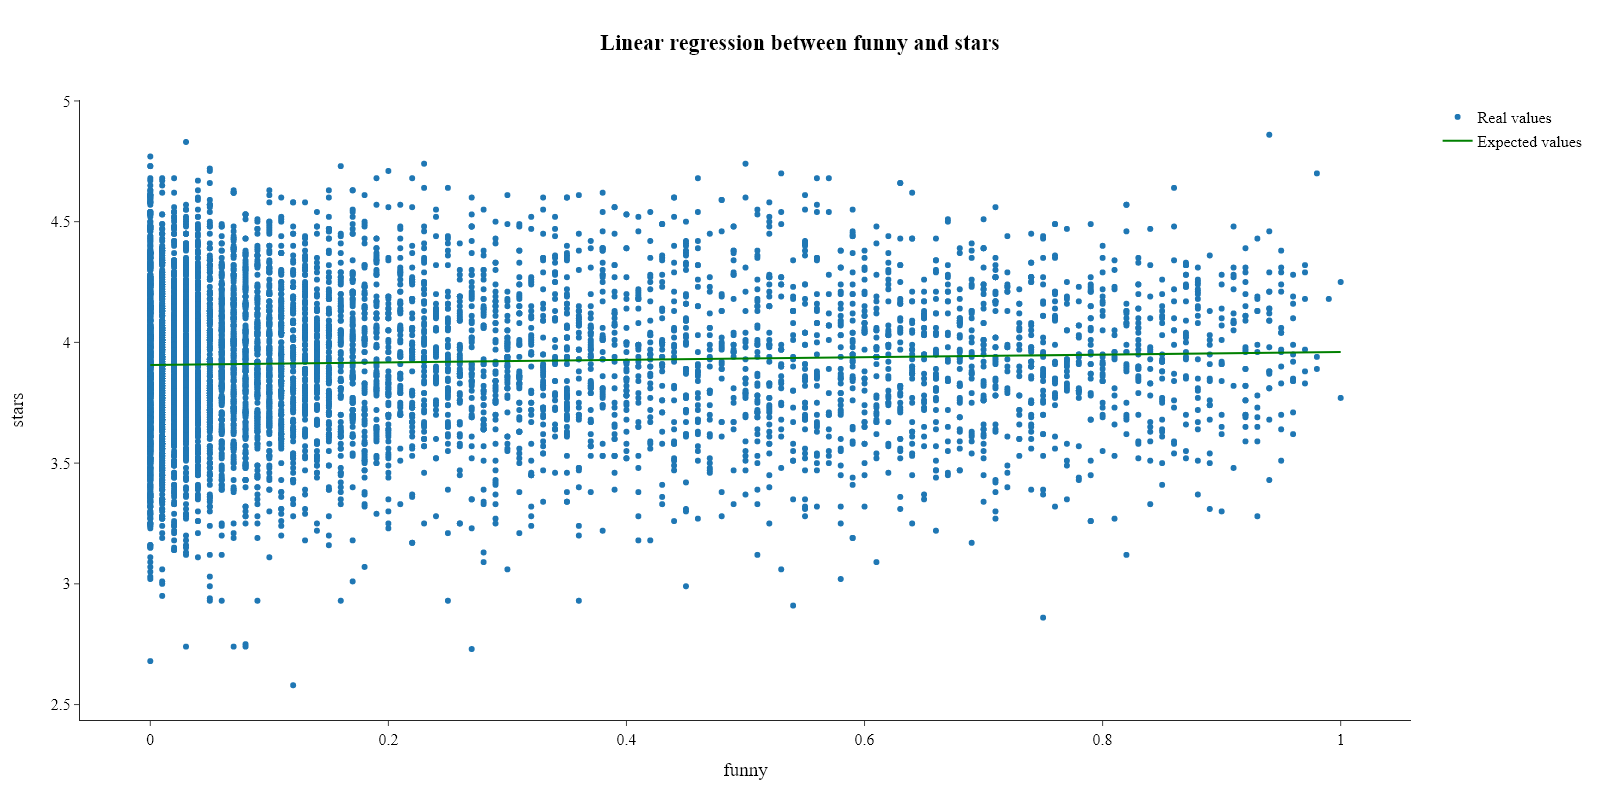

In [67]:
plots.linear_regression_plot(data, feature="funny", target=target)

### lighthearted

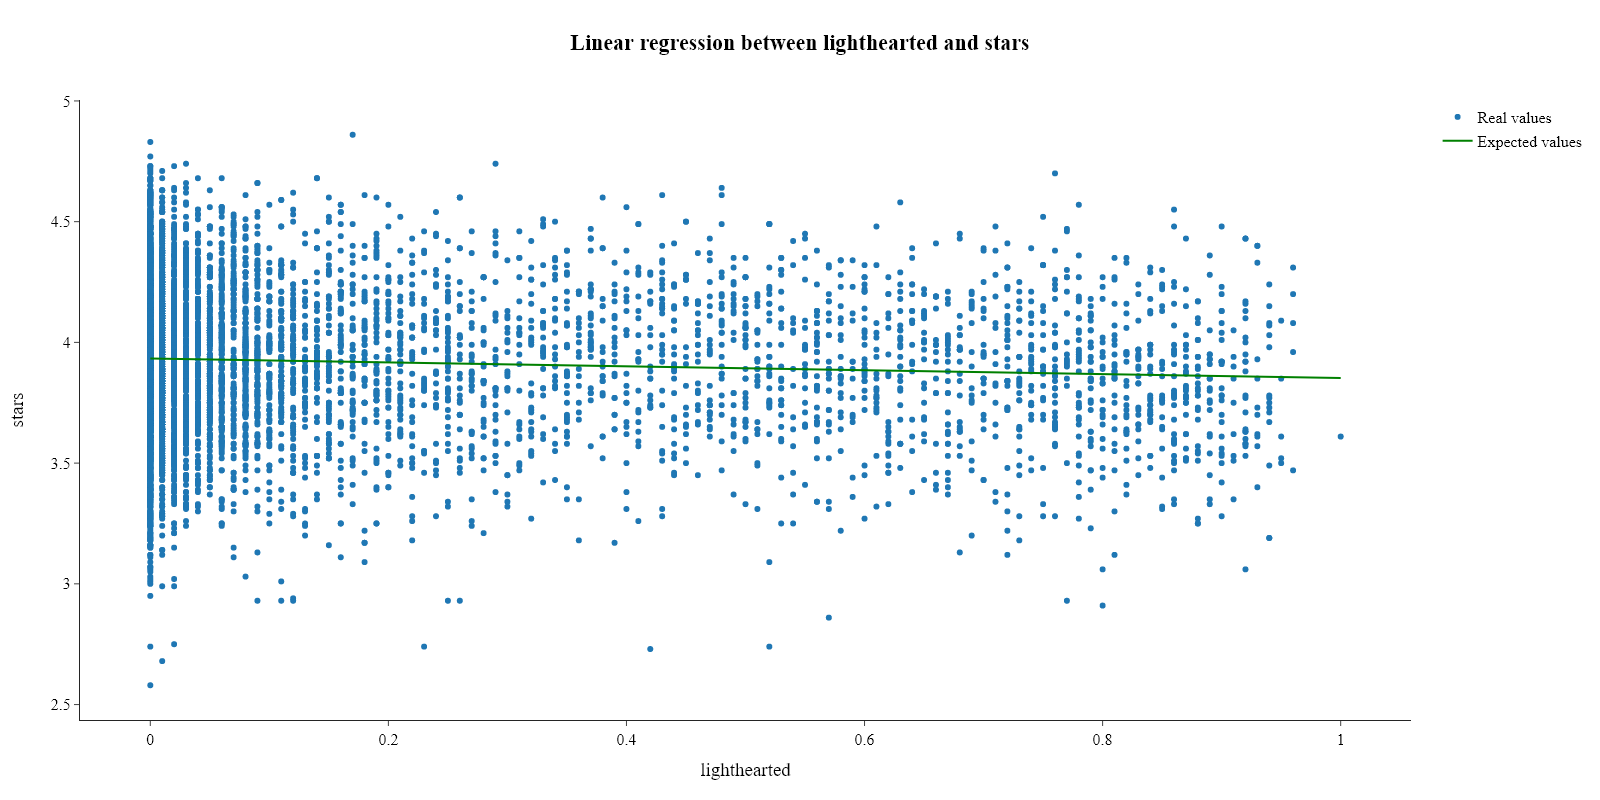

In [68]:
plots.linear_regression_plot(data, feature="lighthearted", target=target)

### emotional

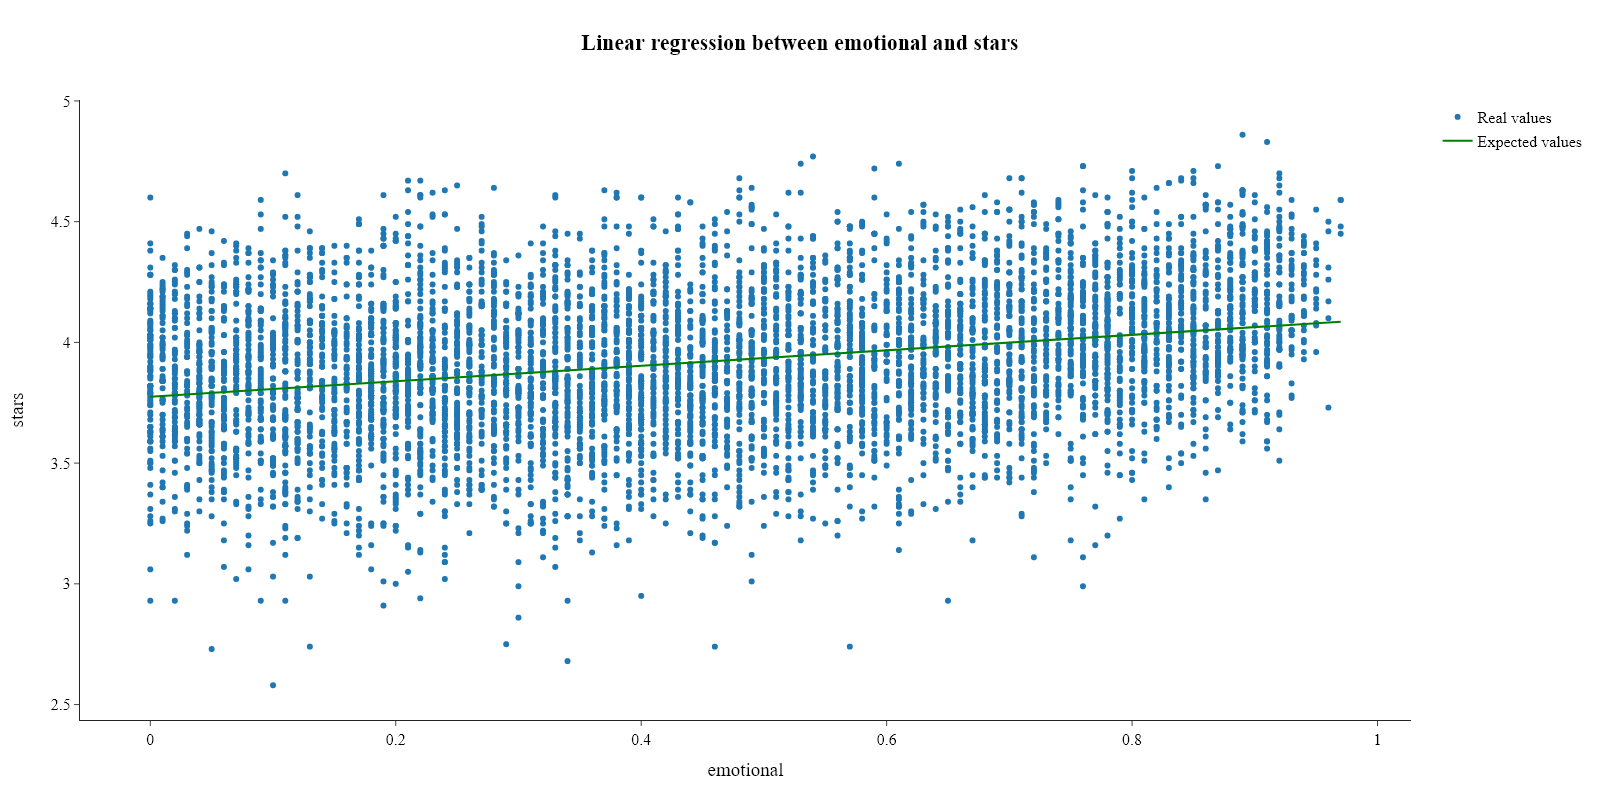

In [69]:
plots.linear_regression_plot(data, feature="emotional", target=target)

### hopeful

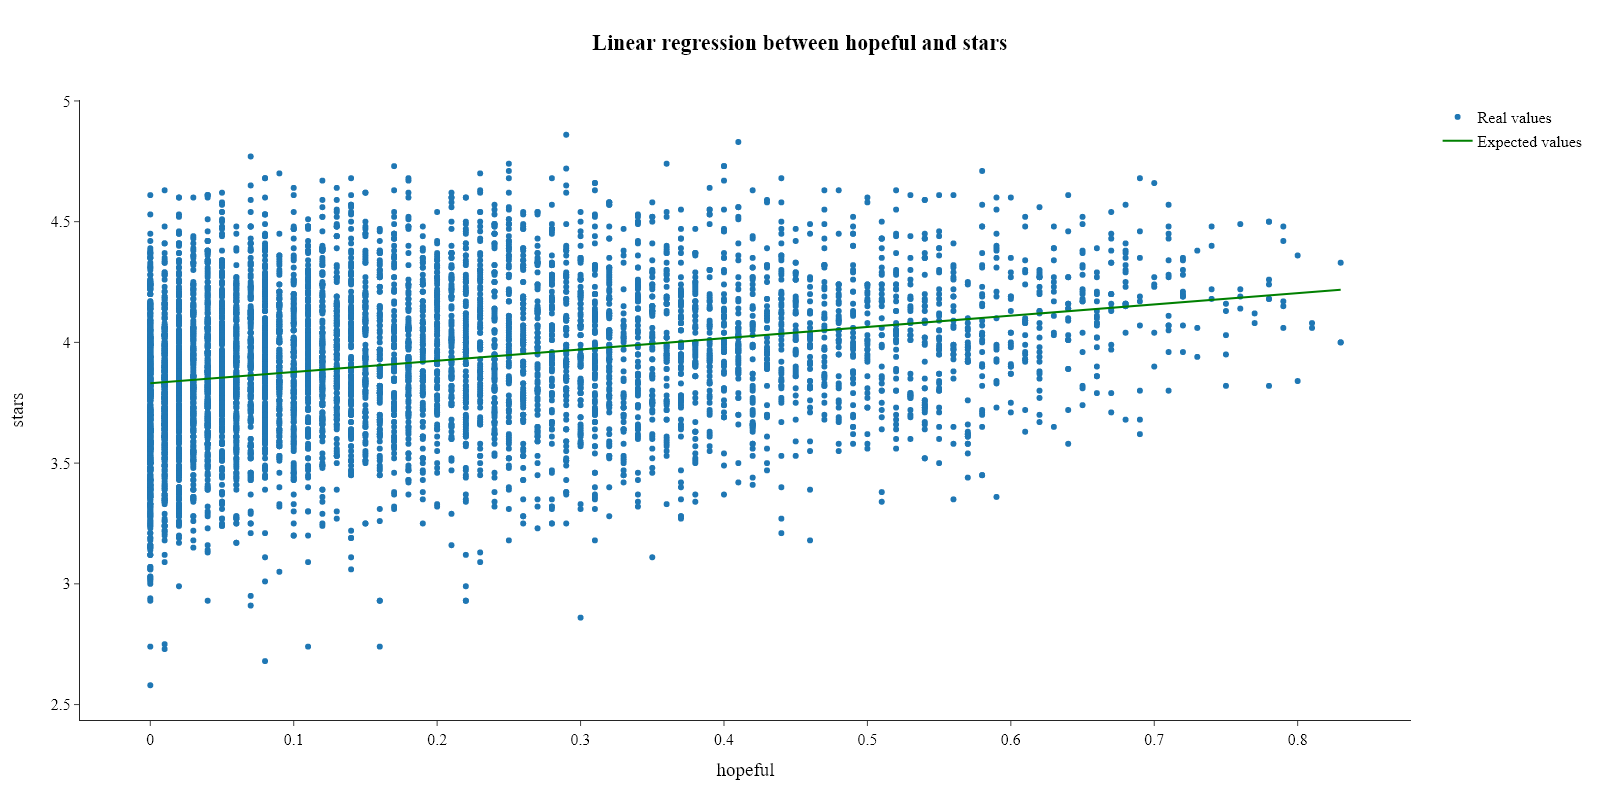

In [70]:
plots.linear_regression_plot(data, feature="hopeful", target=target)

### inspiring

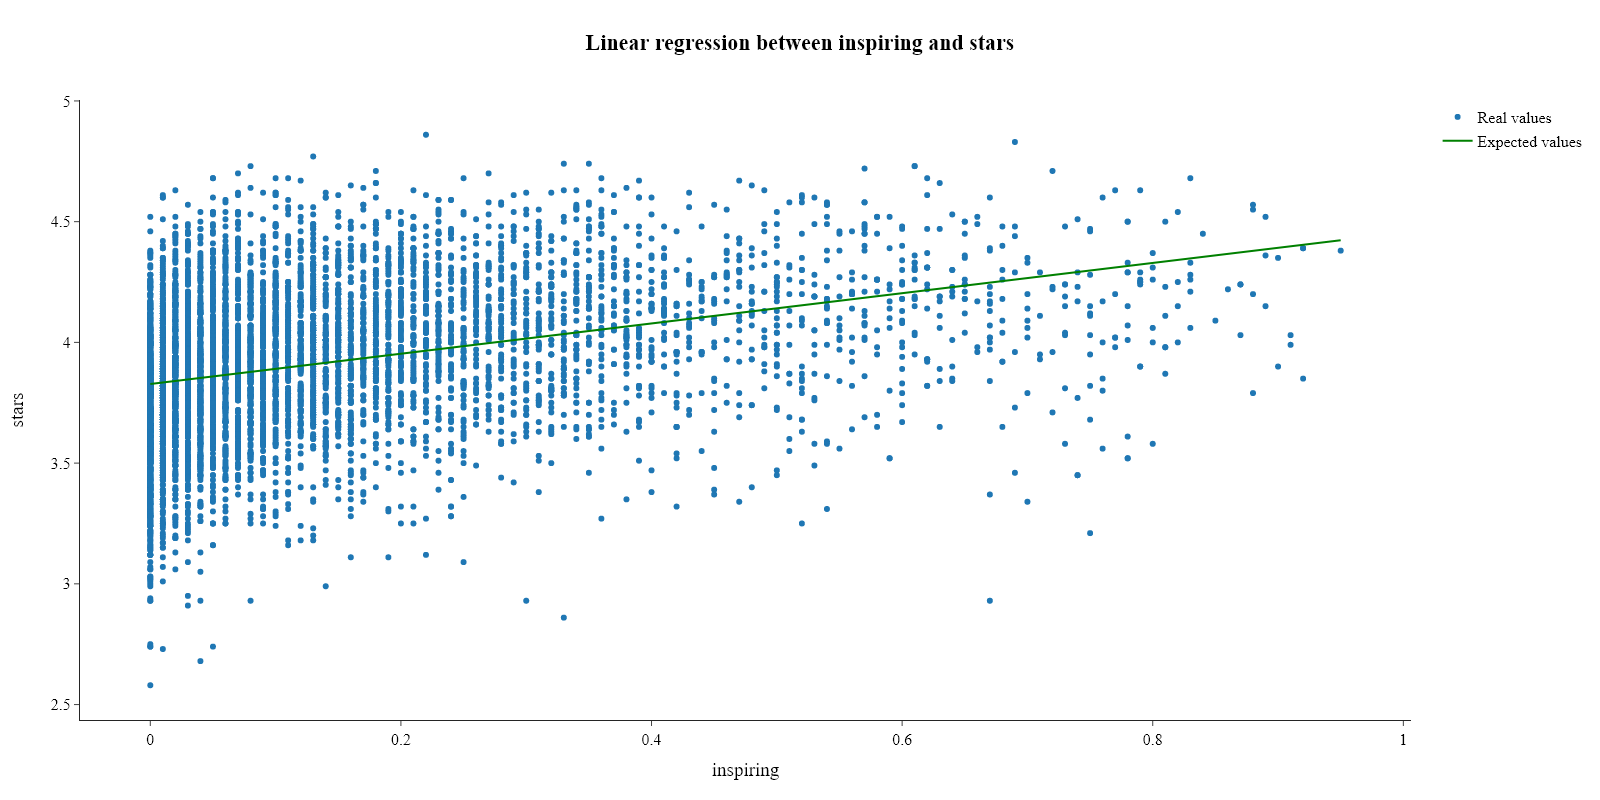

In [71]:
plots.linear_regression_plot(data, feature="inspiring", target=target)

### relaxing

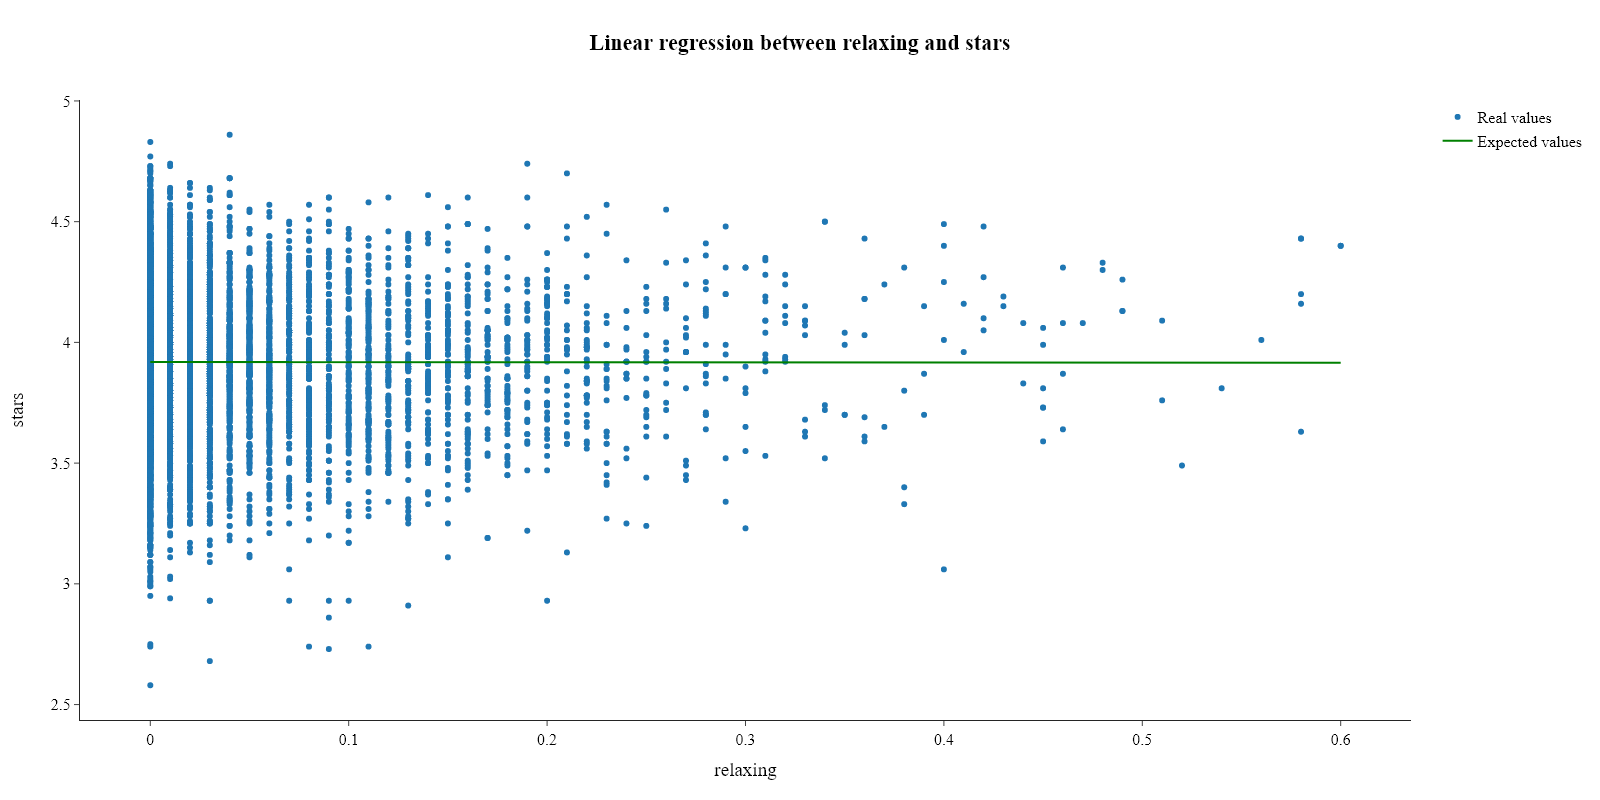

In [72]:
plots.linear_regression_plot(data, feature="relaxing", target=target)

### tense

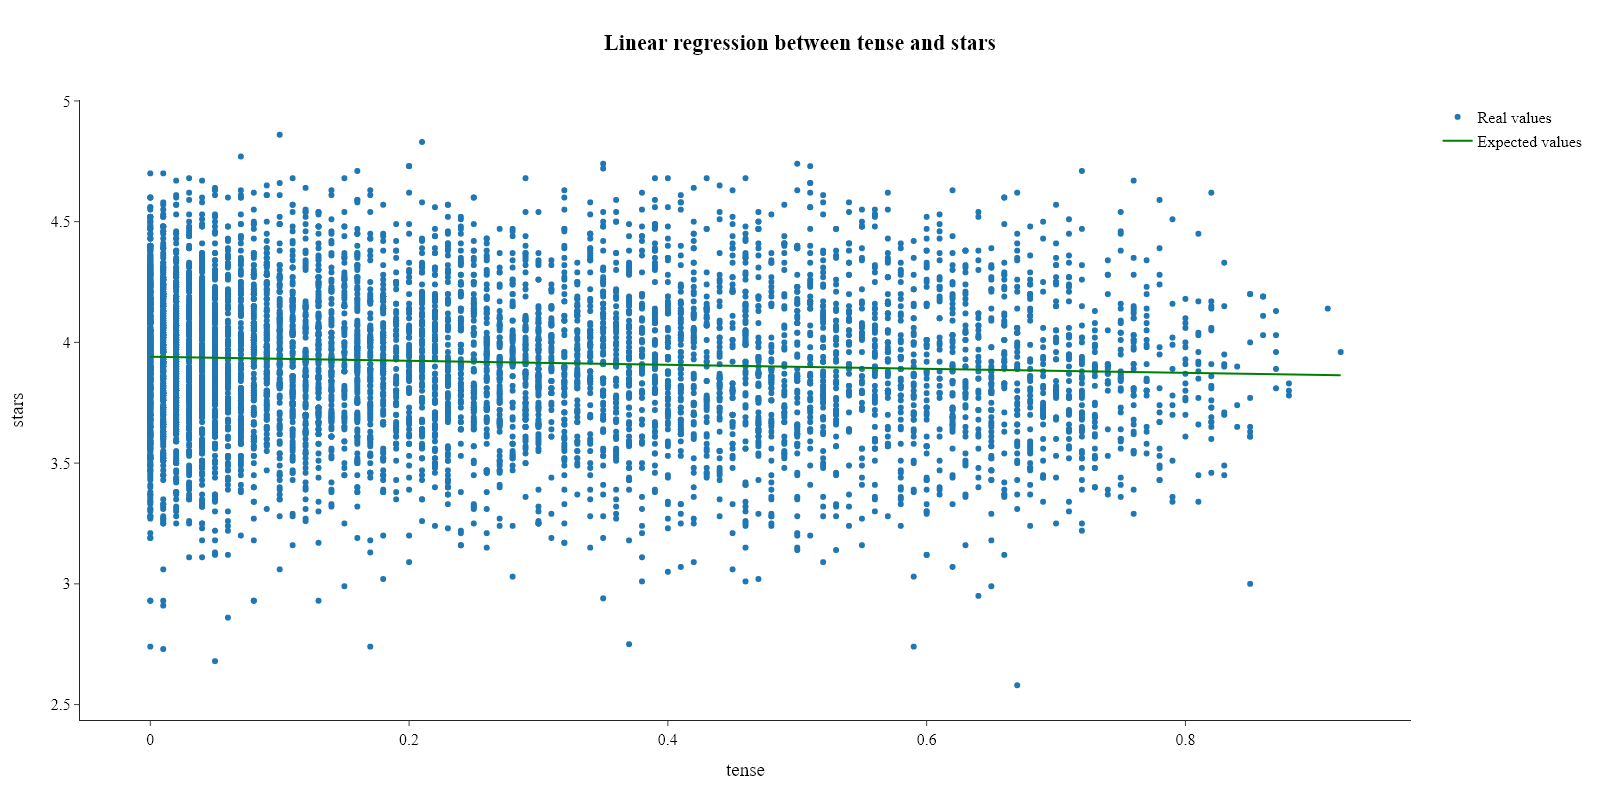

In [73]:
plots.linear_regression_plot(data, feature="tense", target=target)

### sad

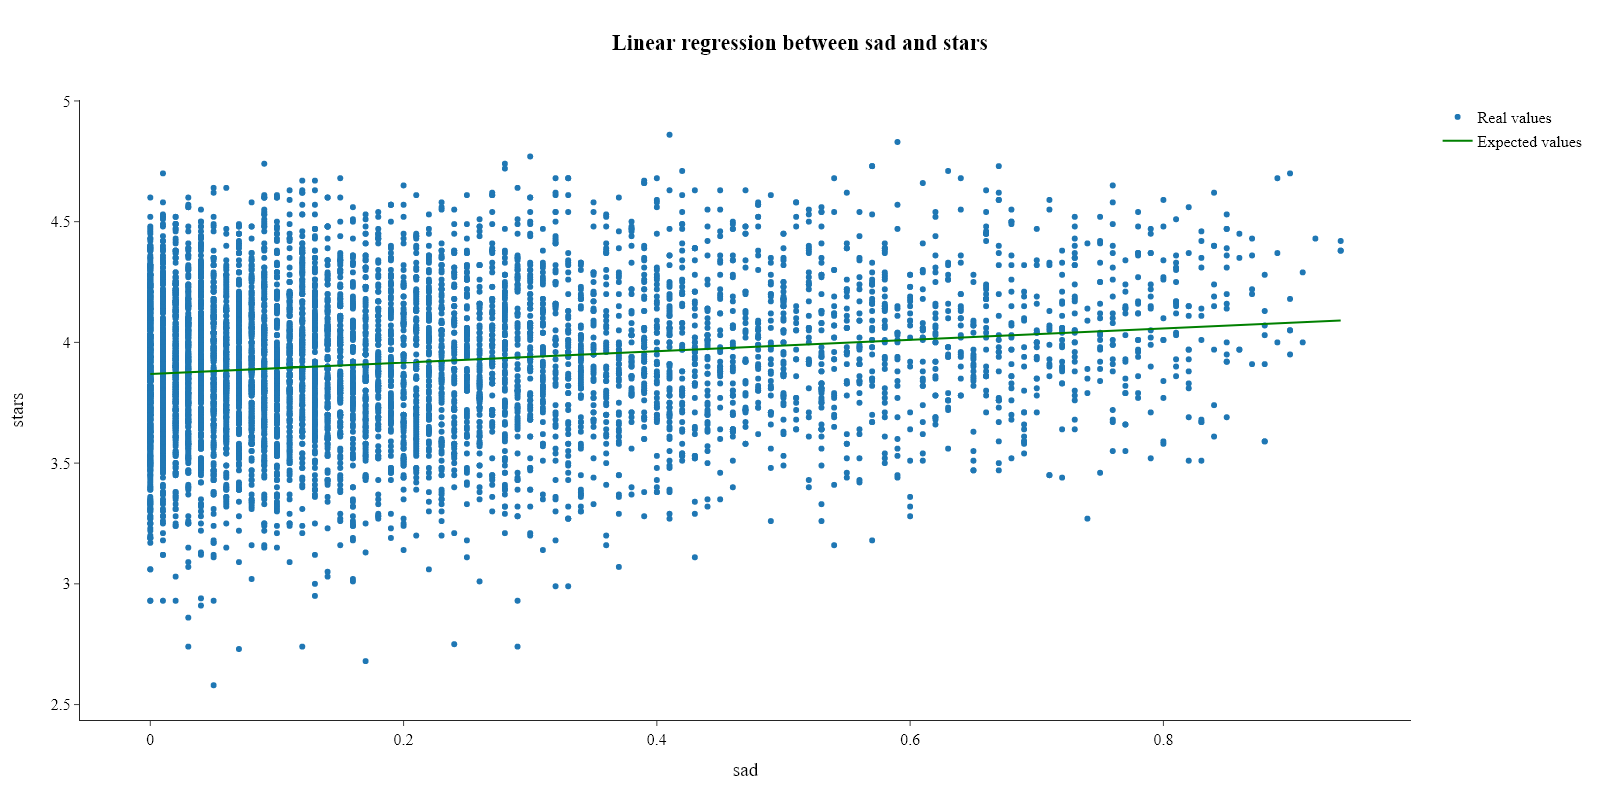

In [74]:
plots.linear_regression_plot(data, feature="sad", target=target)

### reflective

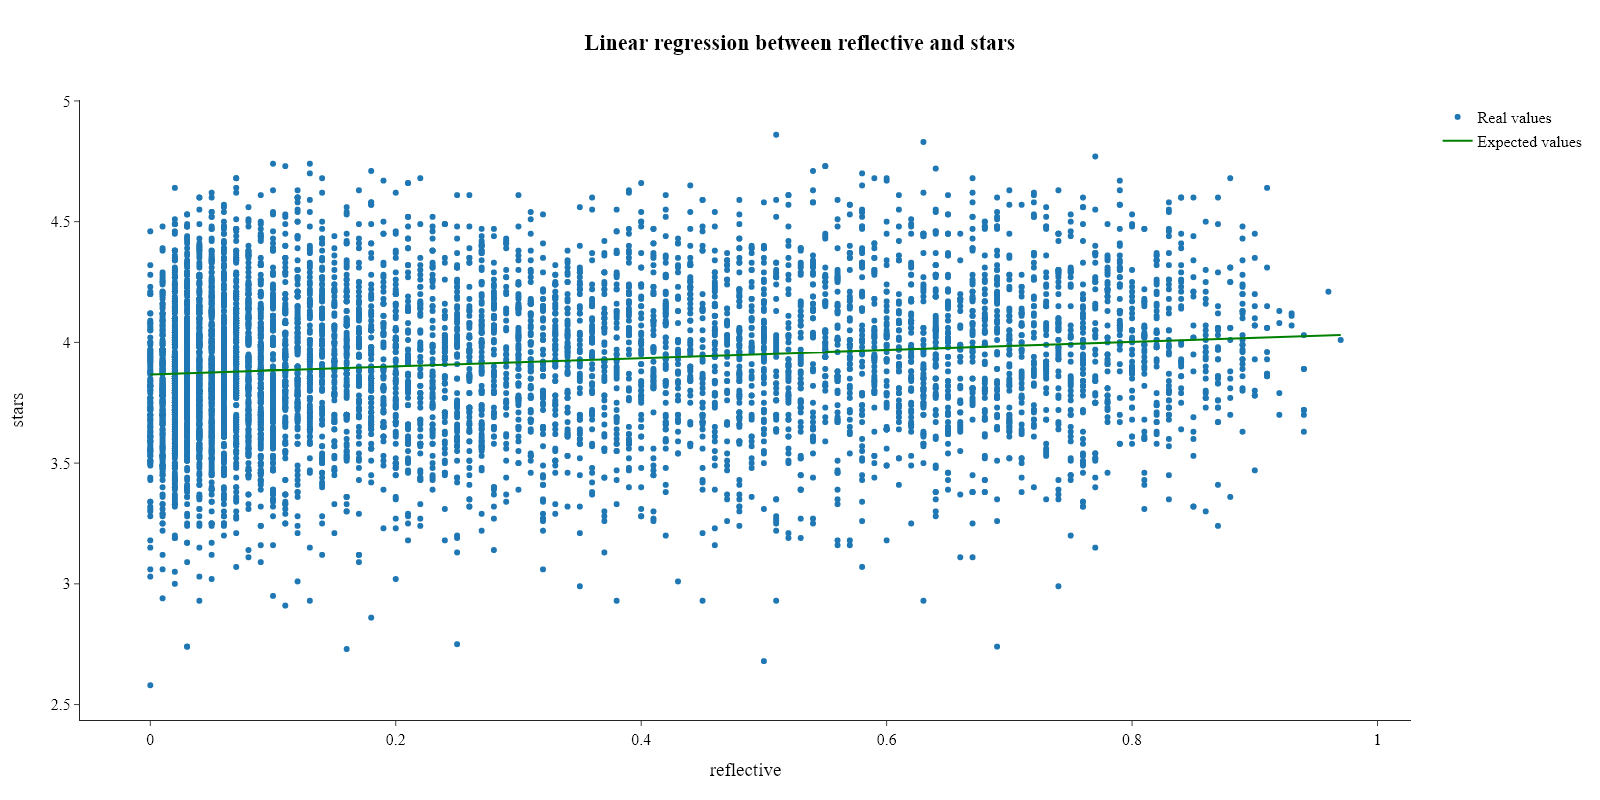

In [75]:
plots.linear_regression_plot(data, feature="reflective", target=target)

### adventurous

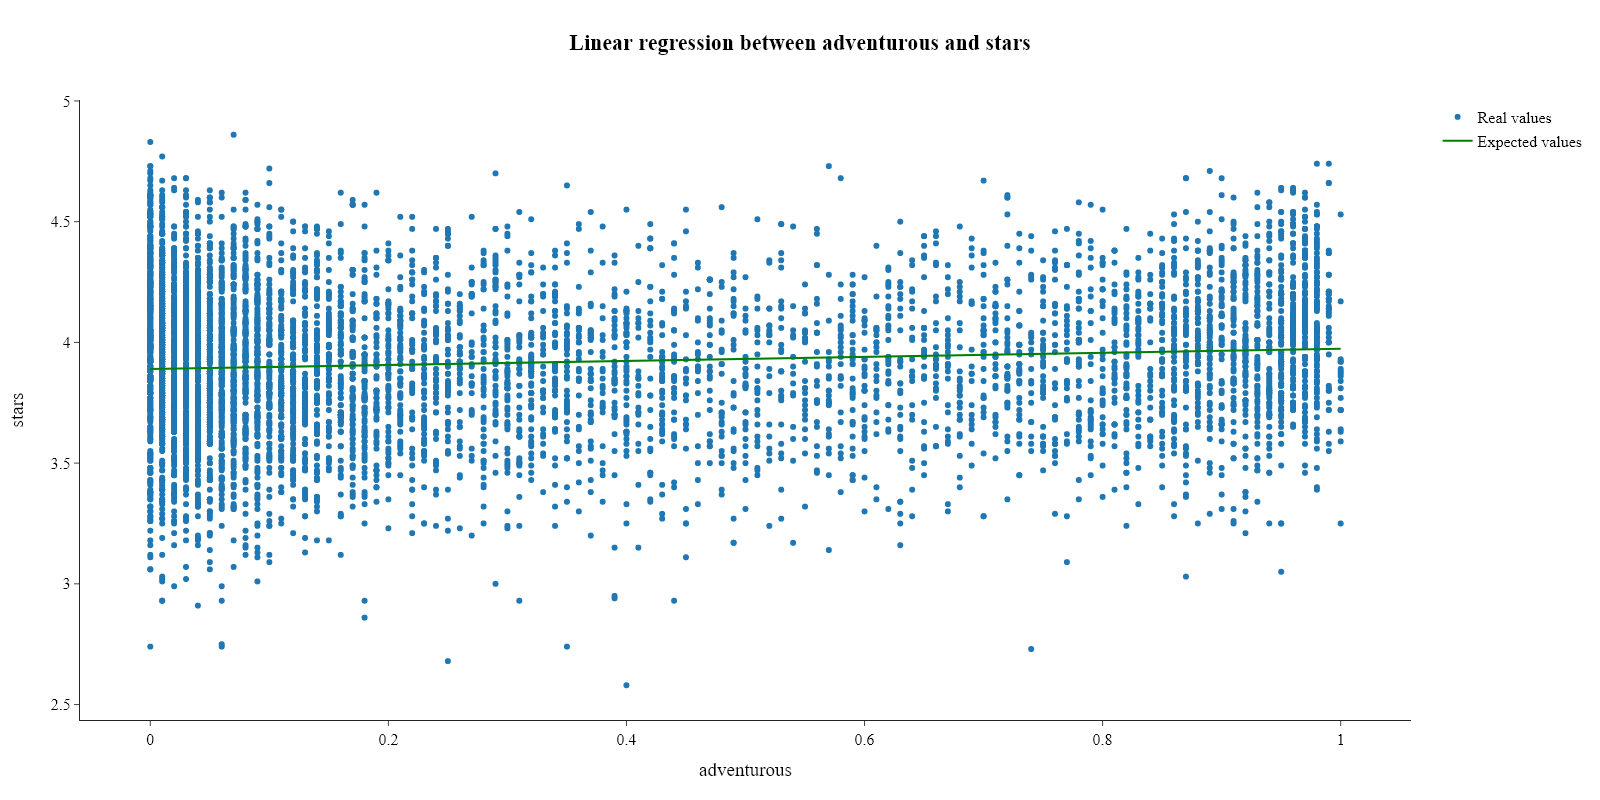

In [76]:
plots.linear_regression_plot(data, feature="adventurous", target=target)

### challenging

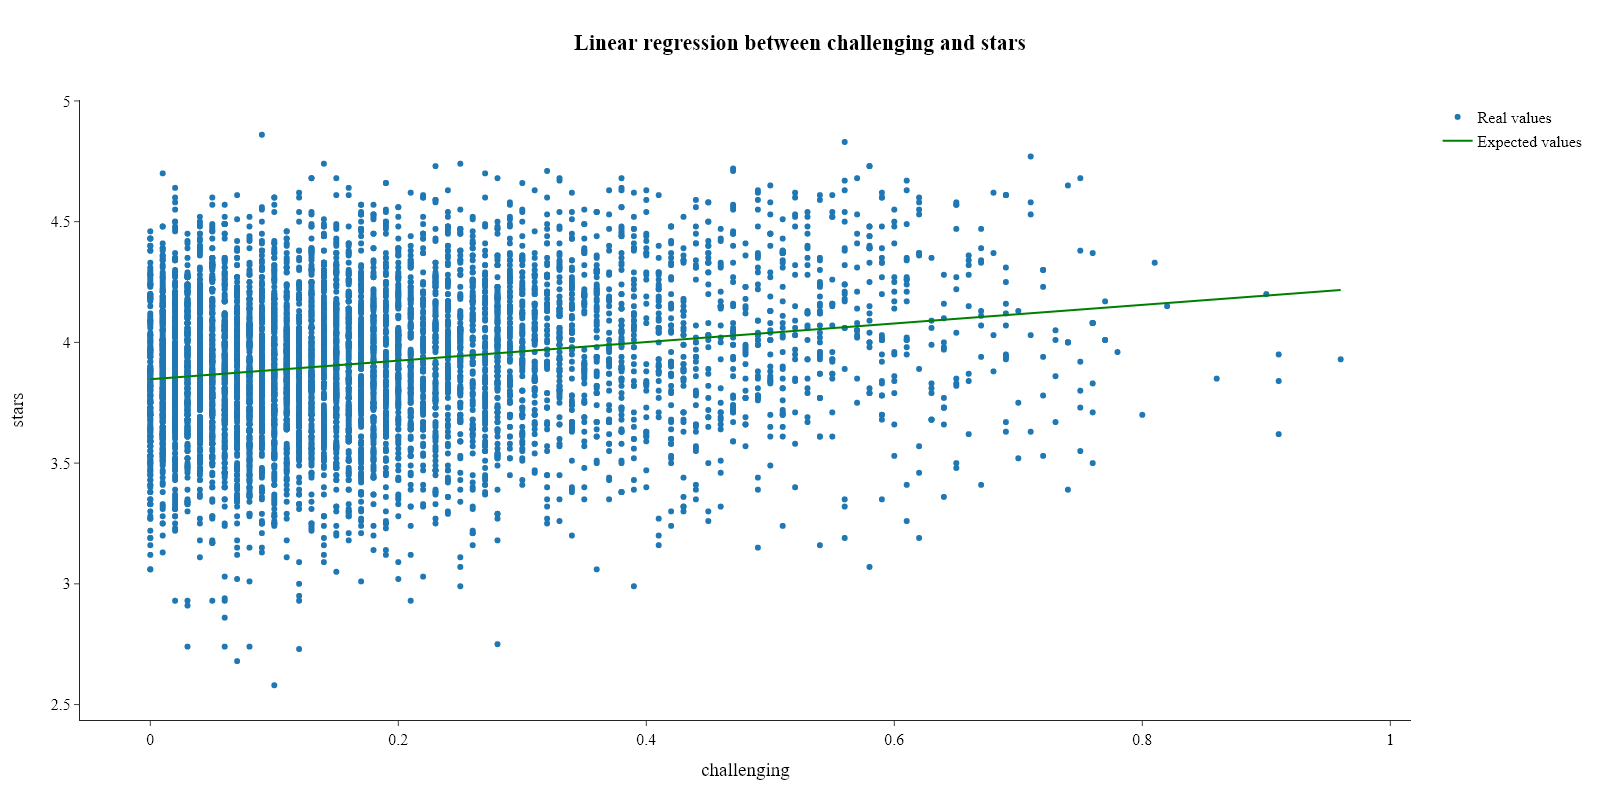

In [77]:
plots.linear_regression_plot(data, feature="challenging", target=target)

### informative

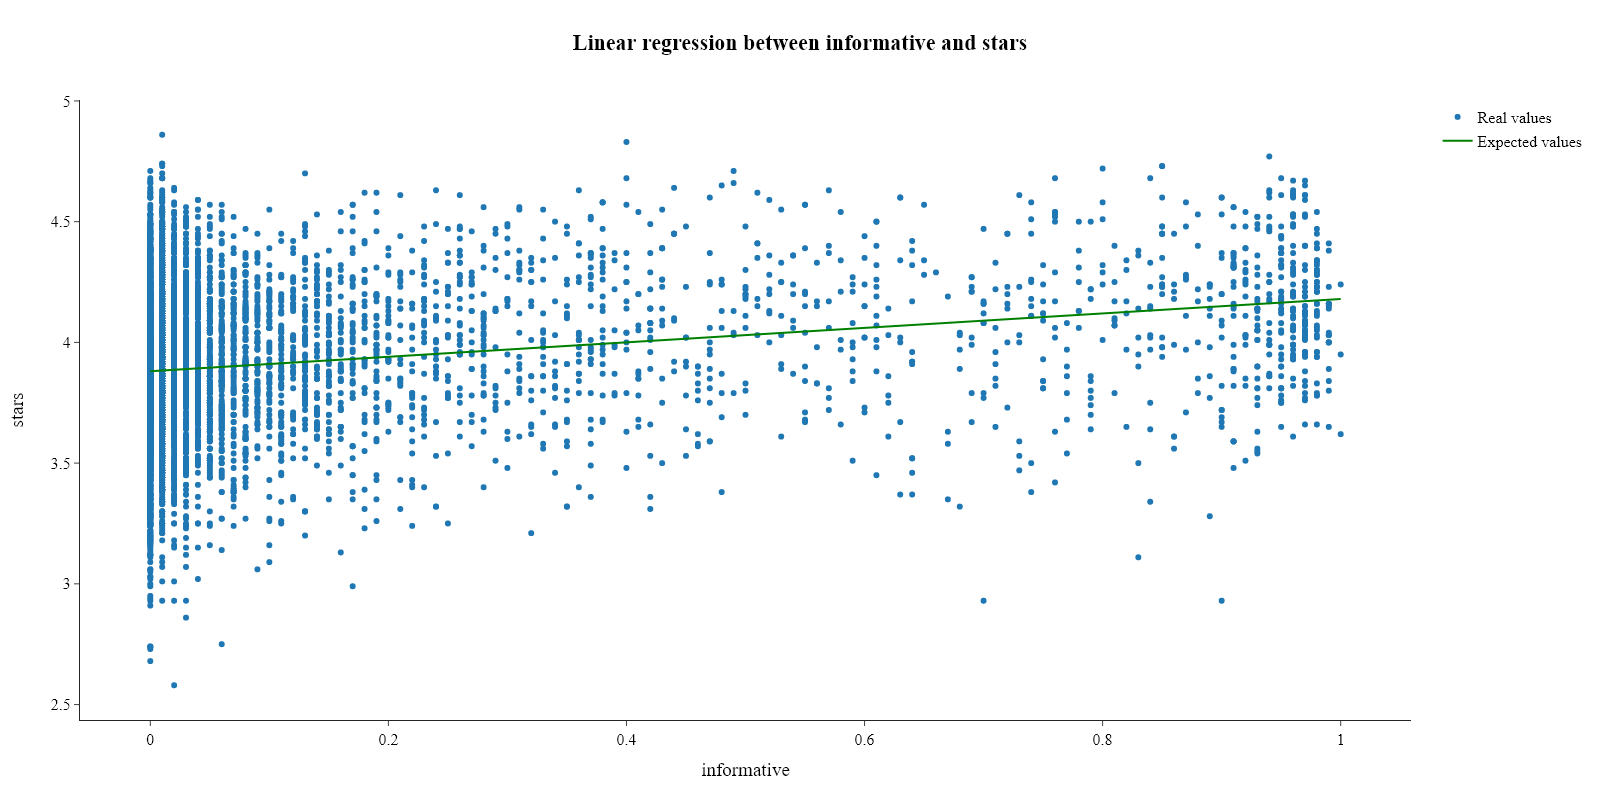

In [78]:
plots.linear_regression_plot(data, feature="informative", target=target)

### mysterious

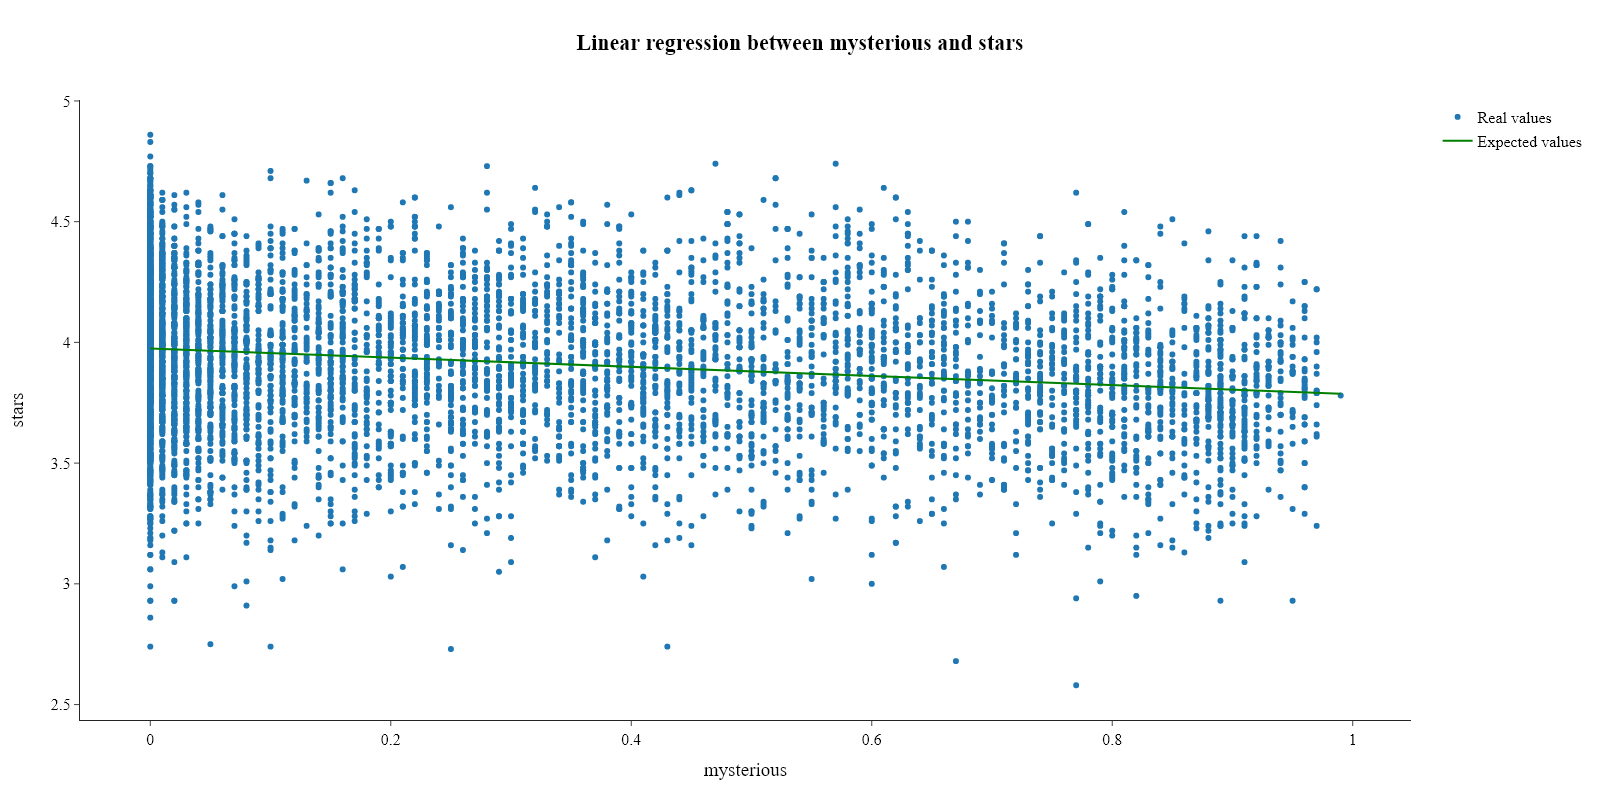

In [79]:
plots.linear_regression_plot(data, feature="mysterious", target=target)

### dark

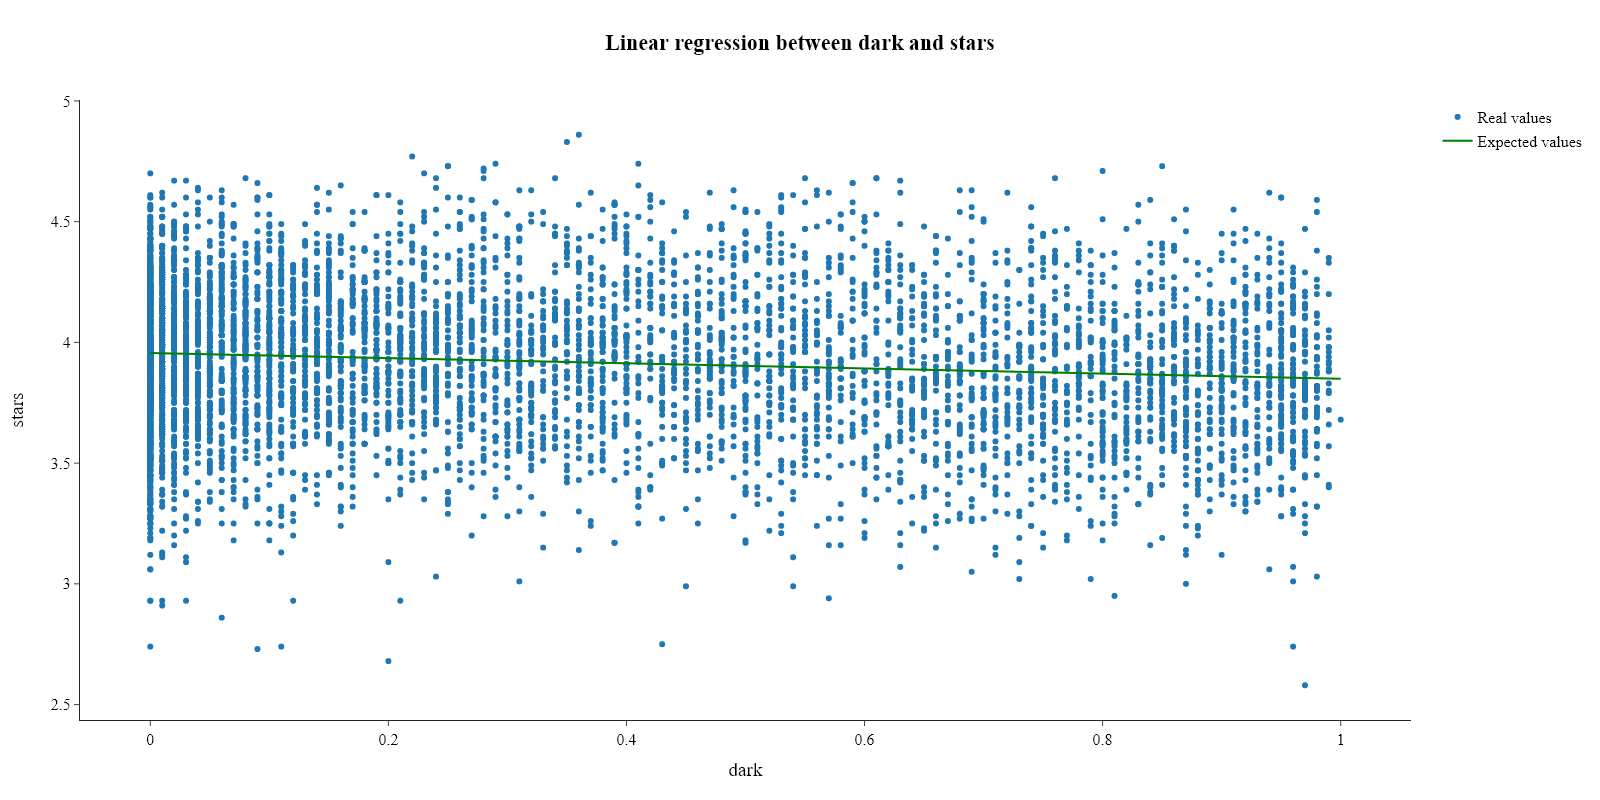

In [80]:
plots.linear_regression_plot(data, feature="dark", target=target)

$\text{Wnioski:}$<p>
$\text{1. Brak liniowych zależności między zmiennymi ciągłymi a zmienną celu.}$<p>
$\text{2. W przypadku niektórych cech (np.: mix, funny, czy relaxing) linia trendu jest pozioma, co sugeruje, że nie ma zależności między tymi zmienną a stars.}$

# Redundant data

$\text{Sekcja będzie poświęcona analizie zbioru w celu znalezienia zbędnych danych/zmiennych.}$<p>
$\text{W tym celu posługiwać się będziemy metodami statystycznymi.}$

## Korelacja

$\text{Poniższy wykres przedstawia korelację Pearsona między zmiennymi ciągłymi oraz zmienną celu.}$

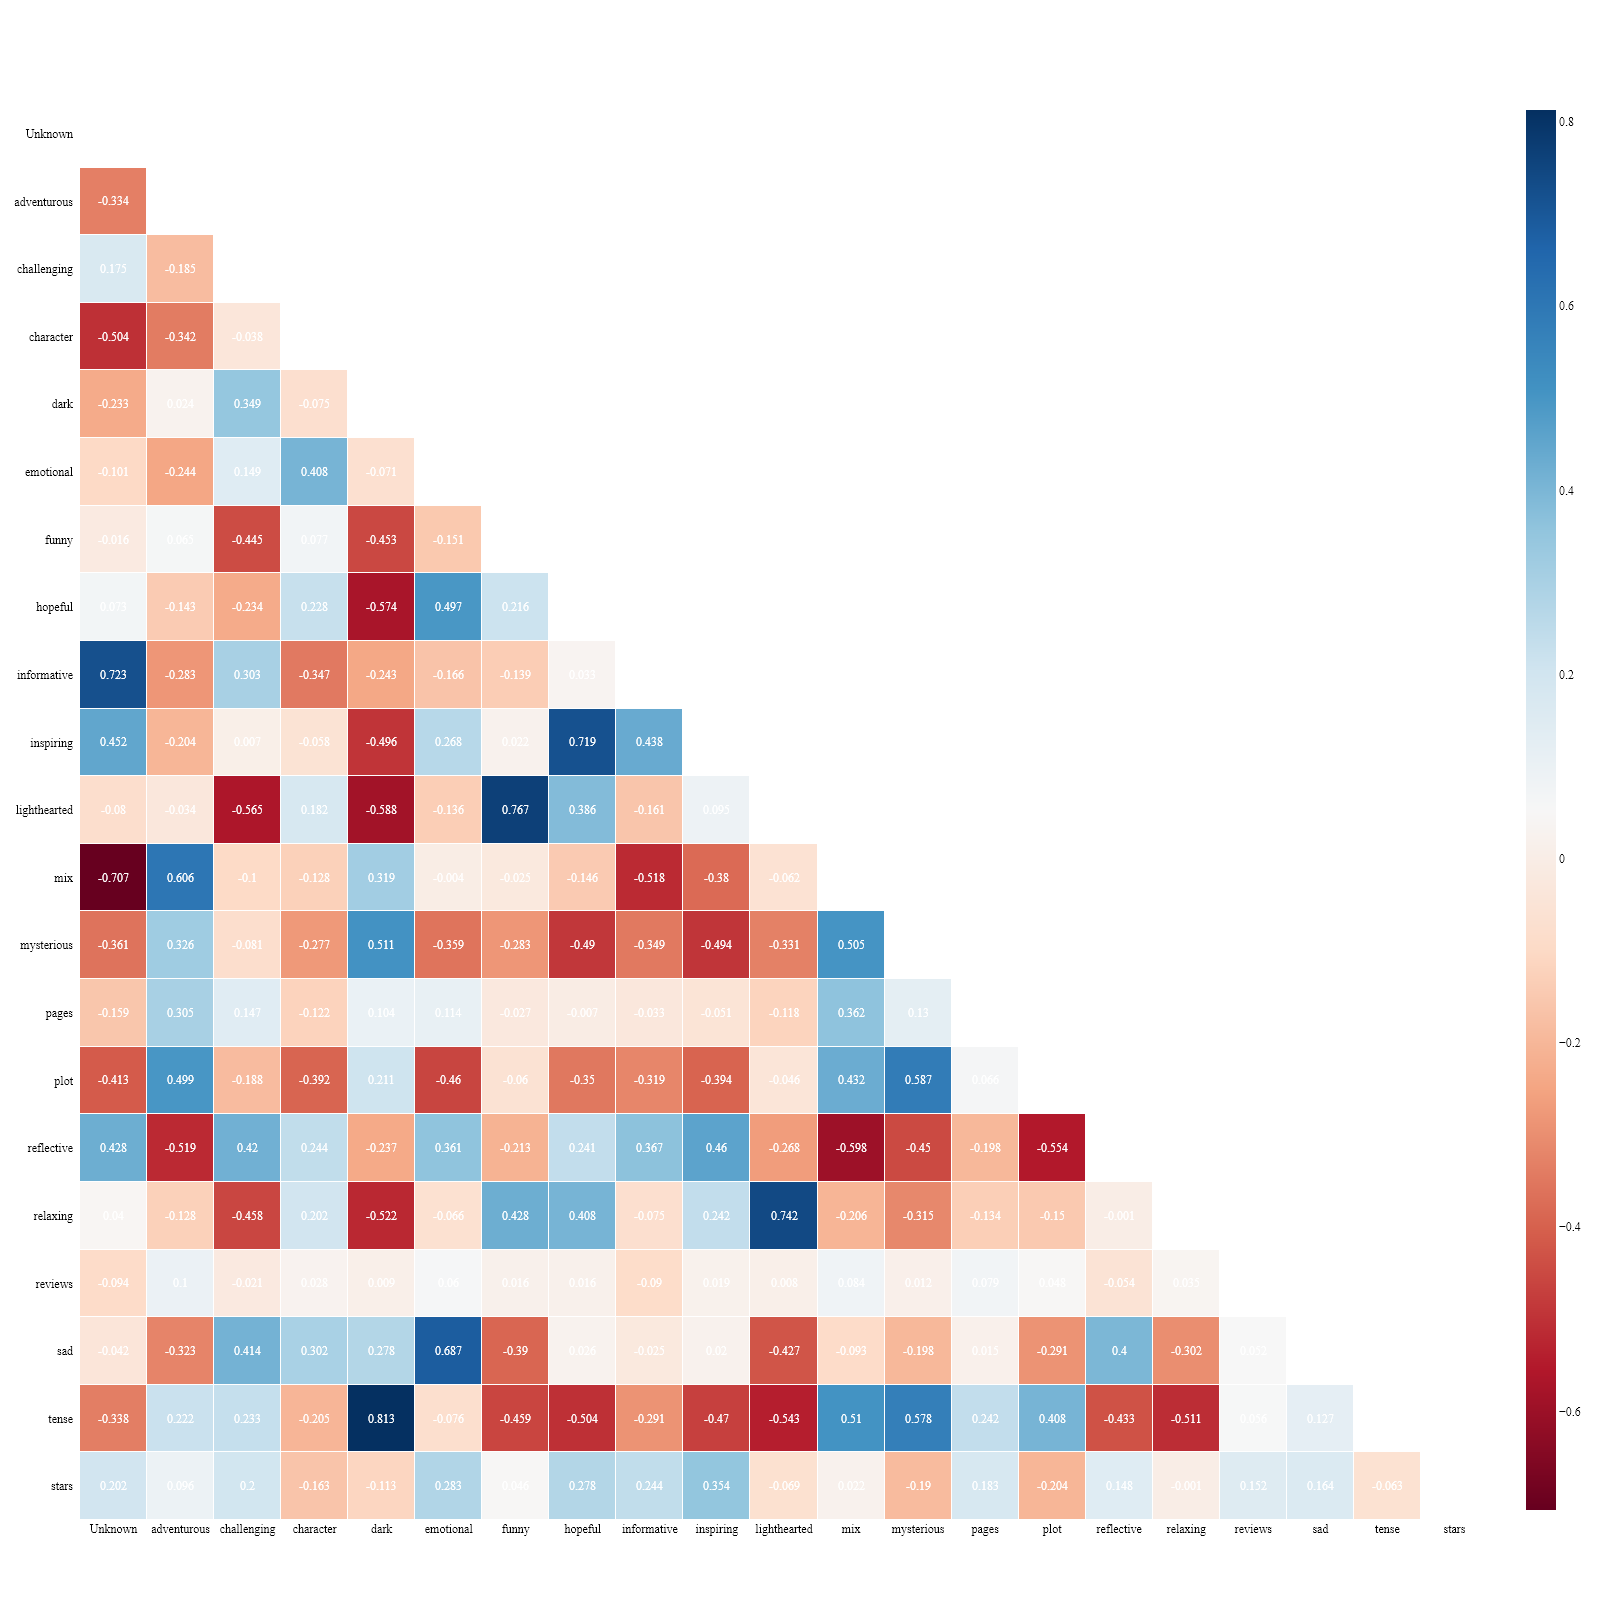

In [81]:
plots.correlation_plot(data=data[continous_features+[target]], features_names=data[continous_features+[target]].columns.tolist())

$\text{Macierz korelacji potwierdza, że między zmiennymi ciągłymi, a zmienną celu nie występuje silna liniowa korelacja.}$<p>
$\text{Warto jednak odnotować, że między niektórymi cechami objaśniającymi występuje wysoka wartość współczynnika korelacji Pearsona.}$<p>
$\text{Współczynnik korelacji Pearsona można zastosować tylko w sytuacji, gdy założenie o rozkładzie normalnym zmiennych jest zachowane.}$<p>
$\text{Pomimo tego, że histogramy przedstawione wyżej nie wskazują na to, aby cechy rozkład normalny, zweryfikujemy to za pomocą testu statystycznego Jarque-Bera.}$

In [82]:
jarque_bera_test = JarqueBera()
for feature in continous_features:
    keep_H0=True
    y_subset = data[feature]
    jarque_bera_test.fit(data=y_subset, alpha=0.05)
    if(jarque_bera_test.keep_H0 == True):
        print("{} ma rozkład normalny, ponieważ p_value > alpha ({} >= {}).".format(feature, round(jarque_bera_test.p_value_, 3), 0.05))
    else:
        print("{} nie ma rozkładu normalnego, ponieważ p_value < alpha ({} < {}).".format(feature, round(jarque_bera_test.p_value_, 3), 0.05))

Unknown nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
adventurous nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
challenging nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
character nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
dark nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
emotional nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
funny nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
hopeful nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
informative nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
inspiring nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
lighthearted nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
mix nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
mysterious nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
pages ni

$\text{Wyniki testu Jarque-Bera wskazują, że rozkłady zmiennych nie są normalne.}$<p>
$\text{W związku z tym zastosujemy testy nieparametryczne, które nie wymagają spełnienia założenia o normalności rozkładu.}$<p>
$\text{Do analizy korelacji wykorzystamy zatem test Spearmana.}$

In [83]:
spearman = SpearmanCorrelation()
i = 0
while(i < len(continous_features)):
    j = i+1
    while(j < len(continous_features)):
        spearman.fit(X=data[continous_features[i]], y=data[continous_features[j]], alpha=0.05)
        if(spearman.keep_H0 == False):
            print("Korelacja między {} i {} jest statystycznie istotna, ponieważ p_value < alpha ({} < {}).".format(continous_features[i], continous_features[j], round(spearman.p_value_, 3), 0.05))
        j = j + 1
    i = i + 1

Korelacja między Unknown i adventurous jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i challenging jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i character jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i dark jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i emotional jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i funny jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i hopeful jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i informative jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i inspiring jest statystycznie istotna, ponieważ p_value < alpha (nan < 0.05).
Korelacja między Unknown i lighthearted jest statystycznie istotna, p

c:\Users\Kuba\Desktop\KubiK\STUDIA\Ekonomia UW\Programowanie komputerowe\Programy\Python\Machine Learning\ML_24_projekt\scrapping\ML\utils\Spearman_Correlation.py:163: RuntimeWarning:

invalid value encountered in sqrt



$\text{Jak możemy zaobserwować powyżej, bazując na teście korelacji Spearmana większość zmiennych jest ze sobą statystycznie istotnie skorelowana.}$<p>
$\text{Do powyższego testu wprowadzimy lekką modyfikację w celu zweryfikowania, które zmienne są silnie skorelowane (wartość współczynnika korelacji > 0.8).}$

In [84]:
i = 0
while(i < len(continous_features)):
    j = i+1
    while(j < len(continous_features)):
        spearman.fit(X=data[continous_features[i]], y=data[continous_features[j]], alpha=0.05)
        if(spearman.keep_H0 == False and spearman.correlation_ > 0.8):
            print("Korelacja między {} i {} jest statystycznie istotna i wynosi: {}.".format(continous_features[i], continous_features[j], round(spearman.correlation_, 3)))
        j = j + 1
    i = i + 1

Korelacja między dark i tense jest statystycznie istotna i wynosi: 0.845.
Korelacja między hopeful i inspiring jest statystycznie istotna i wynosi: 0.817.
Korelacja między lighthearted i relaxing jest statystycznie istotna i wynosi: 0.831.


$\text{W zbiorze występują trzy pary zmiennych objaśniających, którym warto dokładniej się przyjrzeć na etapie selekcji cech do modelu.}$

$\text{Kolejnym wartym przeanalizowania testem statystycznym jest VIF, czyli analiza współliniowości.}$

In [85]:
VIF_test = VIF()
VIF_test.fit(data=data[continous_features])
VIF_test.summary_

c:\Users\Kuba\Desktop\KubiK\STUDIA\Ekonomia UW\Programowanie komputerowe\Programy\Python\Machine Learning\ML_24_projekt\scrapping\ML\utils\VIF.py:100: RuntimeWarning:

divide by zero encountered in scalar divide



Feature name       VIF
0        Unknown       inf
1    adventurous  2.950855
2    challenging  2.337706
3      character       inf
4           dark  5.162180
5      emotional  5.352695
6          funny  3.266564
7        hopeful  5.205259
8    informative  3.653729
9      inspiring  4.114154
10  lighthearted  9.693433
11           mix       inf
12    mysterious  3.225752
13         pages  1.396400
14          plot       inf
15    reflective  4.932082
16      relaxing  3.113515
17       reviews  1.046714
18           sad  3.664653
19         tense  5.850854

$\text{W przypadku, gdy } VIF > 10 \text{ warto rozpatrzeć usunięcie zmiennej z modelu, ponieważ może prowadzić do zaburzenia estymacji.}$<p>
$\text{W naszym przypadku wartość statystyki znacząco przekracza ten próg dla Unknown, character, mix oraz plot.}$<p>
$\text{Ma to związek z tym, że suma zmiennych wynosi 1 dla każdej obserwacji.}$<p>
$\text{Pomimo tego, że utworzona przez nas zmienna Unknown pozwoliła nieco lepiej zrozumieć zbiór, to wprowadzenie jej do modelu spowodowałoby błędy estymacyjne.}$<p>
$\text{Tym samym usuniemy cechę ze zbioru.}$

In [86]:
data.drop("Unknown", axis=1, inplace=True)
continous_features.remove("Unknown")

$\text{Zweryfikujmy jak teraz wyglądają wartości VIF.}$

In [87]:
VIF_test.fit(data=data[continous_features])
VIF_test.summary_

Feature name       VIF
0    adventurous  2.950855
1    challenging  2.337706
2      character  2.196828
3           dark  5.162180
4      emotional  5.352695
5          funny  3.266564
6        hopeful  5.205259
7    informative  3.653729
8      inspiring  4.114154
9   lighthearted  9.693433
10           mix  3.241795
11    mysterious  3.225752
12         pages  1.396400
13          plot  2.817168
14    reflective  4.932082
15      relaxing  3.113515
16       reviews  1.046714
17           sad  3.664653
18         tense  5.850854

$\text{Oczywiście wartości statystyki dla trzech zmiennych zmniejszyły się do zadowalających poziomów.}$<p>
$\text{Warto również zauważyć, że wysokim VIF charakteryzuje się cecha lighthearted, która również znalazła się wśród par silnie skorelowanych zmiennych.}$

$\text{W celu sprawdzenia, czy rozkład zmiennej celu różni się w zależności od kategorii zmiennych dyskretnych wykorzystamy test ANOVA.}$<p>
$\text{Zanim jednak do tego przystąpimy, należy sprawdzić, czy spełnione są założenia.}$<p>
$\text{Pierwsze z nich mówi o normalności rozkładu zmiennej w każdej z analizowanych podgrup.}$<p>
$\text{Podobnie jak w przypadku współczynnika korelacji Pearsona, wykorzystamy test Jarque Bera.}$

In [88]:
for feature in categorical_features:
    keep_H0=True
    for category in data[feature].value_counts().index:
        subset = data.loc[data[feature]==category, target]
        jarque_bera_test.fit(data=subset, alpha=0.05)
        if(jarque_bera_test.keep_H0 == False):
            keep_H0=False
            break
    print("{} ma rozkład normalny wewnątrz wszystkich kategorii cechy {}: {}.".format(target, feature, keep_H0))

stars ma rozkład normalny wewnątrz wszystkich kategorii cechy series: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Literature and Art: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Fiction: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Science: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Crime: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Psychology: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Social: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Children: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Romans: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Biography: False.
stars ma rozkład normalny wewnątrz wszystkich kategorii cechy Entertainment: False.


$\text{Wygląda na to, że rozkłady zmiennej celu w każdej z podgrup nie są normalne.}$<p>
$\text{W związku z tym zastosujemy test Kruskala-Wallisa, który jest nieparametryczną odpowiedzią na test ANOVA i bada czy mediany w grupach są równe.}$

In [89]:
kruskal_wallis_test = KruskalWallis()
for feature in categorical_features:
    kruskal_wallis_test.fit(X=data[feature], y=data[target], alpha=0.05)
    print("Mediany we wszystkich podgrupach zmiennej {} są takie same: {}.".format(feature, kruskal_wallis_test.keep_H0))

Mediany we wszystkich podgrupach zmiennej series są takie same: False.
Mediany we wszystkich podgrupach zmiennej Literature and Art są takie same: False.
Mediany we wszystkich podgrupach zmiennej Fiction są takie same: False.
Mediany we wszystkich podgrupach zmiennej Science są takie same: False.
Mediany we wszystkich podgrupach zmiennej Crime są takie same: False.
Mediany we wszystkich podgrupach zmiennej Psychology są takie same: False.
Mediany we wszystkich podgrupach zmiennej Social są takie same: False.
Mediany we wszystkich podgrupach zmiennej Children są takie same: False.
Mediany we wszystkich podgrupach zmiennej Romans są takie same: False.
Mediany we wszystkich podgrupach zmiennej Biography są takie same: False.
Mediany we wszystkich podgrupach zmiennej Entertainment są takie same: False.


$\text{Na podstawie testu Kruskala-Wallisa mediany zmiennej celu różnią się w zależności od kategorii zmiennych dyskretnych.}$<p>
$\text{Jest to raczej pozytywny sygnał, ponieważ oznacza, że cechy powinny różnicować stars.}$

# Podsumowanie

$\text{W tym notebooku przedstawiliśmy podstawowe informacje o zbiorze danych, a także dokonaliśmy wizualizacji zmiennych.}$<p>
$\text{Dane po wstępnej modyfikacji zostaną zapisane do pliku csv, który posłuży do dalszej analizy.}$

In [90]:
data.to_csv(os.path.join(parent_dir, 'data//data_eda.csv'))